In [1]:
import pandas as pd
import plotnine as p9


In [2]:
def json_array_to_values(json_array):
    json_array = json_array.replace("\\xa0", " ")
    json_array = eval(json_array)

    values = []
    for genre in json_array:
        values.append(genre["name"])

    return values


In [3]:
df_md = pd.read_csv("the-movies-dataset/movies_metadata.csv")
drop_columns = {
    "adult",
    "belongs_to_collection",
    "homepage",
    "imdb_id",
    "original_title",
    "overview",
    "poster_path",
    "status",
    "tagline",
    "video",
    "spoken_languages",
}

dropping = {
    "TV Movie",
    "Foreign",
}

movie_clusters = {
    "Adventure": ["Adventure", "Fantasy"], # OK
    "Horror": ["Horror", "Science Fiction"], # OK
    "Documentary": ["Documentary", "History", "War"],  # OK
    "Action": ["Action", "Thriller", "Mystery", "Crime", "Western"], # OK
    "Animation": ["Animation", "Music", "Family"], # OK
    "Comedy": ["Comedy", "Romance"],  # OK
    "Drama": ["Drama"],  # OK
}

# Let's assign the main genre to each movie
def assign_main_genre(genres, clusters=movie_clusters):
    genres = [genre for genre in genres if genre not in dropping and genre != ""]
    if len(genres) == 0:
        return None

    main_movie_genre = genres[0]

    for cluster, cluster_genres in clusters.items():
        if main_movie_genre in cluster_genres:
            return cluster

    return None

df_md.drop(drop_columns, axis=1, inplace=True)

# Convert the release_date column to year, month and day
df_md = df_md[df_md["release_date"].str.len() == 10]
df_md["release_date"] = pd.to_datetime(df_md["release_date"])
df_md["release_year"] = df_md["release_date"].dt.year
df_md["release_month"] = df_md["release_date"].dt.month
df_md["release_day"] = df_md["release_date"].dt.day
df_md["release_quarter"] = df_md["release_date"].dt.quarter


df_md.dropna(subset=["release_year"], inplace=True)
df_md.dropna(subset=["release_month"], inplace=True)
df_md.dropna(subset=["release_day"], inplace=True)
df_md.dropna(subset=["release_quarter"], inplace=True)

df_md["season"] = df_md["release_month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else ("Spring" if x in [3, 4, 5] else ("Summer" if x in [6, 7, 8] else "Fall"))
)

df_md.drop("release_date", axis=1, inplace=True)

# df_md = df_md[df_md["release_year"] >= 2000]
# df_md = df_md[df_md["release_year"] <= 2016]

numeric_columns = [
    "id",
    "budget",
    "revenue",
    "runtime",
    "popularity",
    "vote_average",
    "vote_count",
    "release_year",
    "release_month",
    "release_day",
]

for column in numeric_columns:
    df_md[column] = pd.to_numeric(df_md[column], errors="coerce")

df_md.dropna(subset=numeric_columns, inplace=True)

# Convert the json columns to arrays
df_md["genres"] = df_md["genres"].apply(lambda x: json_array_to_values(x))
df_md["production_countries"] = df_md["production_countries"].apply(
    lambda x: json_array_to_values(x)
)
df_md["production_companies"] = df_md["production_companies"].apply(
    lambda x: json_array_to_values(x)
)

df_md = df_md[df_md["budget"] > 0]
df_md = df_md[df_md["revenue"] > 0]
df_md = df_md[df_md["production_companies"].apply(lambda x: len(x)) > 0]

# Create a new column with the main genre and the genre count
df_md["main_genre"] = df_md["genres"].apply(lambda x: assign_main_genre(x, movie_clusters))
df_md.dropna(subset=["main_genre"], inplace=True)
df_md["genre_count"] = df_md["genres"].apply(lambda x: len(x))


/var/folders/s0/tqtx5tfn21b8rys89pkqht4m0000gn/T/ipykernel_43550/2404306337.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df_kw = pd.read_csv("the-movies-dataset/keywords.csv")

df_kw["id"] = pd.to_numeric(df_kw["id"], errors="coerce")
df_kw.dropna(subset=["id"], inplace=True)

df_kw["keywords"] = df_kw["keywords"].apply(lambda x: json_array_to_values(x))


In [23]:
df_main = pd.merge(df_md, df_kw, left_on="id", right_on="id", how="left")
df_main.head().transpose()

# Save the processed data
df_main.to_csv("the-movies-dataset/processed.csv", index=False)


In [6]:
# Count na values
df_main.isna().sum()


budget                  0
genres                  0
id                      0
original_language       0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
title                   0
vote_average            0
vote_count              0
release_year            0
release_month           0
release_day             0
release_quarter         0
season                  0
main_genre              0
genre_count             0
keywords                0
dtype: int64

In [17]:
# Number of movies produced between 2010 and 2016
df_main[df_main["release_year"].isin(range(2010, 2017))].shape[0]


1568

In [7]:
# Create a table of the top 10 ROI movies
df_roi = df_main.copy()
df_roi = df_roi[df_roi["release_year"] >= 1980]
df_roi["roi"] = df_roi["revenue"] / df_roi["budget"]
df_roi = df_roi.sort_values(by=["roi"], ascending=False)
# min-max normalization of popularity
df_roi["popularity"] = (df_roi["popularity"] - df_roi["popularity"].min()) / (
    df_roi["popularity"].max() - df_roi["popularity"].min()
)
df_roi = df_roi.head(10)
df_roi = df_roi[["title", "release_year", "budget", "revenue", "roi", "production_companies", "popularity"]]
df_roi.to_csv("top-10-roi.csv", index=False)

df_roi


title  release_year  budget      revenue  \
1444                   Less Than Zero          1987       1   12396383.0   
3389            Welcome to Dongmakgol          2005       8   33579813.0   
876           The Karate Kid, Part II          1986     113  115103979.0   
4528                        Nurse 3-D          2013      10   10000000.0   
3657               From Prada to Nada          2011      93    2500000.0   
3359              Paranormal Activity          2007   15000  193355800.0   
981           The Blair Witch Project          1999   60000  248000000.0   
5098  The Tiger: An Old Hunter's Tale          2015    5000   11083449.0   
3988          Love, Wedding, Marriage          2011       1       1378.0   
2298                    Super Size Me          2004   65000   28575078.0   

               roi                               production_companies  \
1444  1.239638e+07  [Twentieth Century Fox Film Corporation, Amerc...   
3389  4.197477e+06                                     [Film It Suda]   
876   1.018619e+06  [Columbia Pictures Corporation, Delphi V Produ...   
4528  1.000000e+06            [Lions Gate, Lions Gate Entertainments]   
3657  2.688172e+04  [Lewis Gilbert Productions, Lionsgate, Modern ...   
3359  1.289039e+04              [Blumhouse Productions, Solana Films]   
981   4.133333e+03               [Artisan Entertainment, Haxan Films]   
5098  2.216690e+03         [Next Entertainment World, Sanai Pictures]   
3988  1.378000e+03  [120dB Films, Scion Films, Voodoo Production S...   
2298  4.396166e+02                                 [Kathbur Pictures]   

      popularity  
1444    0.007303  
3389    0.007657  
876     0.016806  
4528    0.009428  
3657    0.020213  
3359    0.023154  
981     0.027048  
5098    0.006242  
3988    0.007360  
2298    0.009563

In [16]:
# Biggest profits
df_profit = df_main.copy()
df_profit = df_profit[df_profit["release_year"] >= 1980]
df_profit["profit"] = df_profit["revenue"] - df_profit["budget"]
df_profit = df_profit.sort_values(by=["profit"], ascending=False)
df_profit = df_profit.head(100)
df_profit = df_profit[["title", "release_year", "budget", "revenue", "profit", "production_companies"]]
df_profit.to_csv("top-100-profit.csv", index=False)

df_profit.head(20)


title  release_year     budget  \
3419                                         Avatar          2009  237000000   
4539                   Star Wars: The Force Awakens          2015  245000000   
587                                         Titanic          1997  200000000   
4487                                 Jurassic World          2015  150000000   
4604                                      Furious 7          2015  190000000   
3801                                   The Avengers          2012  220000000   
3753   Harry Potter and the Deathly Hallows: Part 2          2011  125000000   
4542                        Avengers: Age of Ultron          2015  280000000   
4263                                         Frozen          2013  150000000   
5151                           Beauty and the Beast          2017  160000000   
4685                                        Minions          2015   74000000   
2154  The Lord of the Rings: The Return of the King          2003   94000000   
4140                                     Iron Man 3          2013  200000000   
5187                        The Fate of the Furious          2017  250000000   
5218                                Despicable Me 3          2017   80000000   
3741                 Transformers: Dark of the Moon          2011  195000000   
3989                                        Skyfall          2012  200000000   
4548                     Captain America: Civil War          2016  250000000   
4174                                Despicable Me 2          2013   76000000   
4390                Transformers: Age of Extinction          2014  210000000   

           revenue        profit  \
3419  2.787965e+09  2.550965e+09   
4539  2.068224e+09  1.823224e+09   
587   1.845034e+09  1.645034e+09   
4487  1.513529e+09  1.363529e+09   
4604  1.506249e+09  1.316249e+09   
3801  1.519558e+09  1.299558e+09   
3753  1.342000e+09  1.217000e+09   
4542  1.405404e+09  1.125404e+09   
4263  1.274219e+09  1.124219e+09   
5151  1.262886e+09  1.102886e+09   
4685  1.156731e+09  1.082731e+09   
2154  1.118889e+09  1.024889e+09   
4140  1.215440e+09  1.015440e+09   
5187  1.238765e+09  9.887648e+08   
5218  1.020063e+09  9.400634e+08   
3741  1.123747e+09  9.287470e+08   
3989  1.108561e+09  9.085610e+08   
4548  1.153304e+09  9.033045e+08   
4174  9.707619e+08  8.947619e+08   
4390  1.091405e+09  8.814051e+08   

                                   production_companies  
3419  [Ingenious Film Partners, Twentieth Century Fo...  
4539      [Lucasfilm, Truenorth Productions, Bad Robot]  
587   [Paramount Pictures, Twentieth Century Fox Fil...  
4487  [Universal Studios, Amblin Entertainment, Lege...  
4604  [Universal Pictures, Original Film, Fuji Telev...  
3801               [Paramount Pictures, Marvel Studios]  
3753                       [Warner Bros., Heyday Films]  
4542  [Marvel Studios, Prime Focus, Revolution Sun S...  
4263  [Walt Disney Pictures, Walt Disney Animation S...  
5151           [Walt Disney Pictures, Mandeville Films]  
4685   [Universal Pictures, Illumination Entertainment]  
2154                   [WingNut Films, New Line Cinema]  
4140                                   [Marvel Studios]  
5187  [Universal Pictures, Original Film, One Race F...  
5218                       [Illumination Entertainment]  
3741  [Paramount Pictures, Di Bonaventura Pictures, ...  
3989                                [Columbia Pictures]  
4548  [Studio Babelsberg, Marvel Studios, Walt Disne...  
4174   [Universal Pictures, Illumination Entertainment]  
4390  [Paramount Pictures, Amblin Entertainment, Di ...

In [22]:
# Biggest revenues
df_revenue = df_main.copy()
df_revenue = df_revenue[df_revenue["release_year"] >= 1980]
df_revenue = df_revenue.sort_values(by=["revenue"], ascending=False)
df_revenue = df_revenue.head(100)

df_revenue = df_revenue[["id", "title", "release_year", "budget", "revenue", "production_companies"]]
df_revenue.to_csv("top-100-revenue.csv", index=False)

df_revenue.head(20)


id                                          title  release_year  \
3419   19995                                         Avatar          2009   
4539  140607                   Star Wars: The Force Awakens          2015   
587      597                                        Titanic          1997   
3801   24428                                   The Avengers          2012   
4487  135397                                 Jurassic World          2015   
4604  168259                                      Furious 7          2015   
4542   99861                        Avengers: Age of Ultron          2015   
3753   12445   Harry Potter and the Deathly Hallows: Part 2          2011   
4263  109445                                         Frozen          2013   
5151  321612                           Beauty and the Beast          2017   
5187  337339                        The Fate of the Furious          2017   
4140   68721                                     Iron Man 3          2013   
4685  211672                                        Minions          2015   
4548  271110                     Captain America: Civil War          2016   
3741   38356                 Transformers: Dark of the Moon          2011   
2154     122  The Lord of the Rings: The Return of the King          2003   
3989   37724                                        Skyfall          2012   
4390   91314                Transformers: Age of Extinction          2014   
3869   49026                          The Dark Knight Rises          2012   
3520   10193                                    Toy Story 3          2010   

         budget       revenue  \
3419  237000000  2.787965e+09   
4539  245000000  2.068224e+09   
587   200000000  1.845034e+09   
3801  220000000  1.519558e+09   
4487  150000000  1.513529e+09   
4604  190000000  1.506249e+09   
4542  280000000  1.405404e+09   
3753  125000000  1.342000e+09   
4263  150000000  1.274219e+09   
5151  160000000  1.262886e+09   
5187  250000000  1.238765e+09   
4140  200000000  1.215440e+09   
4685   74000000  1.156731e+09   
4548  250000000  1.153304e+09   
3741  195000000  1.123747e+09   
2154   94000000  1.118889e+09   
3989  200000000  1.108561e+09   
4390  210000000  1.091405e+09   
3869  250000000  1.084939e+09   
3520  200000000  1.066970e+09   

                                   production_companies  
3419  [Ingenious Film Partners, Twentieth Century Fo...  
4539      [Lucasfilm, Truenorth Productions, Bad Robot]  
587   [Paramount Pictures, Twentieth Century Fox Fil...  
3801               [Paramount Pictures, Marvel Studios]  
4487  [Universal Studios, Amblin Entertainment, Lege...  
4604  [Universal Pictures, Original Film, Fuji Telev...  
4542  [Marvel Studios, Prime Focus, Revolution Sun S...  
3753                       [Warner Bros., Heyday Films]  
4263  [Walt Disney Pictures, Walt Disney Animation S...  
5151           [Walt Disney Pictures, Mandeville Films]  
5187  [Universal Pictures, Original Film, One Race F...  
4140                                   [Marvel Studios]  
4685   [Universal Pictures, Illumination Entertainment]  
4548  [Studio Babelsberg, Marvel Studios, Walt Disne...  
3741  [Paramount Pictures, Di Bonaventura Pictures, ...  
2154                   [WingNut Films, New Line Cinema]  
3989                                [Columbia Pictures]  
4390  [Paramount Pictures, Amblin Entertainment, Di ...  
3869  [Legendary Pictures, Warner Bros., DC Entertai...  
3520    [Walt Disney Pictures, Pixar Animation Studios]

In [21]:
# read in top-100-profit-fixed.csv

df_profit_fixed = pd.read_csv("top-100-profit-fixed.csv")
df_profit_fixed.head()


id                         title      genre  \
0   1                        Avatar     Action   
1   2  Star Wars: The Force Awakens  Adventure   
2   3                       Titanic      Drama   
3   4                Jurassic World     Action   
4   5                     Furious 7     Action   

                       production_company  
0  Twentieth Century Fox Film Corporation  
1                               Lucasfilm  
2  Twentieth Century Fox Film Corporation  
3                       Universal Studios  
4                      Universal Pictures

In [14]:
top_100_movies_companies = df_profit["production_companies"].tolist()
top_100_movies_companies = [item for sublist in top_100_movies_companies for item in sublist]

# Calculate the revenue of each company
top_100_movies_companies_revenue = {}
for company in top_100_movies_companies:
    top_100_movies_companies_revenue[company] = 0

for index, row in df_profit.iterrows():
    for company in row["production_companies"]:
        if company in top_100_movies_companies_revenue:
            top_100_movies_companies_revenue[company] += row["revenue"]

top_100_movies_companies_revenue = pd.DataFrame.from_dict(top_100_movies_companies_revenue, orient="index")
top_100_movies_companies_revenue.reset_index(inplace=True)

top_100_movies_companies_revenue.columns = ["company", "revenue"]

top_100_movies_companies_revenue.sort_values(by=["revenue"], ascending=False, inplace=True)
top_100_movies_companies_revenue


company       revenue
26                    Walt Disney Pictures  1.760625e+10
22                            Warner Bros.  1.532617e+10
13                      Universal Pictures  9.491995e+09
7                       Paramount Pictures  9.285046e+09
21                          Marvel Studios  7.645217e+09
..                                     ...           ...
95                  Spyglass Entertainment  6.728063e+08
115                       Icon Productions  6.118994e+08
123  Internationale Filmproduktion Richter  6.098416e+08
124                               Playtone  6.098416e+08
125                             Littlestar  6.098416e+08

[131 rows x 2 columns]

In [45]:
# read in the top-20-profit.csv file
df_profit = pd.read_csv("top-20-profit.csv")
df_profit.head()

# Group by production company
df_profit = df_profit.groupby("production_company").agg(
    {
        "title": "count",
        "budget": "mean",
        "revenue": "mean",
        "profit": "mean",
    }
)


title  release_year     budget       revenue  \
0                        Avatar          2009  237000000  2.787965e+09   
1  Star Wars: The Force Awakens          2015  245000000  2.068224e+09   
2                       Titanic          1997  200000000  1.845034e+09   
3                  The Avengers          2012  220000000  1.519558e+09   
4                Jurassic World          2015  150000000  1.513529e+09   

         profit                      production_company  
0  2.550965e+09  Twentieth Century Fox Film Corporation  
1  1.823224e+09                               Lucasfilm  
2  1.645034e+09  Twentieth Century Fox Film Corporation  
3  1.299558e+09                          Marvel Studios  
4  1.363529e+09                      Universal Pictures

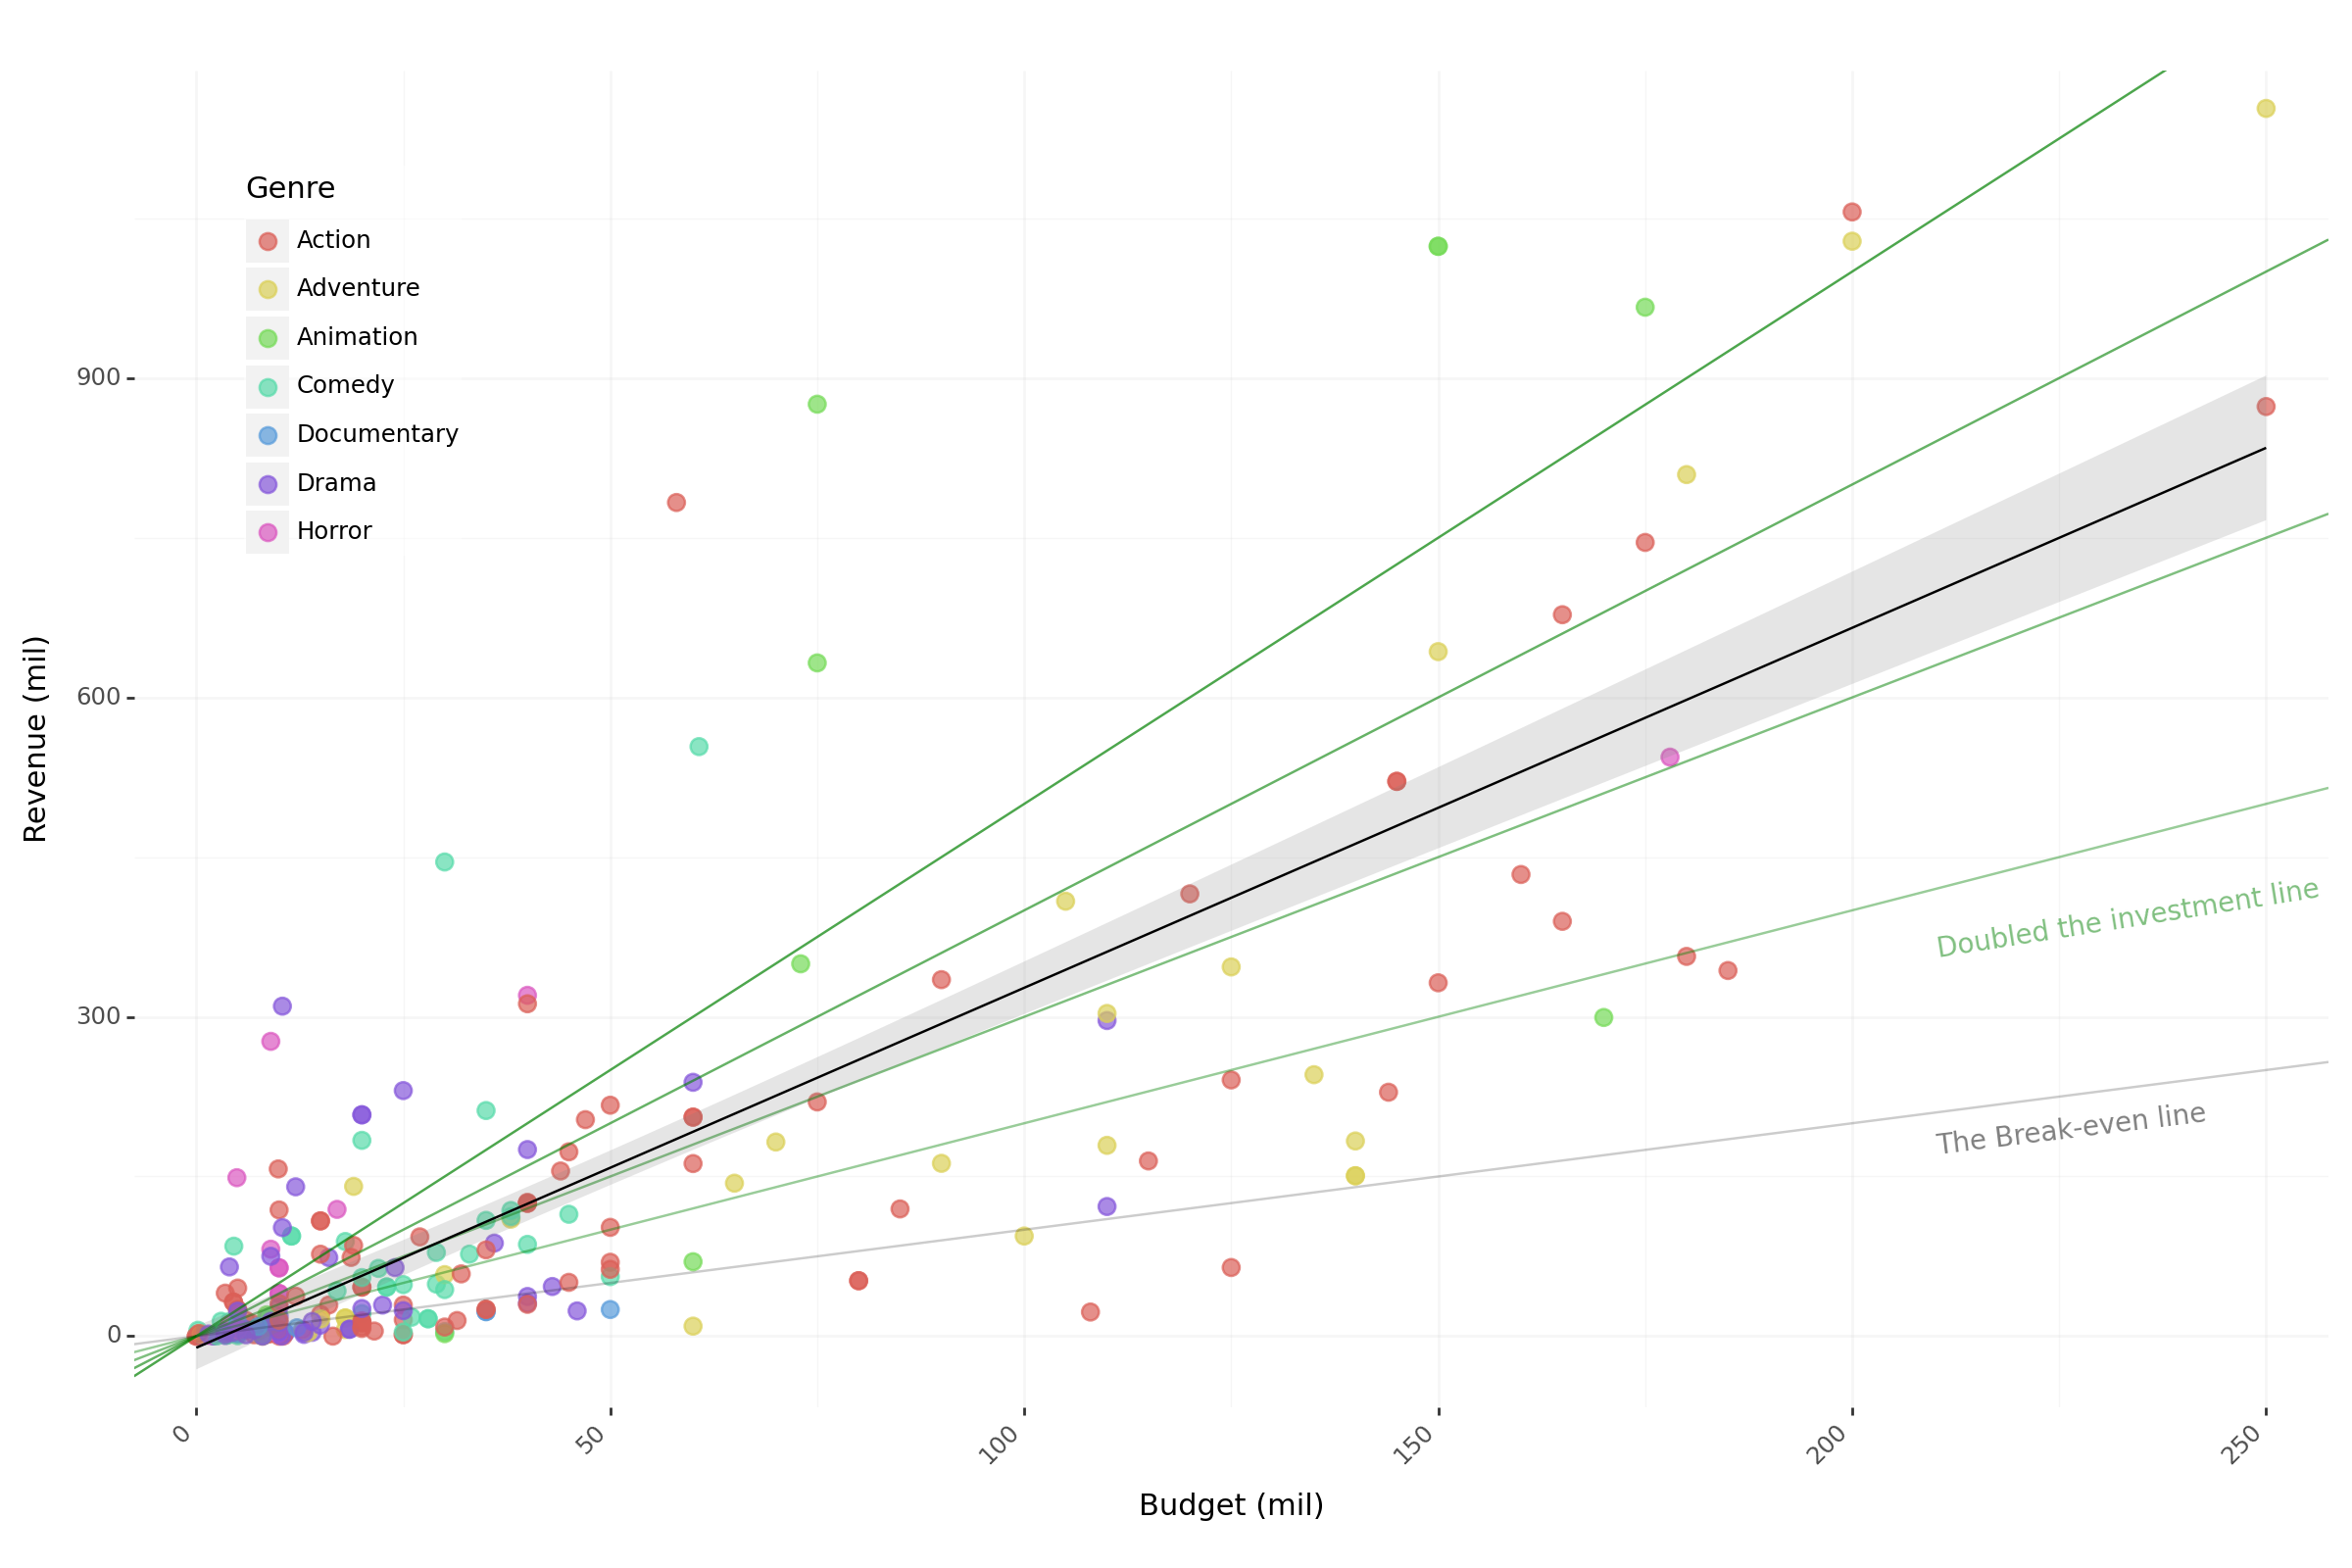

In [140]:
# We visualize the revenue and budget of all the movies where we have budget data.
# On the X axis we have the budget and on the Y axis we have the revenue.
# We draw a line where the revenue is equal to the budget - this is the break even point.
# We also draw a line where the revenue is -10% of the budget - this is the loss point.
# We also draw a line where the revenue is +10% of the budget - this is the profit point.

alphas = [0.4, 0.5, 0.6, 0.7]

def revenue_lines():
    # 2x, 3x, 4x and 5x in green graient
    lines = []
    for i, alpha in enumerate(alphas):
        slope = 2 + i
        lines.append(
            p9.geom_abline(intercept=0, slope=slope, color="green", alpha=alpha)
        )
    return lines

def loss_lines():
    # 0.5x, 0.6x, 0.7x and 0.8x in red graient
    lines = []
    for i, alpha in enumerate(reversed(alphas)):
        lines.append(
            p9.geom_abline(intercept=0, slope=0.5 + i * 0.1, color="red", alpha=alpha)
        )
    return lines


df_budgets = df_main[df_main["budget"] > 0]
df_budgets = df_budgets[df_budgets["revenue"] > 0]
df_budgets = df_budgets[df_budgets["release_year"] == 2016]


df_budgets["budget_mil"] = df_budgets["budget"] / 1000000
df_budgets["revenue_mil"] = df_budgets["revenue"] / 1000000
df_budgets["profit"] = df_budgets["revenue_mil"] - df_budgets["budget_mil"]
p = (
    #  color by main genre
    p9.ggplot(df_budgets, p9.aes(x="budget_mil", y="revenue_mil", color="main_genre"))
    + p9.geom_point(size=3, alpha=0.7)
    + p9.labs(x="Budget (mil)", y="Revenue (mil)")

    + revenue_lines()
    + p9.geom_abline(intercept=0, slope=1, color="black", alpha=0.2)
    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    + p9.scale_y_continuous(expand=(0.03, 0.03))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.15, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    # Text for the break even line
    + p9.annotate(
        "text",
        x=210,
        y=165,
        label="The Break-even line",
        color="black",
        size=10,
        alpha=0.5,
        angle=7,
        ha="left",
        va="bottom",
    )
    # Text for the 2x budget vs revenue line
    + p9.annotate(
        "text",
        x=210,
        y=350,
        label="Doubled the investment line",
        color="green",
        size=10,
        alpha=0.5,
        angle=9,
        ha="left",
        va="bottom",
    )
    # Another legend
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


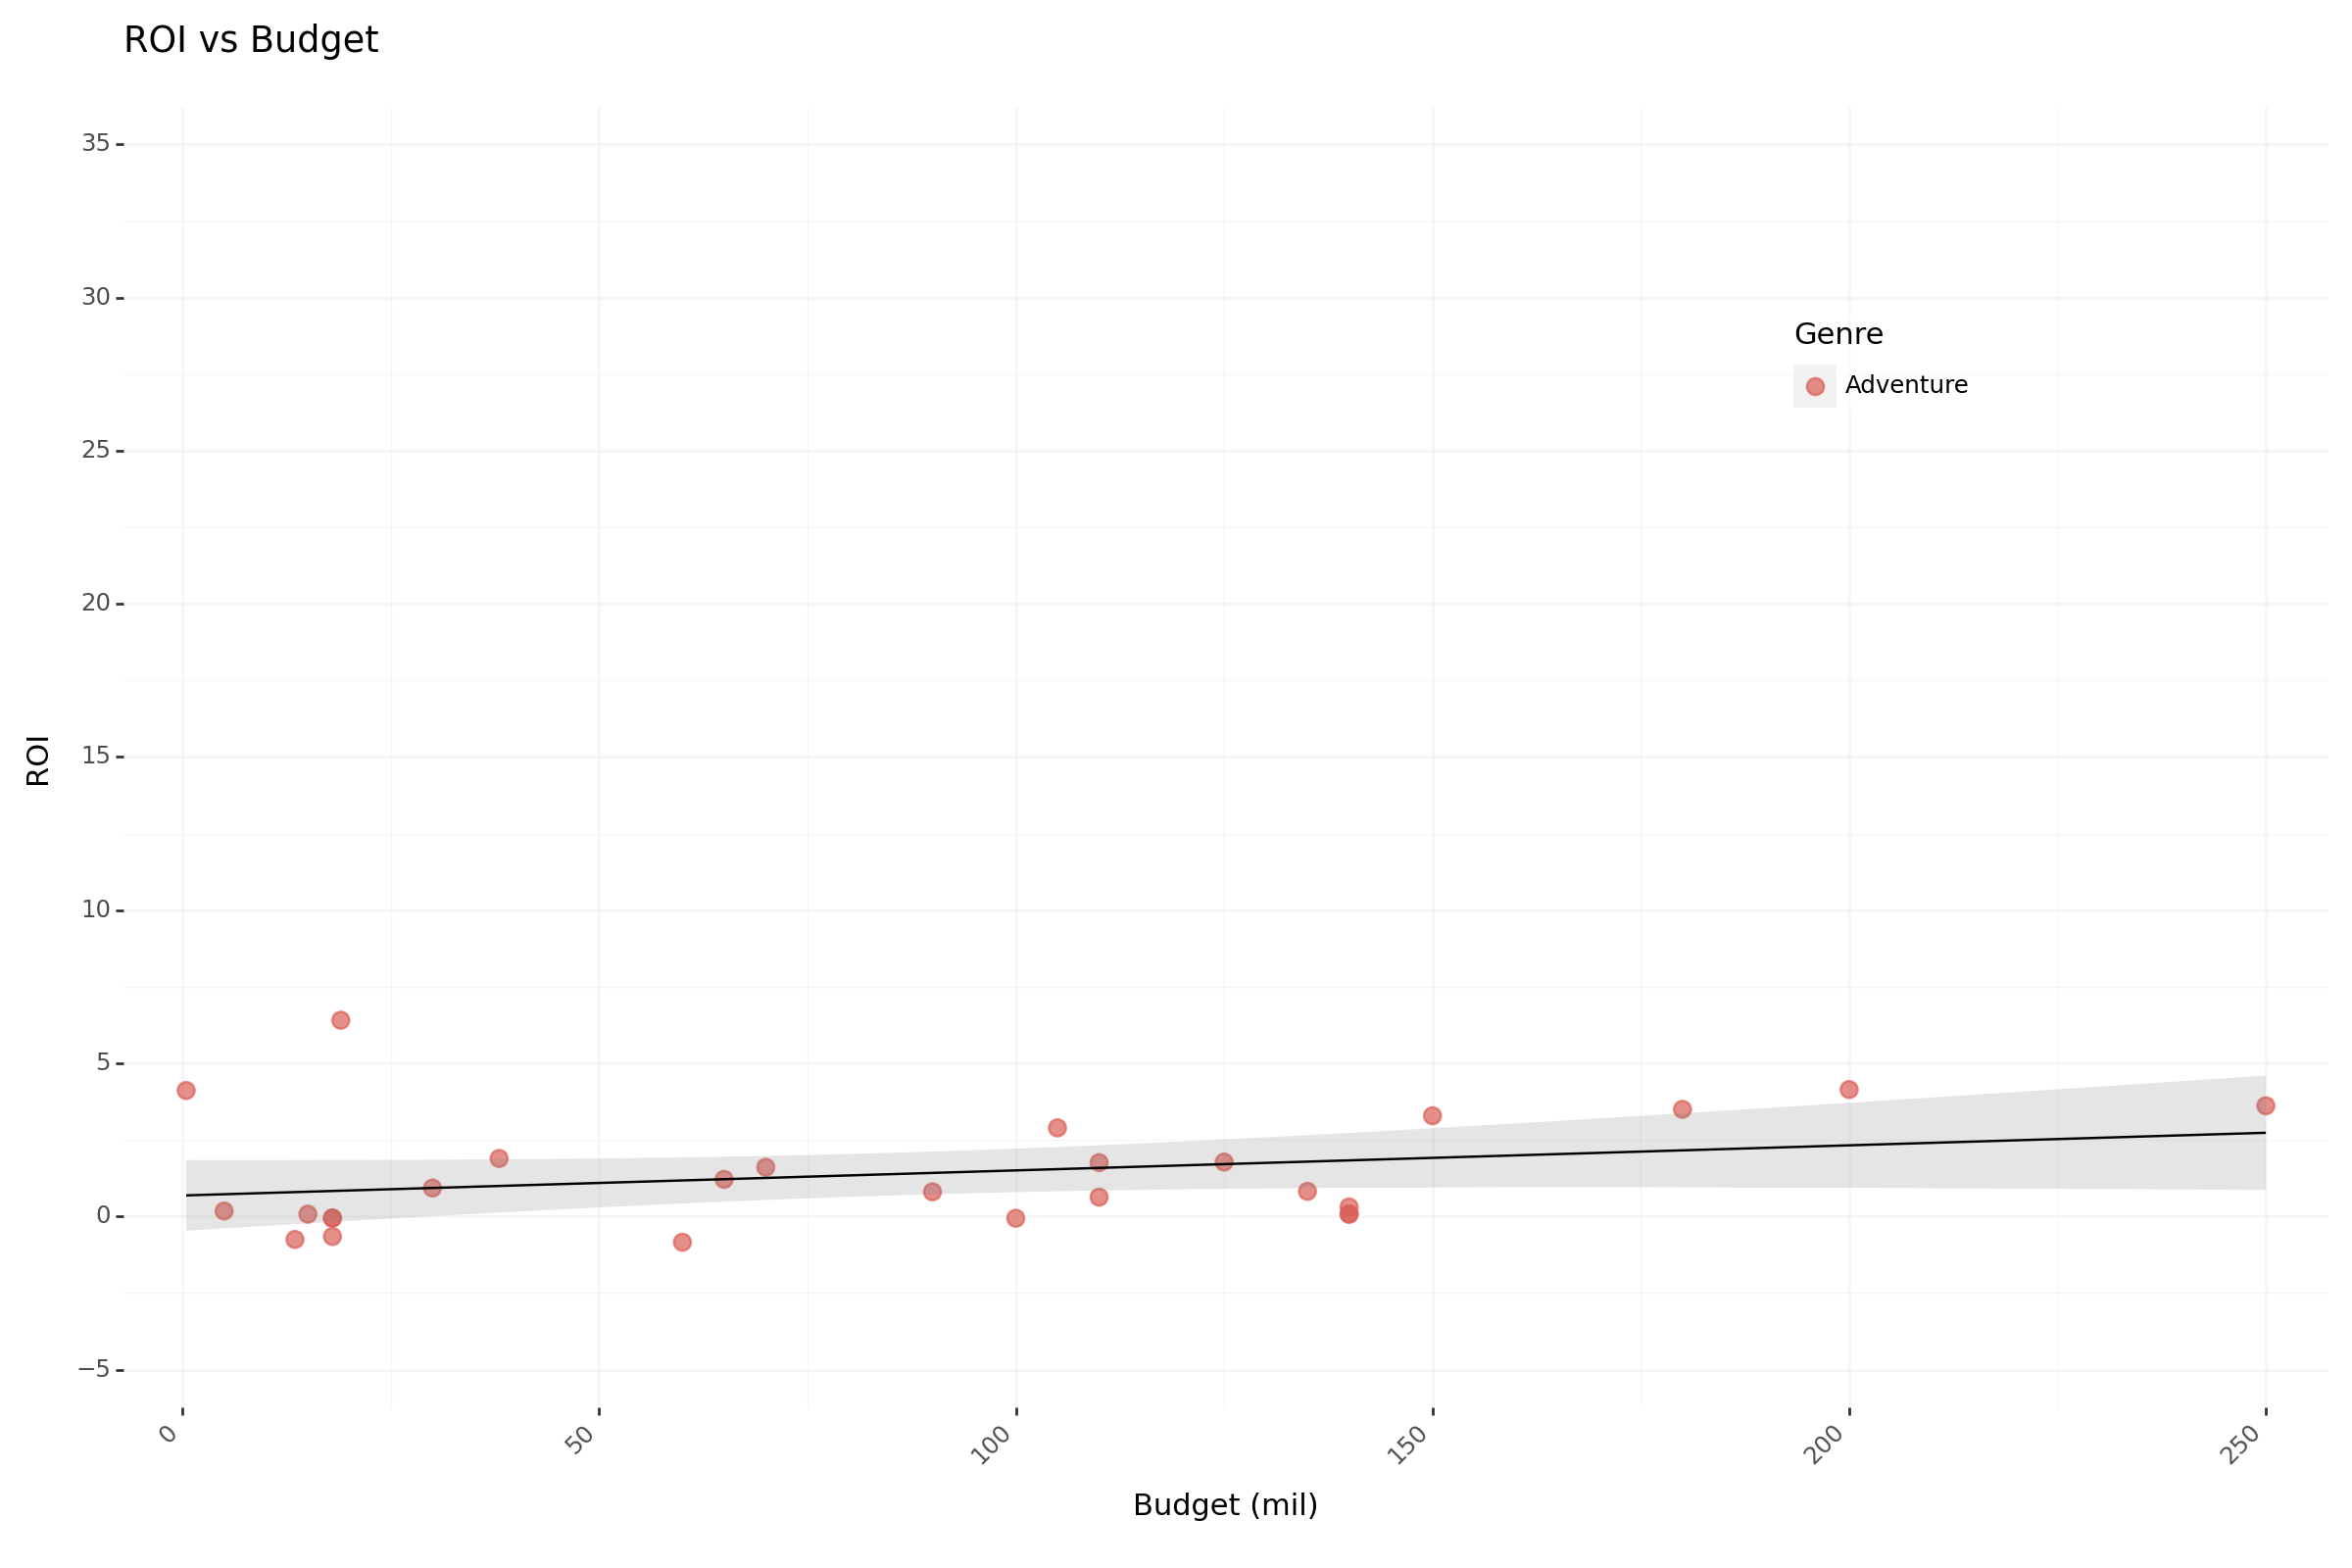

In [96]:
# We visualize the ROI of all the movies where we have budget data.
# On the X axis we have the budget and on the Y axis we have the revenue.
# We draw a line where the revenue is equal to the budget - this is the break even point.
# We also draw a line where the revenue is -10% of the budget - this is the loss point.
# We also draw a line where the revenue is +10% of the budget - this is the profit point.

df_budget_roi = df_main[df_main["budget"] > 0]
df_budget_roi = df_budget_roi[df_budget_roi["revenue"] > 0]
df_budget_roi = df_budget_roi[df_budget_roi["release_year"] == 2016]
# action only
df_budget_roi = df_budget_roi[df_budget_roi["main_genre"] == "Adventure"]

df_budget_roi["budget_mil"] = df_budget_roi["budget"] / 1_000_000
df_budget_roi["revenue_mil"] = df_budget_roi["revenue"] / 1_000_000
df_budget_roi["profit"] = df_budget_roi["revenue"] - df_budget_roi["budget"]
df_budget_roi["roi"] = df_budget_roi["profit"] / df_budget_roi["budget"]

p = (
    p9.ggplot(df_budget_roi, p9.aes(x="budget_mil", y="roi", color="main_genre", size="popularity"))
    + p9.geom_point(size=3, alpha=0.7)
    + p9.labs(x="Budget (mil)", y="ROI", title="ROI vs Budget")
    # + p9.geom_hline(yintercept=0, color="black", alpha=0.2)
    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    + p9.scale_y_continuous(expand=(0.03, 0.03), limits=(-5, 35), breaks=range(-5, 36, 5))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.8, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    # Another legend
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


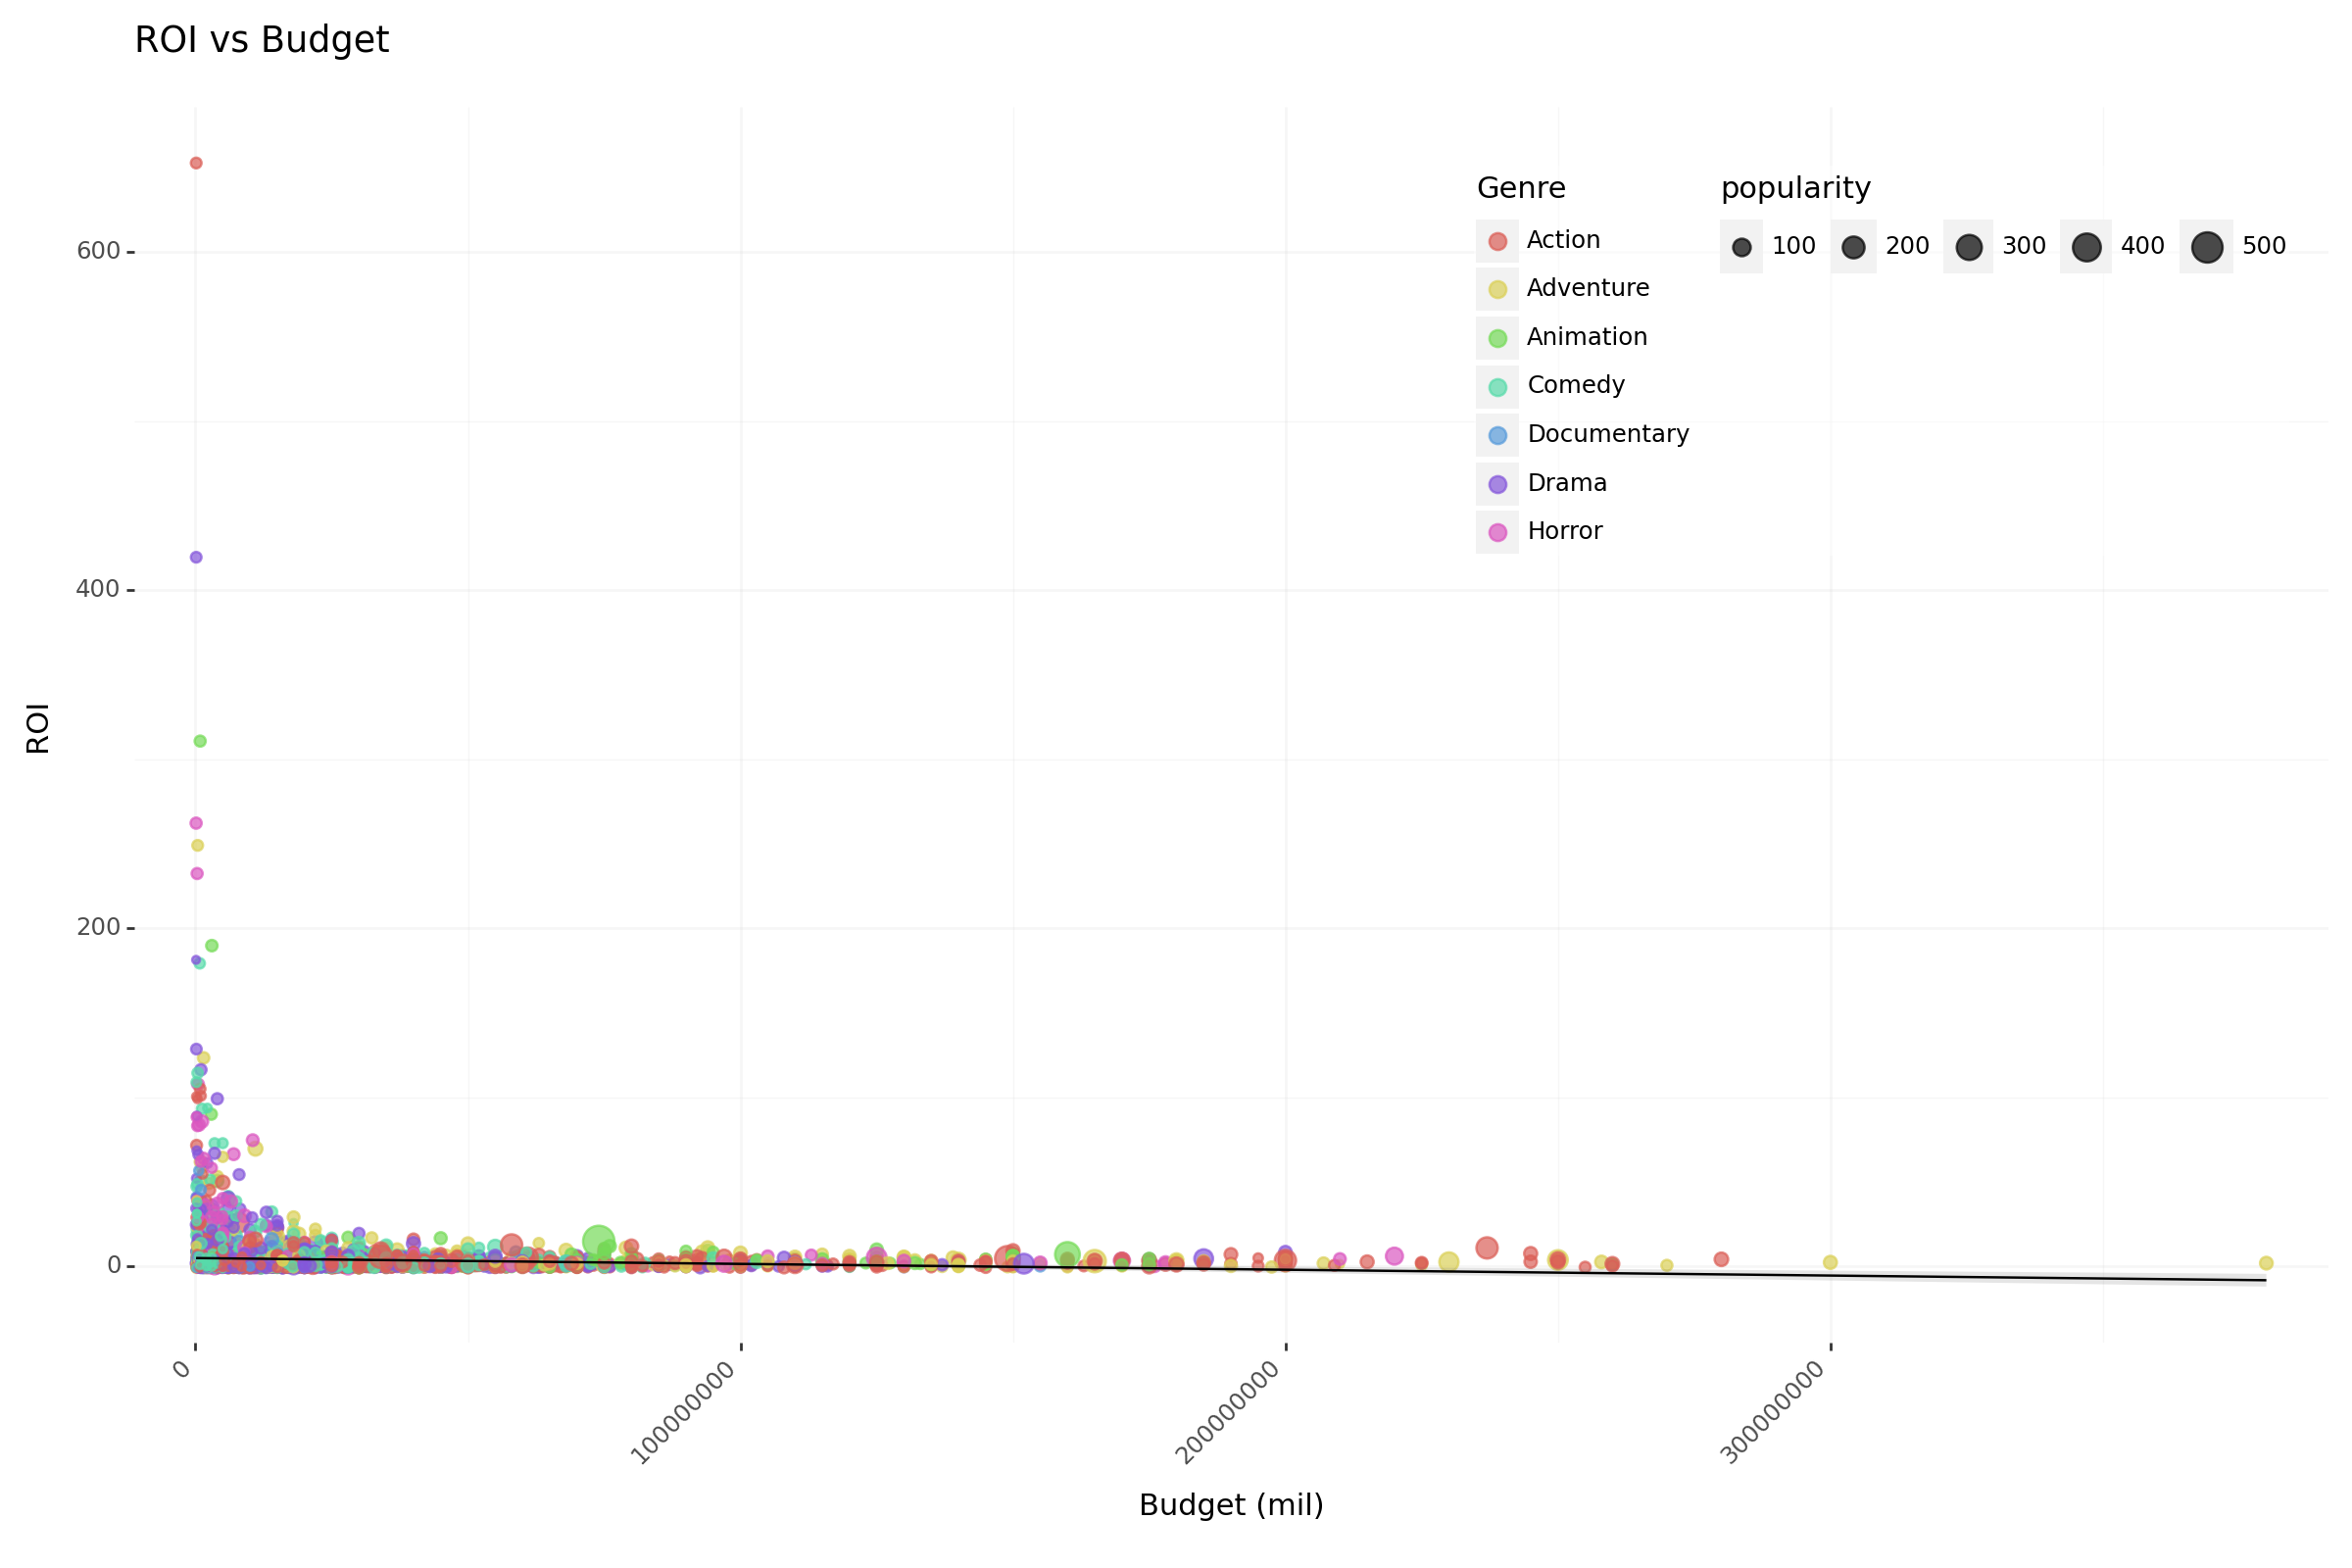

In [99]:
# We visualize the ROI of all the movies where we have budget data.
# On the X axis we have the budget and on the Y axis we have the revenue.
# The size of the points is the popularity of the movie.

df_budget_roi = df_main[df_main["budget"] > 100_000]
df_budget_roi = df_budget_roi[df_budget_roi["revenue"] > 0]
# df_budget_roi = df_budget_roi[df_budget_roi["release_year"].isin([2015, 2016])]

df_budget_roi["budget_mil"] = df_budget_roi["budget"] / 1_000_000
df_budget_roi["revenue_mil"] = df_budget_roi["revenue"] / 1_000_000
df_budget_roi["profit"] = df_budget_roi["revenue"] - df_budget_roi["budget"]
df_budget_roi["roi"] = (df_budget_roi["revenue"] - df_budget_roi["budget"]) / df_budget_roi["budget"]

# action and horror only
# df_budget_roi = df_budget_roi[df_budget_roi["main_genre"].isin(["Adventure"])]


p = (
    p9.ggplot(df_budget_roi, p9.aes(x="budget", y="roi", color="main_genre", size="popularity"))
    + p9.geom_point(alpha=0.7)
    + p9.labs(x="Budget (mil)", y="ROI", title="ROI vs Budget")
    # + p9.geom_hline(yintercept=0, color="black", alpha=0.2)
    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    # + p9.scale_y_continuous(expand=(0.03, 0.03), limits=(-5, 35), breaks=range(-5, 36, 5))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.8, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


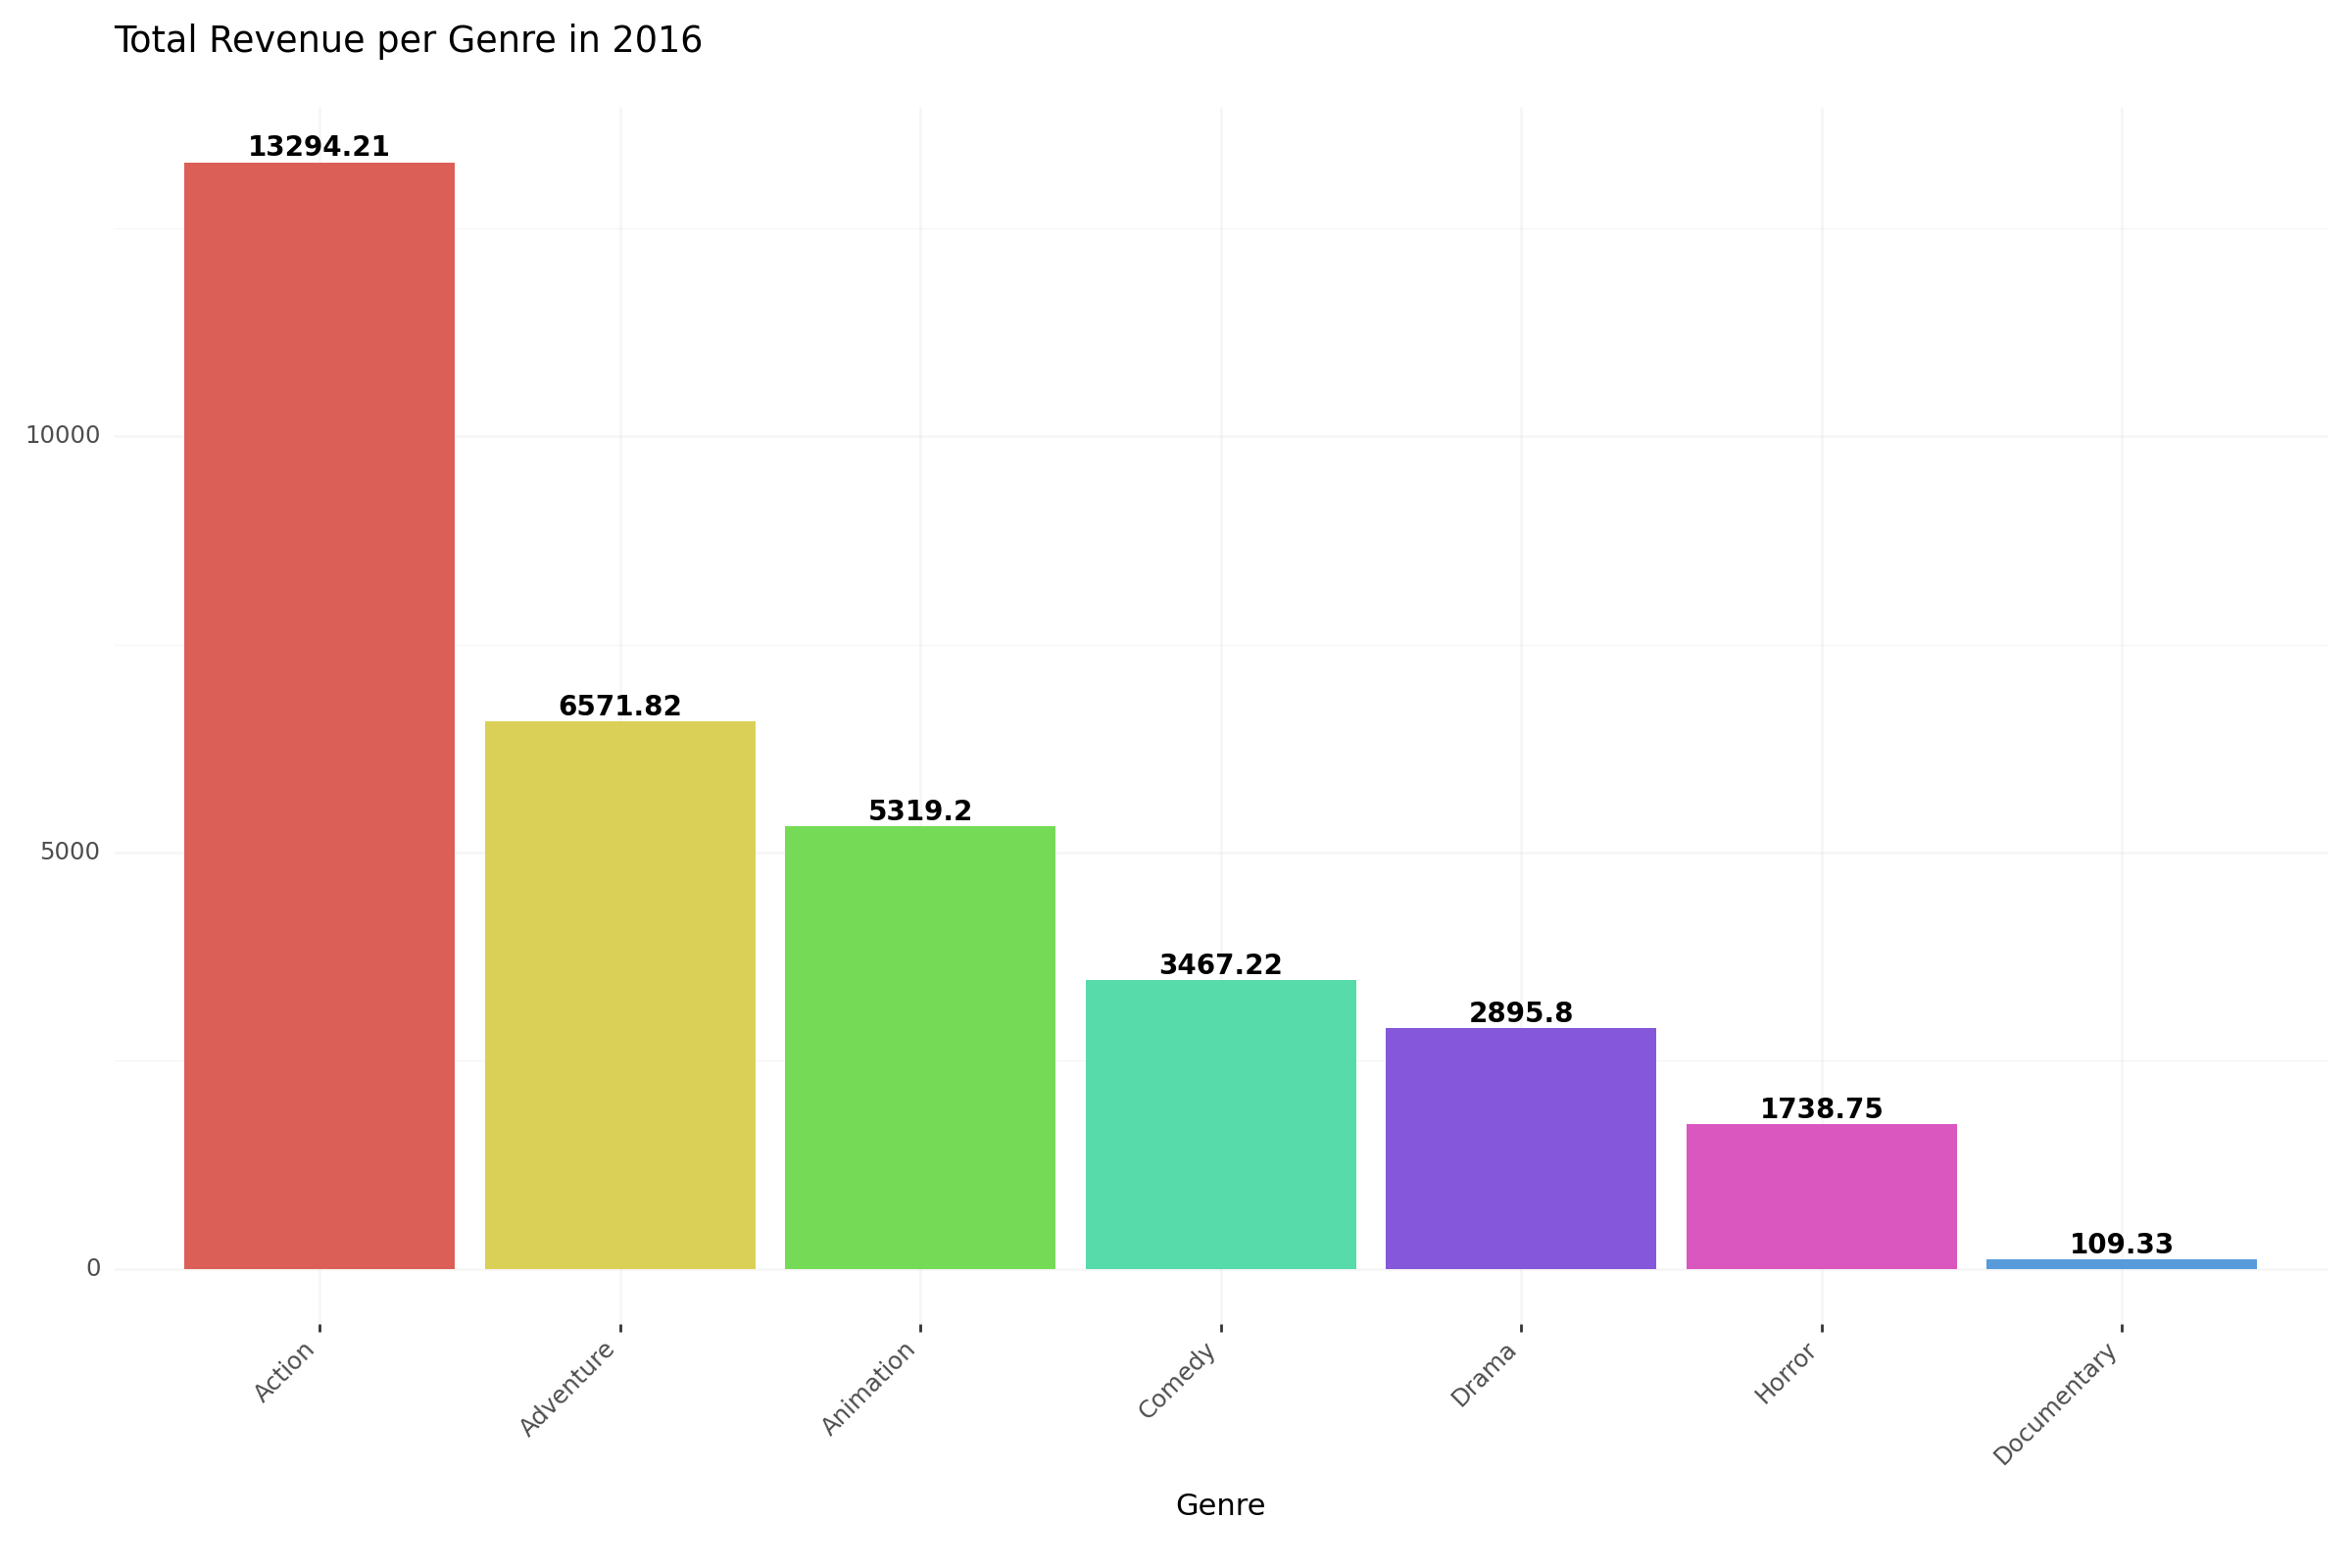

In [47]:
# Bar plot of the total revenue per genre in 2016
# Color the bars by the main genre as in the previous plot
# Remove the Y axis and instead add a label on top of each bar with the revenue value

df_revenue = df_main[df_main["revenue"] > 0]
df_revenue = df_revenue[df_revenue["release_year"] == 2016]
df_revenue = df_revenue.groupby("main_genre").agg({"revenue": "sum"}).reset_index()
df_revenue["revenue_mil"] = df_revenue["revenue"] / 1000000
# round to 2 decimals
df_revenue["revenue_mil"] = df_revenue["revenue_mil"].apply(lambda x: round(x, 2))

p = (
    # order by revenue
    p9.ggplot(df_revenue, p9.aes(x="reorder(main_genre, -revenue_mil)", y="revenue_mil", fill="main_genre"))
    + p9.geom_col()
    + p9.labs(x="Genre", y="Revenue (mil)", title="Total Revenue per Genre in 2016")
    + p9.scale_x_discrete(expand=(0.03, 0.03))
    # add a label on top of each bar
    + p9.geom_text(
        p9.aes(label="revenue_mil"),
        fontweight="bold",
        va="bottom",
        nudge_y=1,
        size=10,
    )
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position="none",
        axis_line_y=p9.element_blank(),
        axis_ticks_major_y=p9.element_blank(),
        axis_ticks_minor_y=p9.element_blank(),
        axis_title_y=p9.element_blank(),


    )
)

p.draw()


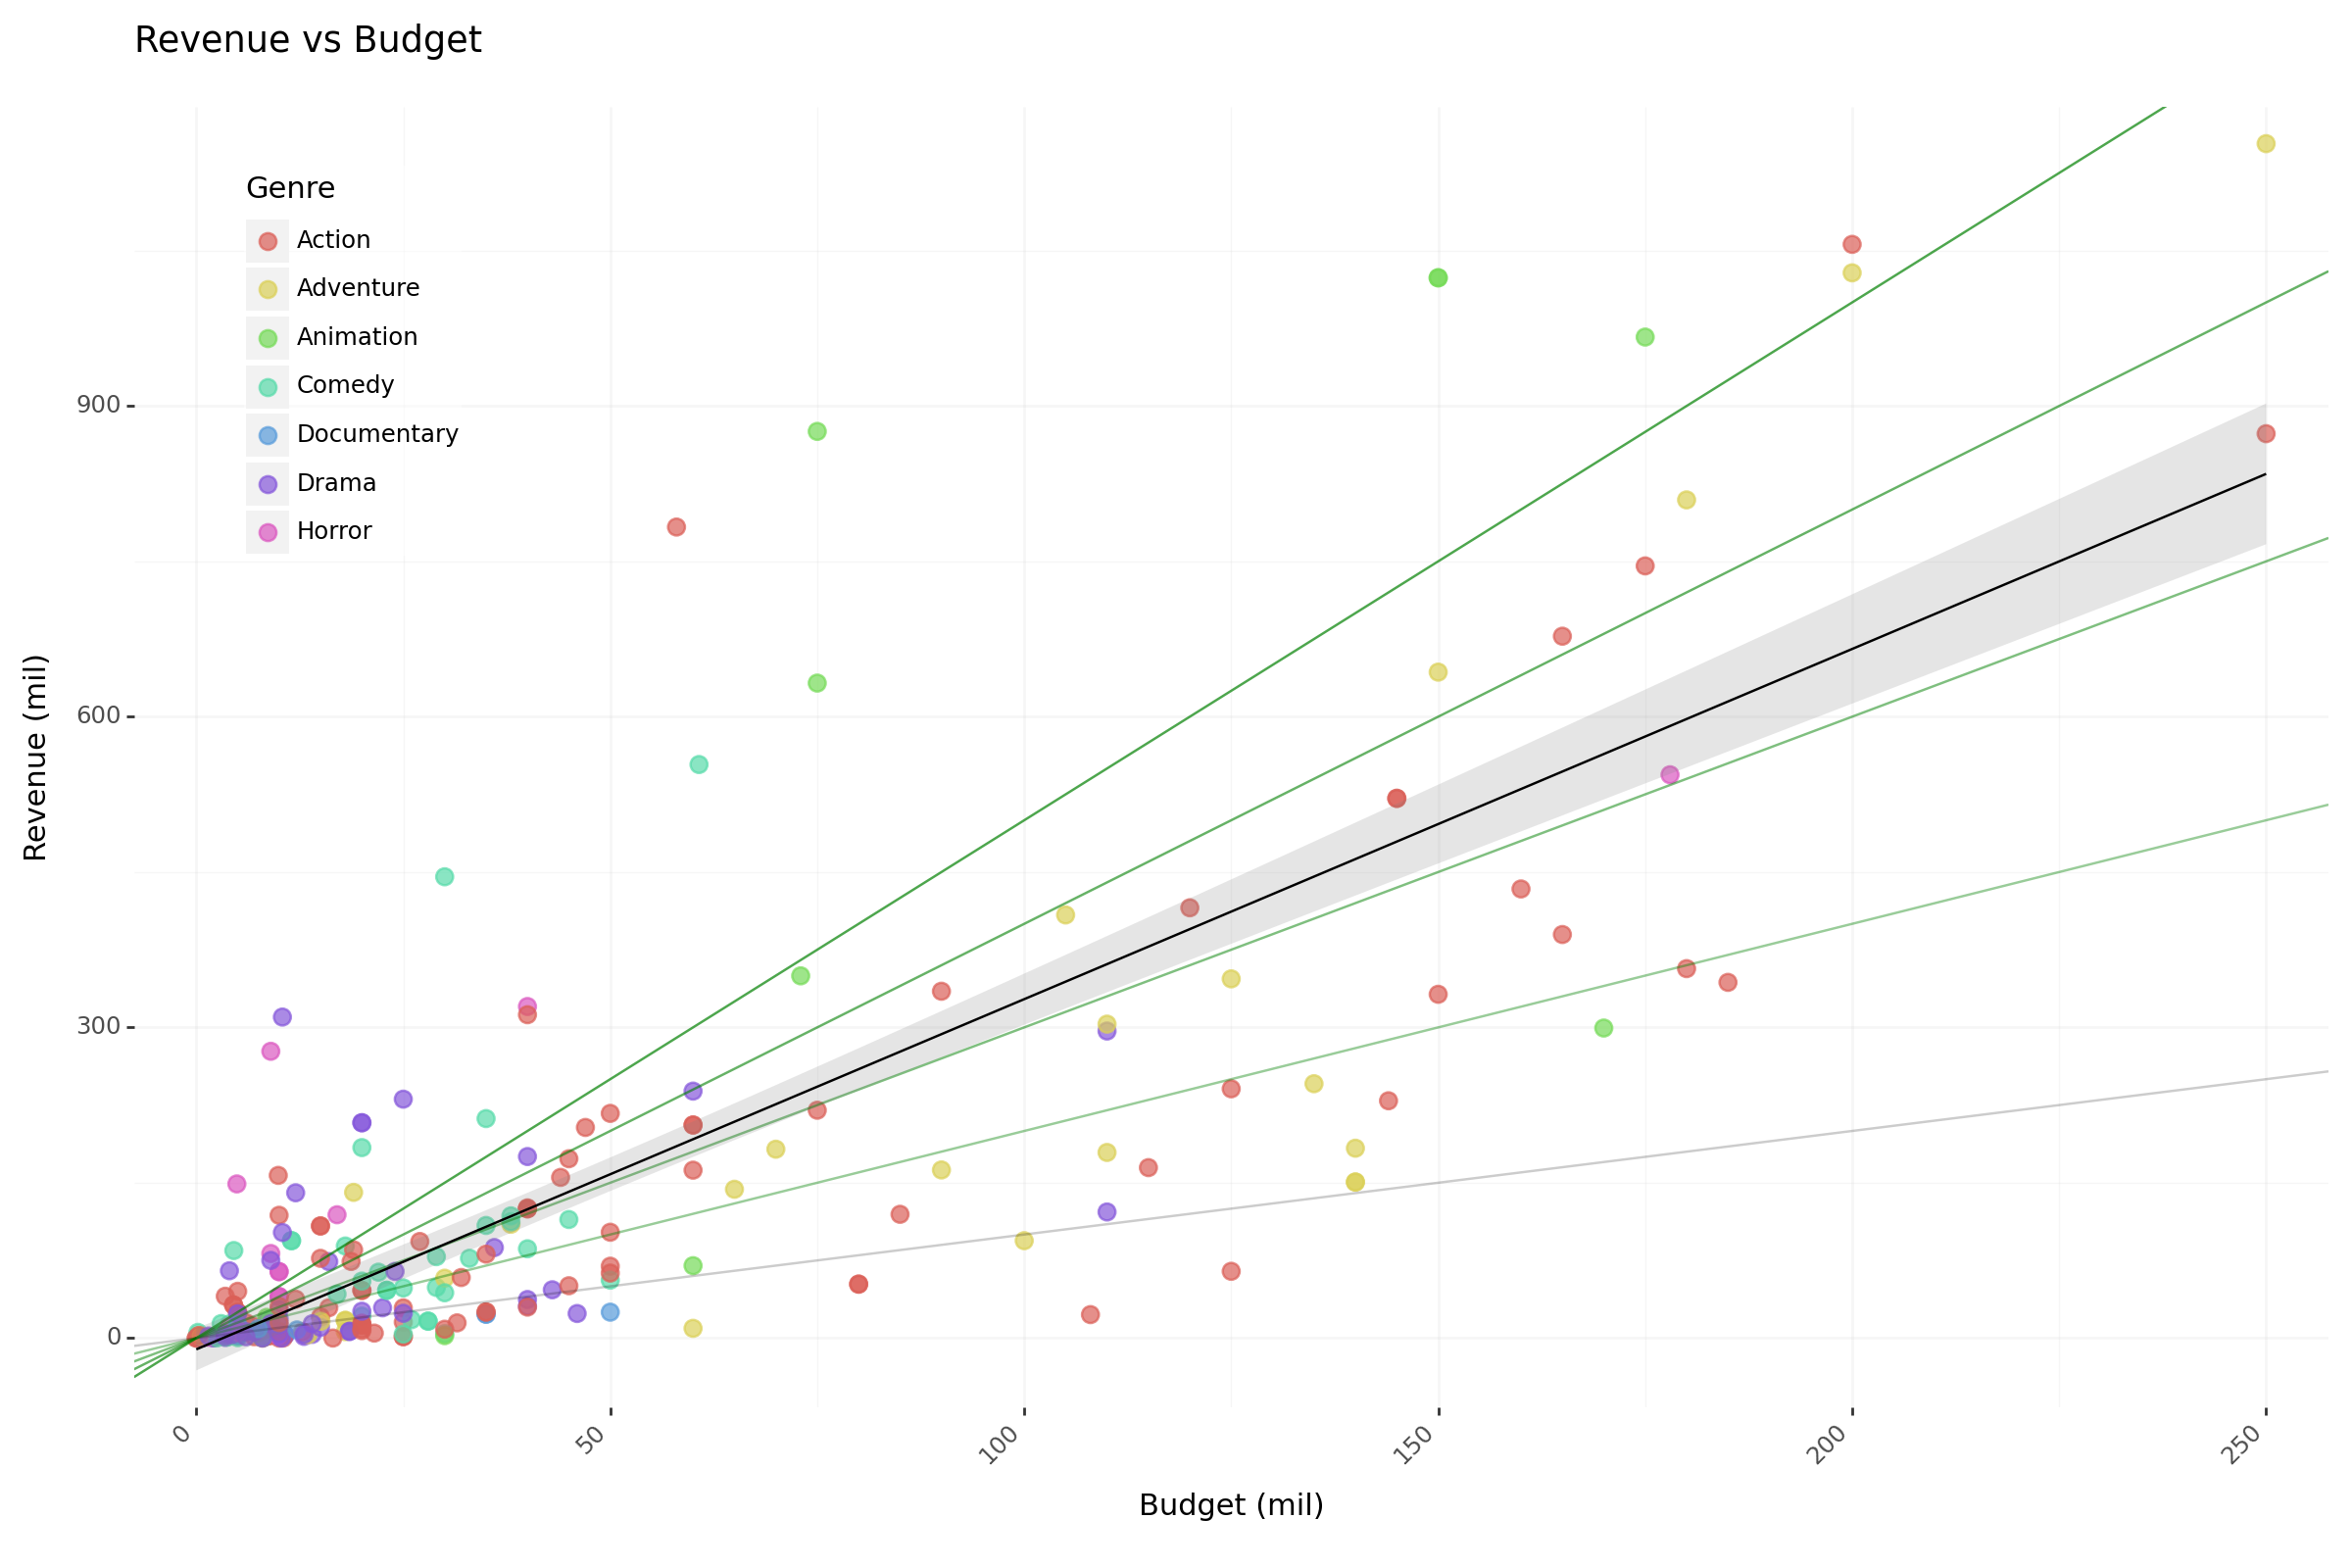

In [216]:
# We visualize the revenue and budget of all the movies where we have budget data.
# On the X axis we have the budget and on the Y axis we have the revenue.
# We draw a line where the revenue is equal to the budget - this is the break even point.
# We also draw a line where the revenue is -10% of the budget - this is the loss point.
# We also draw a line where the revenue is +10% of the budget - this is the profit point.

alphas = [0.4, 0.5, 0.6, 0.7]

def revenue_lines():
    # 2x, 3x, 4x and 5x in green graient
    lines = []
    for i, alpha in enumerate(alphas):
        slope = 2 + i
        lines.append(
            p9.geom_abline(intercept=0, slope=slope, color="green", alpha=alpha)
        )
    return lines

def loss_lines():
    # 0.5x, 0.6x, 0.7x and 0.8x in red graient
    lines = []
    for i, alpha in enumerate(reversed(alphas)):
        lines.append(
            p9.geom_abline(intercept=0, slope=0.5 + i * 0.1, color="red", alpha=alpha)
        )
    return lines


df_budgets = df_main[df_main["budget"] > 0]
df_budgets = df_budgets[df_budgets["revenue"] > 0]
df_budgets = df_budgets[df_budgets["release_year"] == 2016]


df_budgets["budget_mil"] = df_budgets["budget"] / 1000000
df_budgets["revenue_mil"] = df_budgets["revenue"] / 1000000
df_budgets["profit"] = df_budgets["revenue_mil"] - df_budgets["budget_mil"]
p = (
    #  color by main genre
    p9.ggplot(df_budgets, p9.aes(x="budget_mil", y="revenue_mil", color="main_genre"))
    + p9.geom_point(size=3, alpha=0.7)
    + p9.labs(x="Budget (mil)", y="Revenue (mil)", title="Revenue vs Budget")

    + revenue_lines()
    + p9.geom_abline(intercept=0, slope=1, color="black", alpha=0.2)
    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    + p9.scale_y_continuous(expand=(0.03, 0.03))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.15, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    # Another legend
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


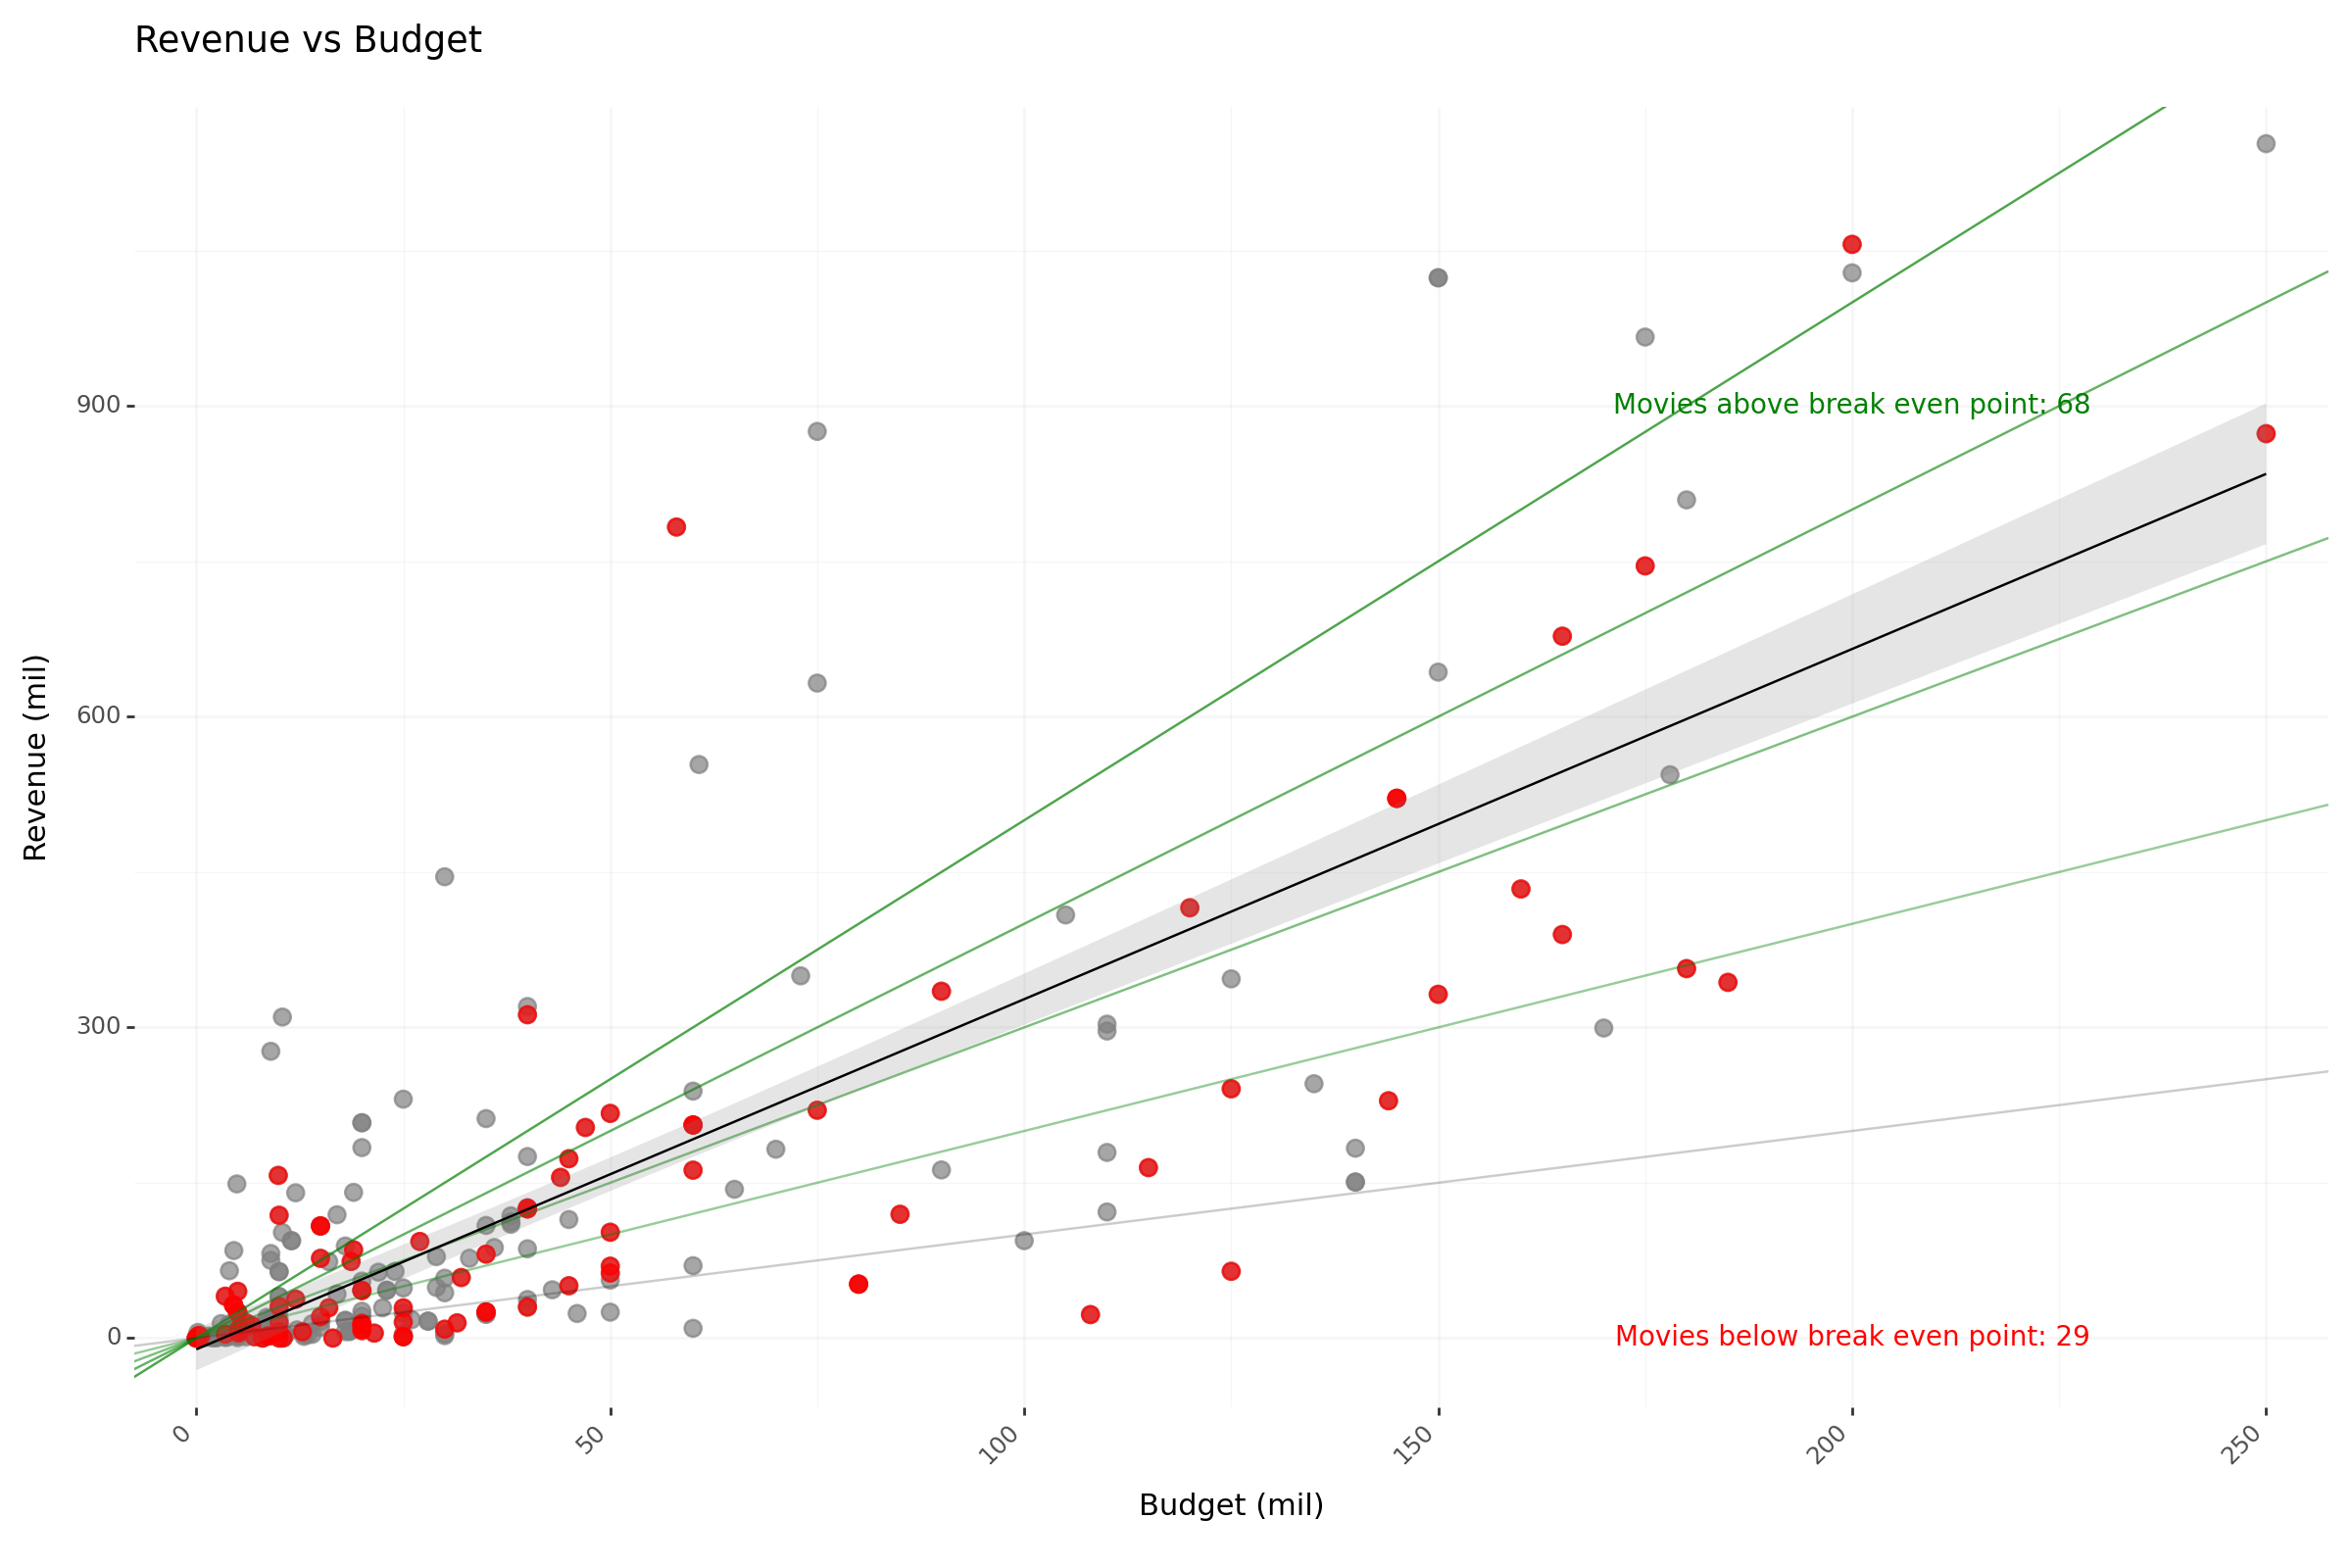

In [224]:
# The same plot as above but we only color the action movies in red and the rest in gray

df_budgets = df_main[df_main["budget"] > 0]
df_budgets = df_budgets[df_budgets["revenue"] > 0]
df_budgets = df_budgets[df_budgets["release_year"] == 2016]


df_budgets["budget_mil"] = df_budgets["budget"] / 1000000
df_budgets["revenue_mil"] = df_budgets["revenue"] / 1000000
df_budgets["profit"] = df_budgets["revenue_mil"] - df_budgets["budget_mil"]

action_movie_below_break_even = df_budgets[
    (df_budgets["main_genre"] == "Action") & (df_budgets["profit"] < 0)
]
action_movie_above_break_even = df_budgets[
    (df_budgets["main_genre"] == "Action") & (df_budgets["profit"] >= 0)
]

p = (
    #  color everything in gray first
    p9.ggplot(df_budgets, p9.aes(x="budget_mil", y="revenue_mil"))
    # Highilght the action movies in red
    + p9.geom_point(size=3, alpha=0.7, color="gray")

    # color action movies in red
    + p9.geom_point(
        df_budgets[df_budgets["main_genre"] == "Action"],
        p9.aes(x="budget_mil", y="revenue_mil"),
        size=3,
        alpha=0.7,
        color="red",
    )
    + p9.labs(x="Budget (mil)", y="Revenue (mil)", title="Revenue vs Budget")

    + revenue_lines()
    # display the break even point
    + p9.geom_abline(intercept=0, slope=1, color="black", alpha=0.2)

    # display the count of movies above and below the break even point
    + p9.annotate(
        "text",
        x=200,
        y=900,
        label=f"Movies above break even point: {len(action_movie_above_break_even)}",
        color="green",
        size=10,
    )
    + p9.annotate(
        "text",
        x=200,

        y=0,
        label=f"Movies below break even point: {len(action_movie_below_break_even)}",
        color="red",
        size=10,
    )

    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    + p9.scale_y_continuous(expand=(0.03, 0.03))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.15, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    # Another legend
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


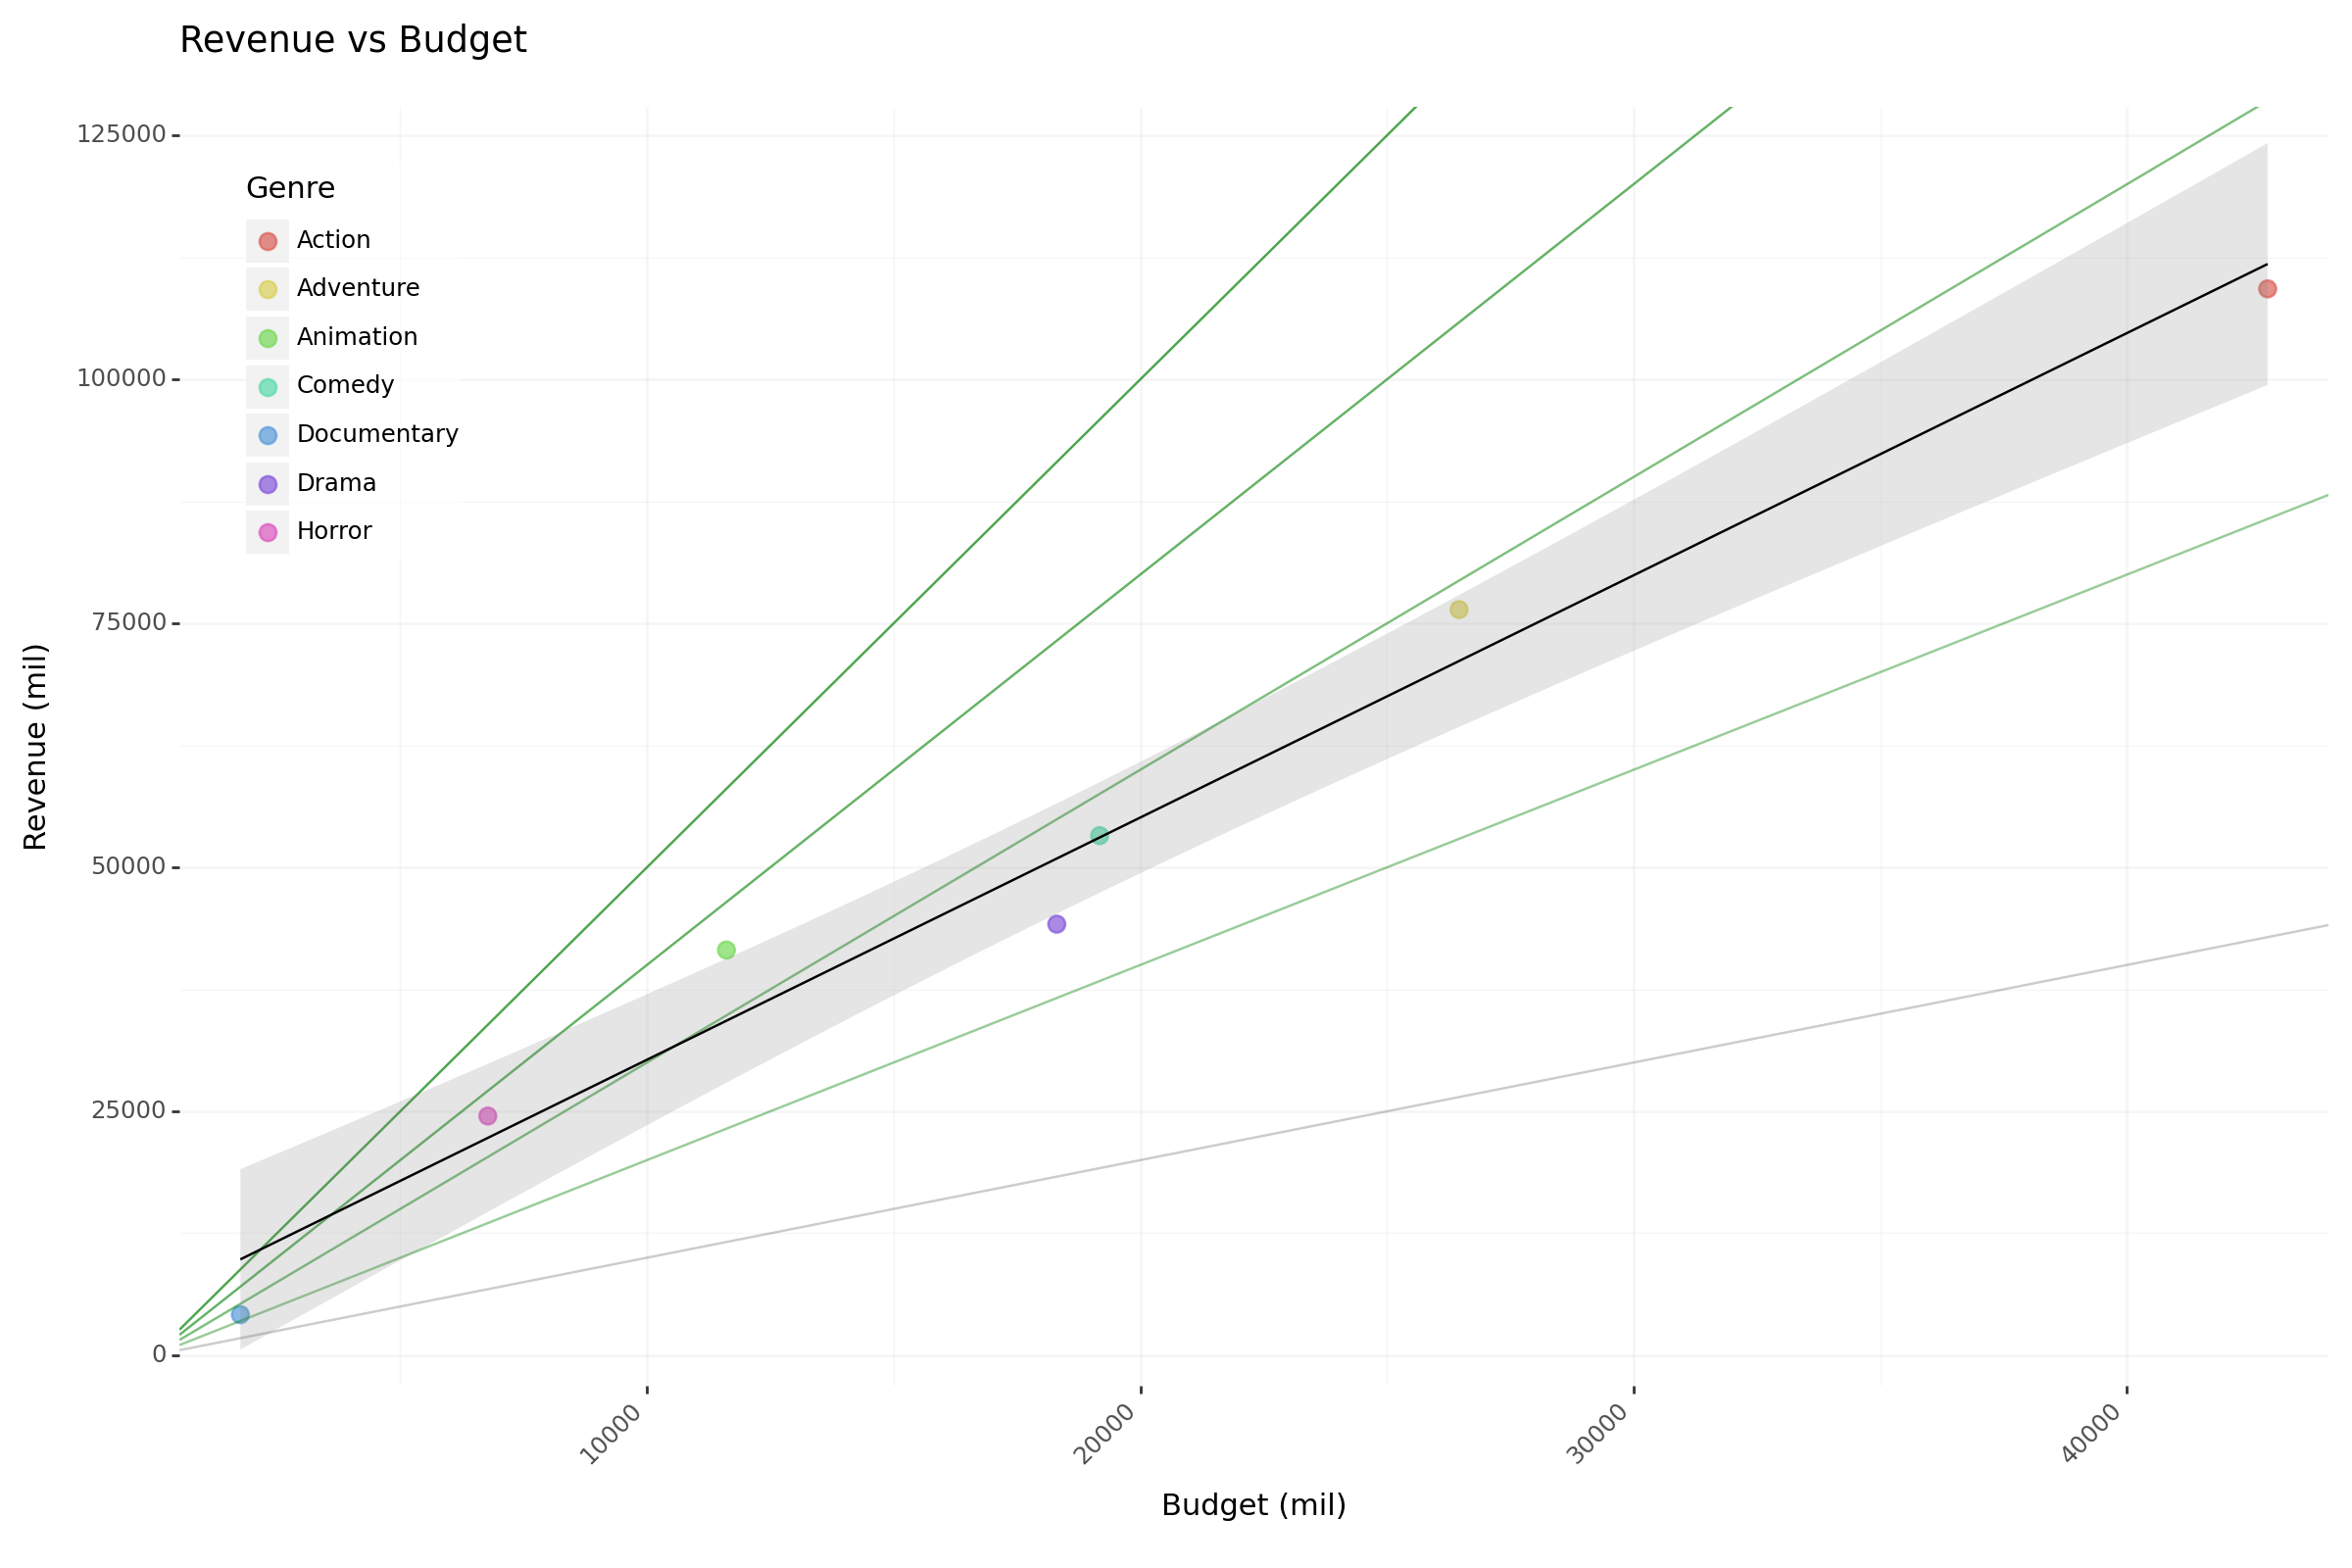

In [214]:
# The same plot from before, but now we group all the movies by the main_genre.

df_budgets = df_main[df_main["budget"] > 0]
df_budgets = df_budgets[df_budgets["revenue"] > 0]
# df_budgets = df_budgets[df_budgets["release_year"] == 2016]

# group by main_genre
df_budgets = df_budgets.groupby("main_genre").agg({"budget": "sum", "revenue": "sum"}).reset_index()
df_budgets["profit"] = df_budgets["revenue"] - df_budgets["budget"]

df_budgets["budget_mil"] = df_budgets["budget"] / 1000000
df_budgets["revenue_mil"] = df_budgets["revenue"] / 1000000
df_budgets["profit_mil"] = df_budgets["profit"] / 1000000

p = (
    # order by revenue
    p9.ggplot(df_budgets, p9.aes(x="budget_mil", y="revenue_mil", color="main_genre"))
    + p9.geom_point(size=3, alpha=0.7)
    + p9.labs(x="Budget (mil)", y="Revenue (mil)", title="Revenue vs Budget")

    + revenue_lines()
    + p9.geom_abline(intercept=0, slope=1, color="black", alpha=0.2)
    + p9.geom_smooth(method="lm", se=True, color="black", fill="gray", alpha=0.2, size=0.5)
    + p9.scale_x_continuous(expand=(0.03, 0.03))
    + p9.scale_y_continuous(expand=(0.03, 0.03))
    + p9.theme(
        figure_size=(12, 8),
        axis_text_x=p9.element_text(angle=45, hjust=1),
        axis_text_y=p9.element_text(angle=0, hjust=1),
        panel_grid=p9.element_line(color="lightgray", alpha=0.2),
        panel_background=p9.element_rect(fill="white"),
        legend_position=(0.15, 0.77),
        legend_margin=0.5,
        legend_background=p9.element_rect(fill="white", alpha=0.5),
    )
    # Another legend
    + p9.guides(
        color=p9.guide_legend(
            title="Genre",
            ncol=1,
            override_aes={
                "size": 3,
            },
        ),
    )
)

p.draw()


In [12]:
# Number of movies per main genre

df_main_genre_count = (
    df_main.groupby("main_genre")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

df_main_genre_count


main_genre  count
5        Drama   2816
3       Comedy   2303
0       Action   1947
4  Documentary   1601
6       Horror    869
2    Animation    573
1    Adventure    390

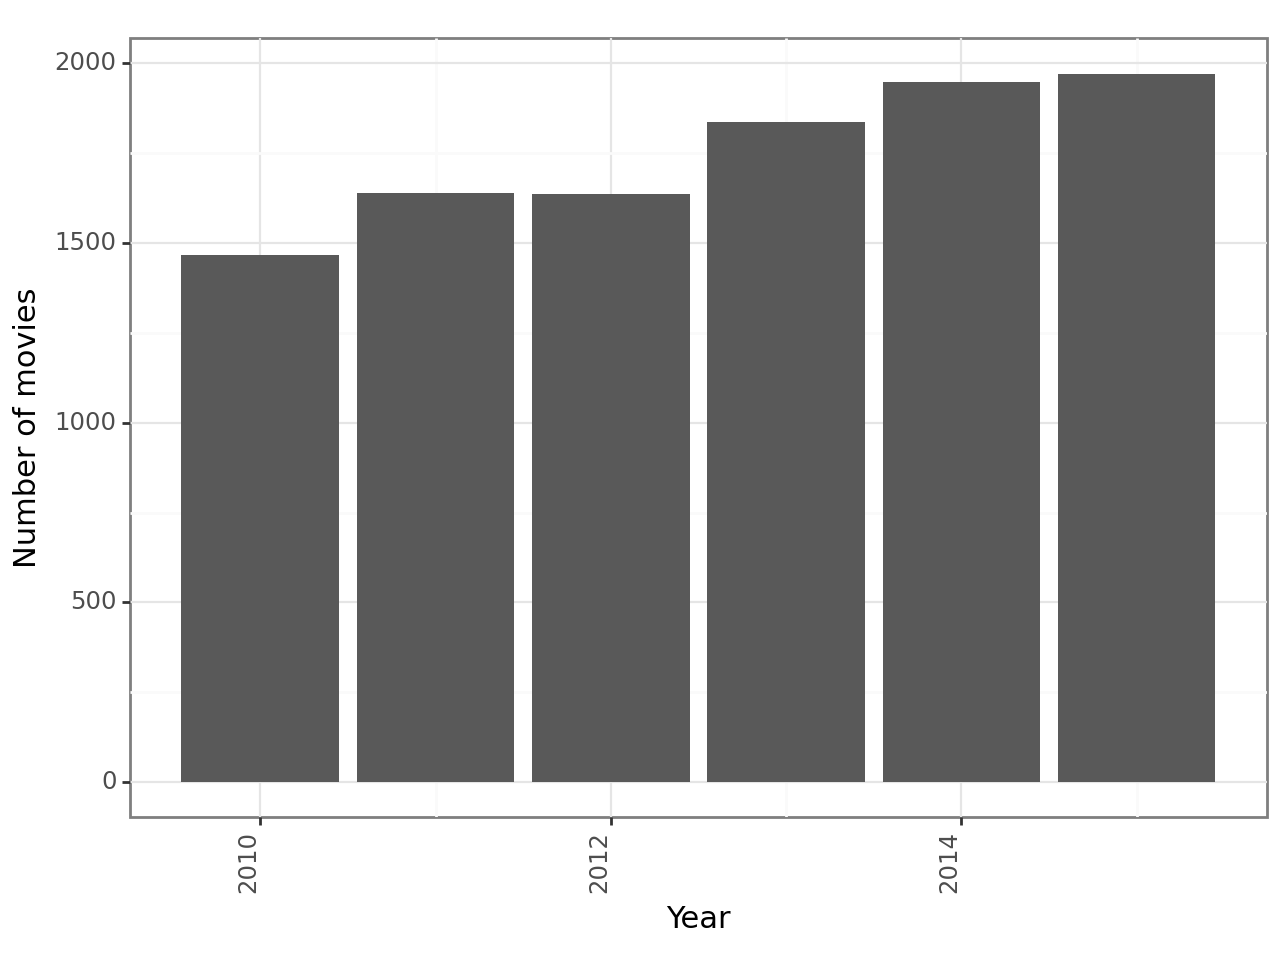

In [13]:
# Total number of movies released per year as a bar chart
df_year = df_main.groupby("release_year").size().reset_index(name="count")

p = (
    p9.ggplot(df_year, p9.aes(x="release_year", y="count"))
    + p9.geom_bar(stat="identity")
    + p9.theme_bw()
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.labs(x="Year", y="Number of movies")
)
p.draw()


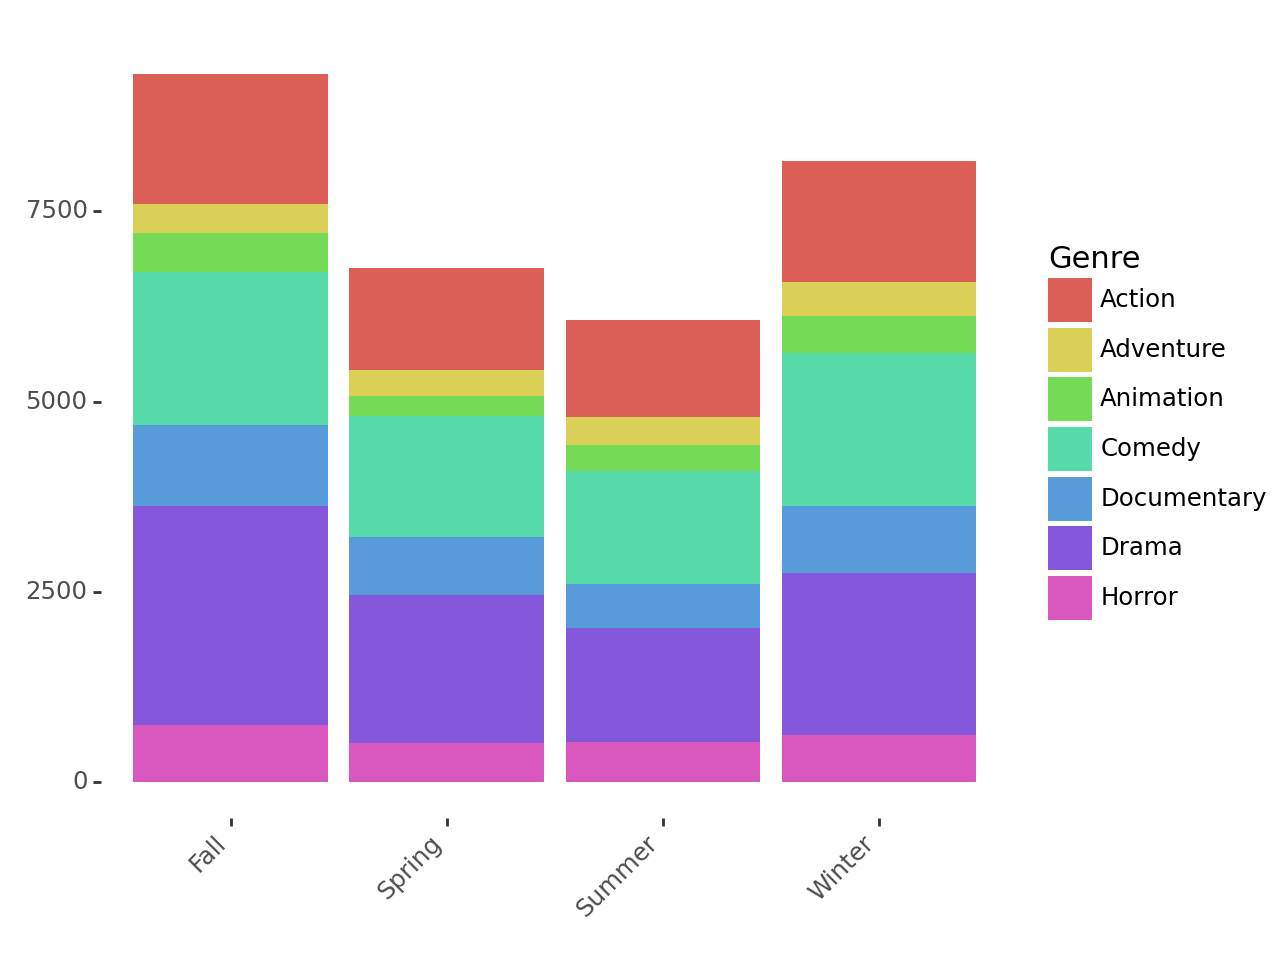

In [12]:
# Stacked bar chart with the number of movies per season and genre
# df_main["season"] = pd.Categorical(df_main["season"], ["Winter", "Spring", "Summer", "Fall"])
# df_main["main_genre"] = pd.Categorical(df_main["main_genre"], genres)

df_season_genre = (
    df_main.groupby(["season", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

# print(df_season_genre)

p = (
    p9.ggplot(df_season_genre, p9.aes(x="season", y="count", fill="main_genre"))
    + p9.geom_col(position="stack")
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    + p9.theme(panel_background=p9.element_blank())
    + p9.labs(fill="Genre")
    + p9.ylab("")
    + p9.xlab("")
    + p9.theme(panel_grid_major_y=p9.element_line(color="white", size=0.5))

    # + p9.geom_hline(yintercept=range(0, 10000, 1000), color="#ffffff", size=0.5)

)

p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


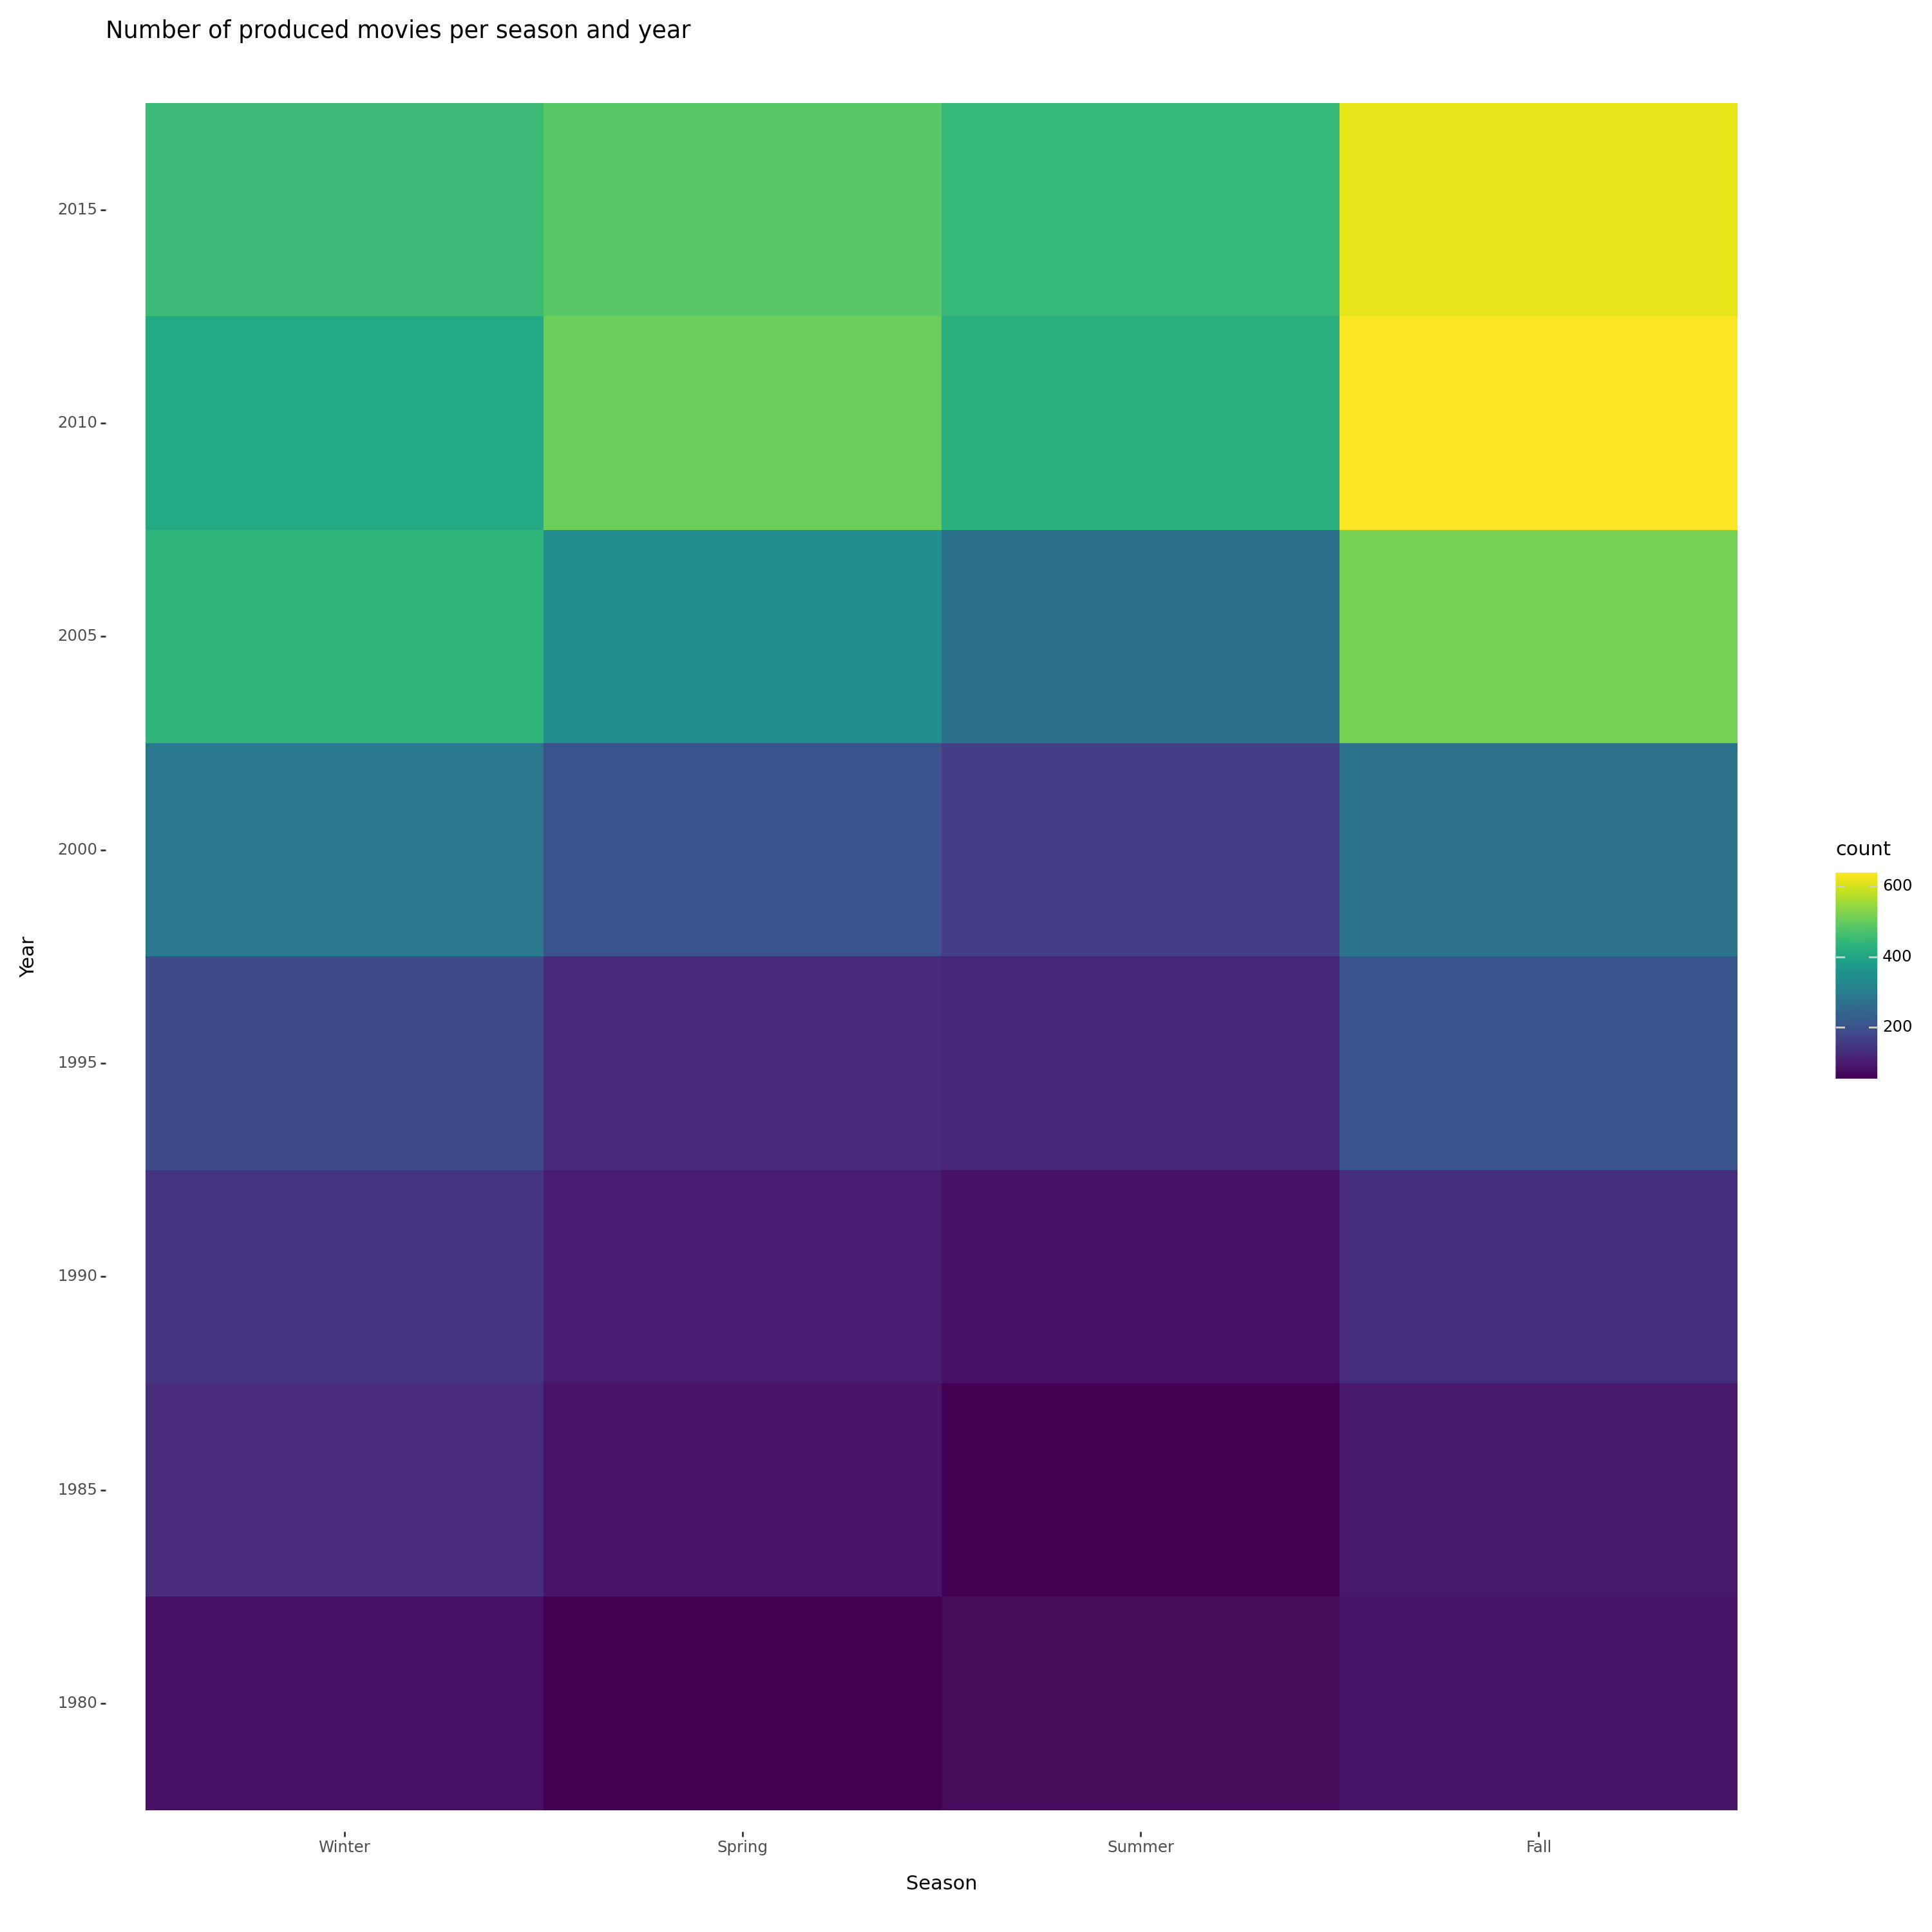

In [13]:
# Number of produced movies per season and year
df_season_count = (
    df_main.groupby(["season", "release_year"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

# reorder the seasons
df_season_count["season"] = pd.Categorical(
    df_season_count["season"], ["Winter", "Spring", "Summer", "Fall", "oli"]
)

# group by 5 years
df_season_count["release_year"] = df_season_count["release_year"].apply(
    lambda x: x - x % 5
)

# make the release_year a categorical variable
df_season_count["release_year"] = pd.Categorical(
    df_season_count["release_year"], sorted(df_season_count["release_year"].unique())
)

p = (
    p9.ggplot(
        df_season_count, p9.aes("season", "release_year", fill="count")
    )
    + p9.geom_tile()
    + p9.labs(x="Season", y="Year", title="Number of produced movies per season and year")
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    # + p9.scale_x_continuous(breaks=range(1, 13))
    # + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        # panel_grid_major=p9.element_line(color="#dfdfdf", size=5),
    )

)


# p = (
#     p9.ggplot(
#         df_season_count, p9.aes("season", "release_year", fill="count")
#     )
#     + p9.geom_tile()
#     + p9.labs(x="Season", y="Year", title="Number of produced movies per season and year")
#     + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
#     # + p9.scale_x_continuous(breaks=range(1, 13))
#     # + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
#     + p9.theme(
#         figure_size=(15, 15),
#         panel_background=p9.element_rect(fill="white"),
#         panel_grid_major=p9.element_line(color="#dfdfdf", size=5),
#     )
# )
p.draw()


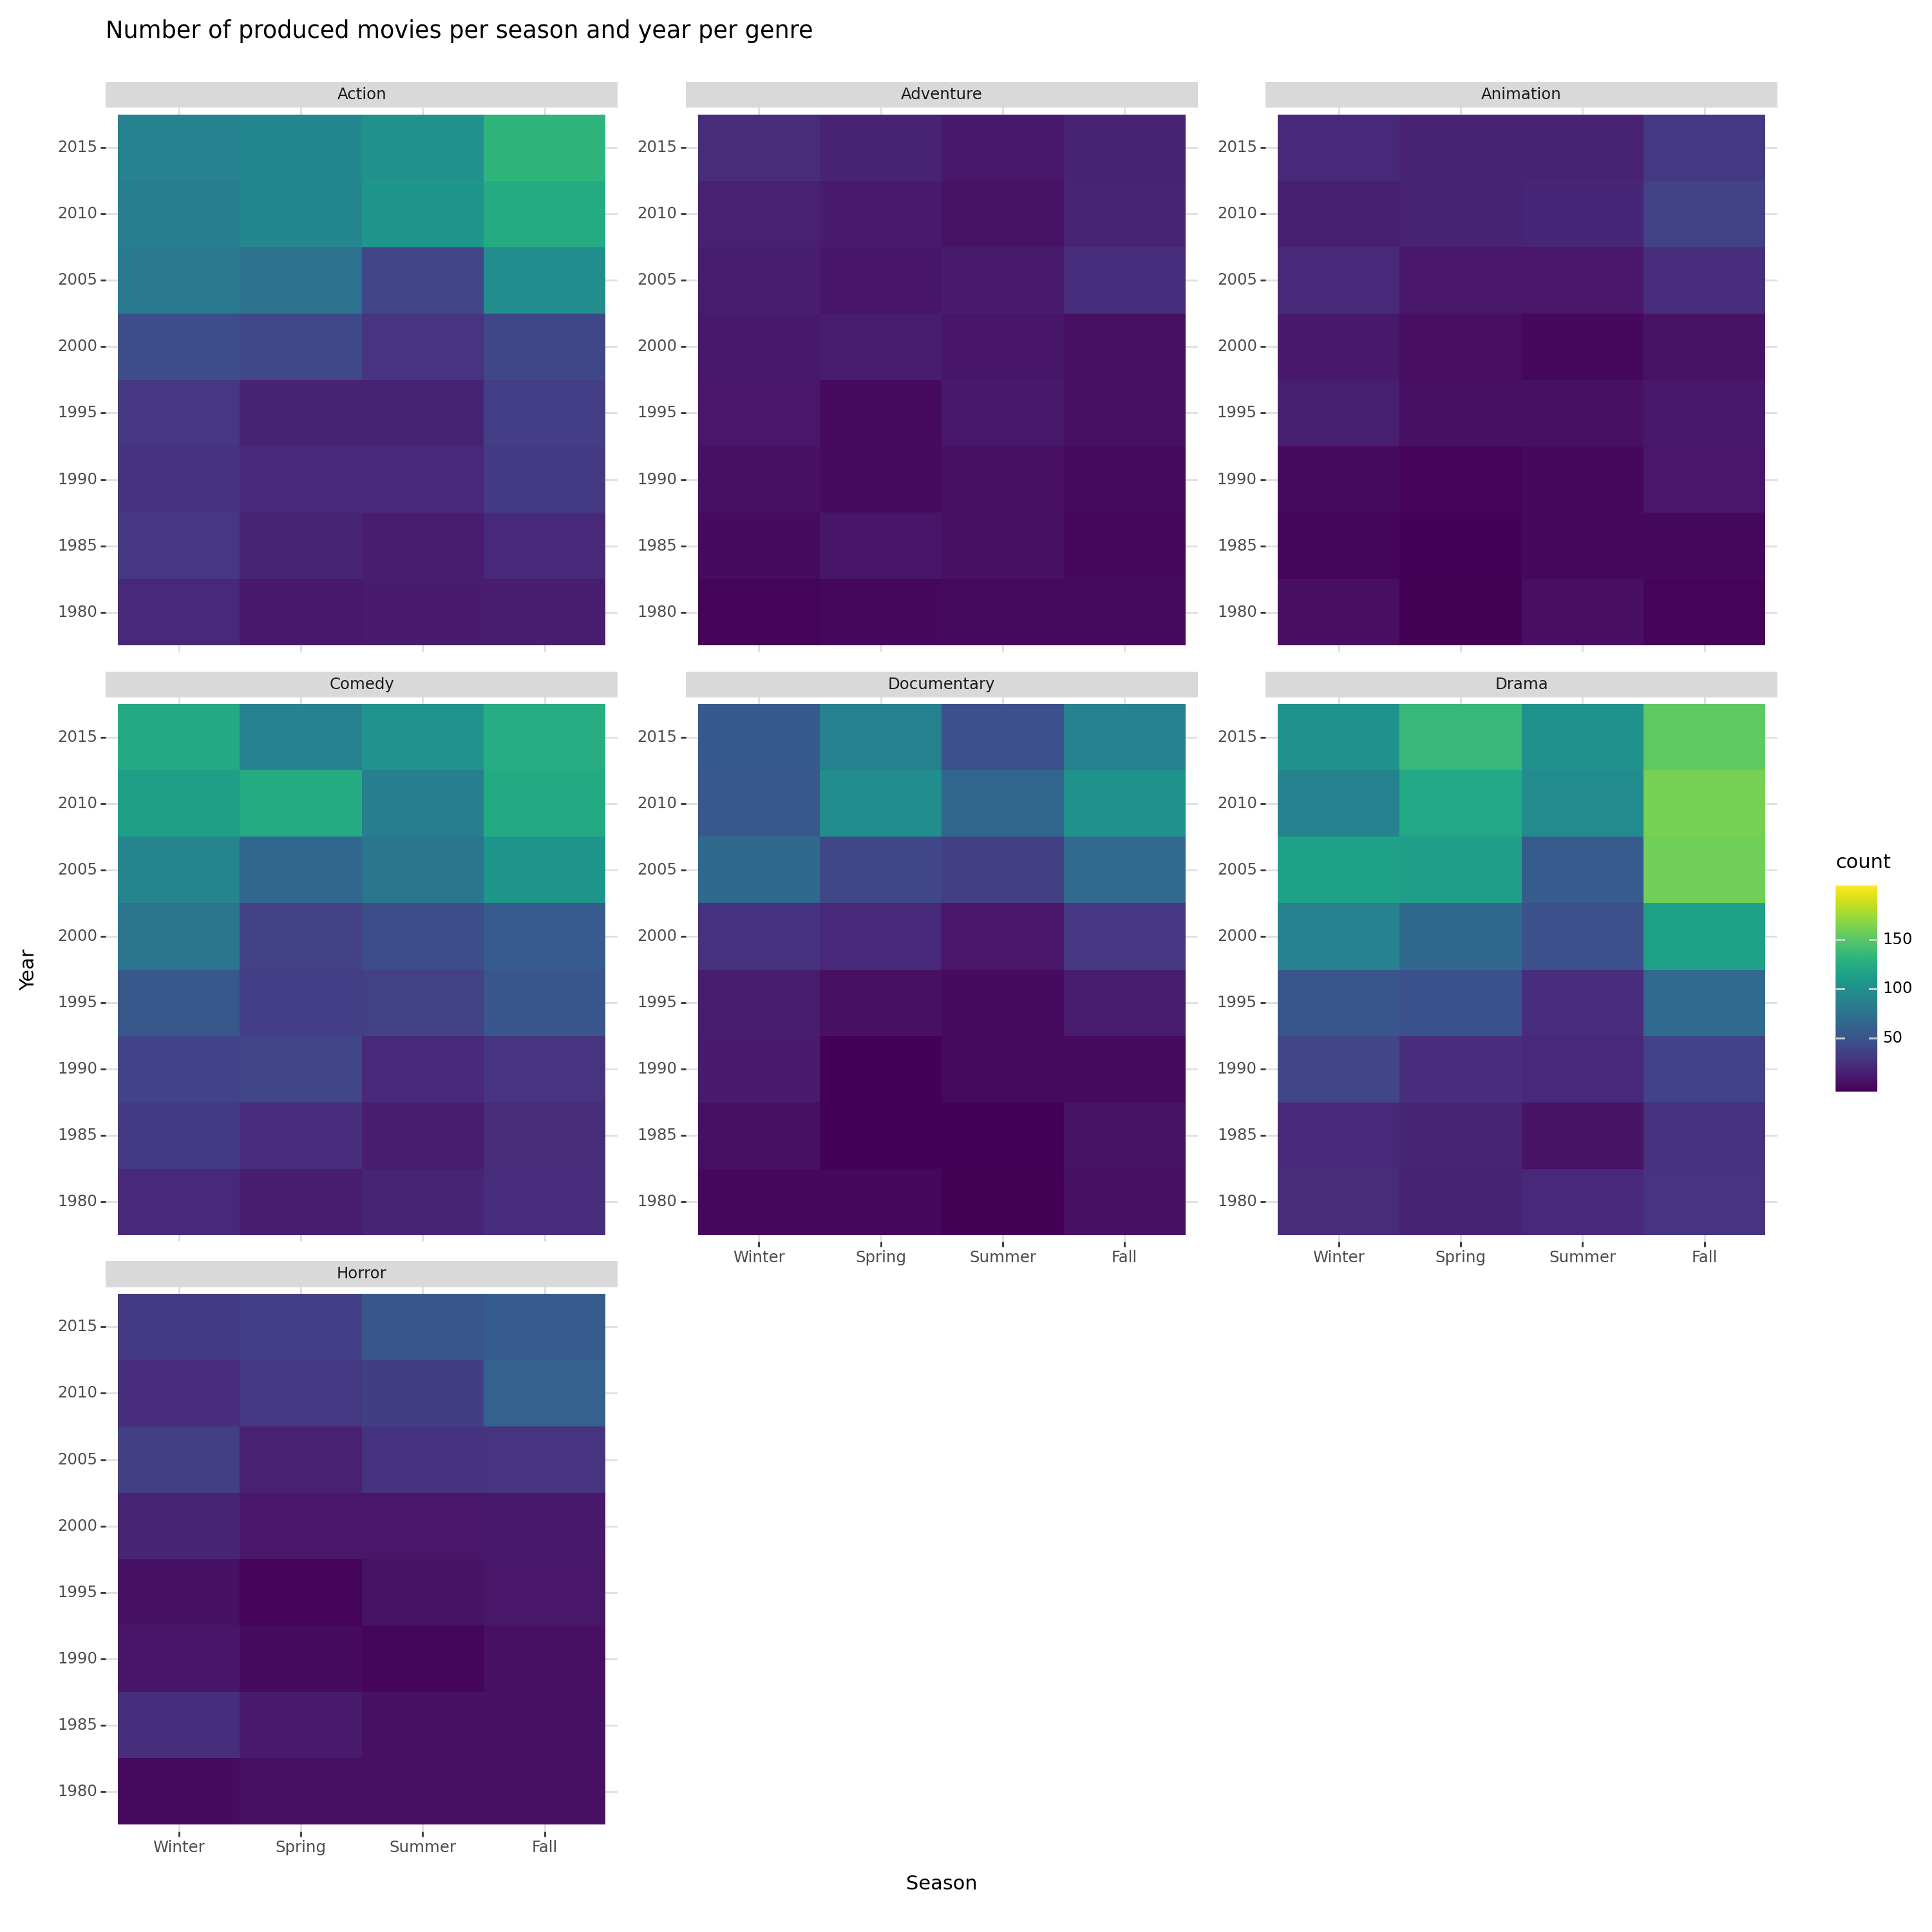

In [14]:
# For each genre create a facet_wrap with the number of movies per season and year. Have a different Y axis for each genre

df_season_genre_count = (
    df_main.groupby(["season", "release_year", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_genre_count["release_year"] = df_season_genre_count["release_year"].apply(
    lambda x: x - x % 5
)

df_season_genre_count["release_year"] = pd.Categorical(
    df_season_genre_count["release_year"],
    sorted(df_season_genre_count["release_year"].unique()),
)

df_season_genre_count["season"] = pd.Categorical(
    df_season_genre_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_genre_count,
        p9.aes("season", "release_year", fill="count"),
    )
    + p9.geom_tile()
    + p9.labs(
        x="Season",
        y="Year",
        title="Number of produced movies per season and year per genre",
    )
    + p9.facet_wrap("main_genre", scales="free_y")
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)

p.draw()


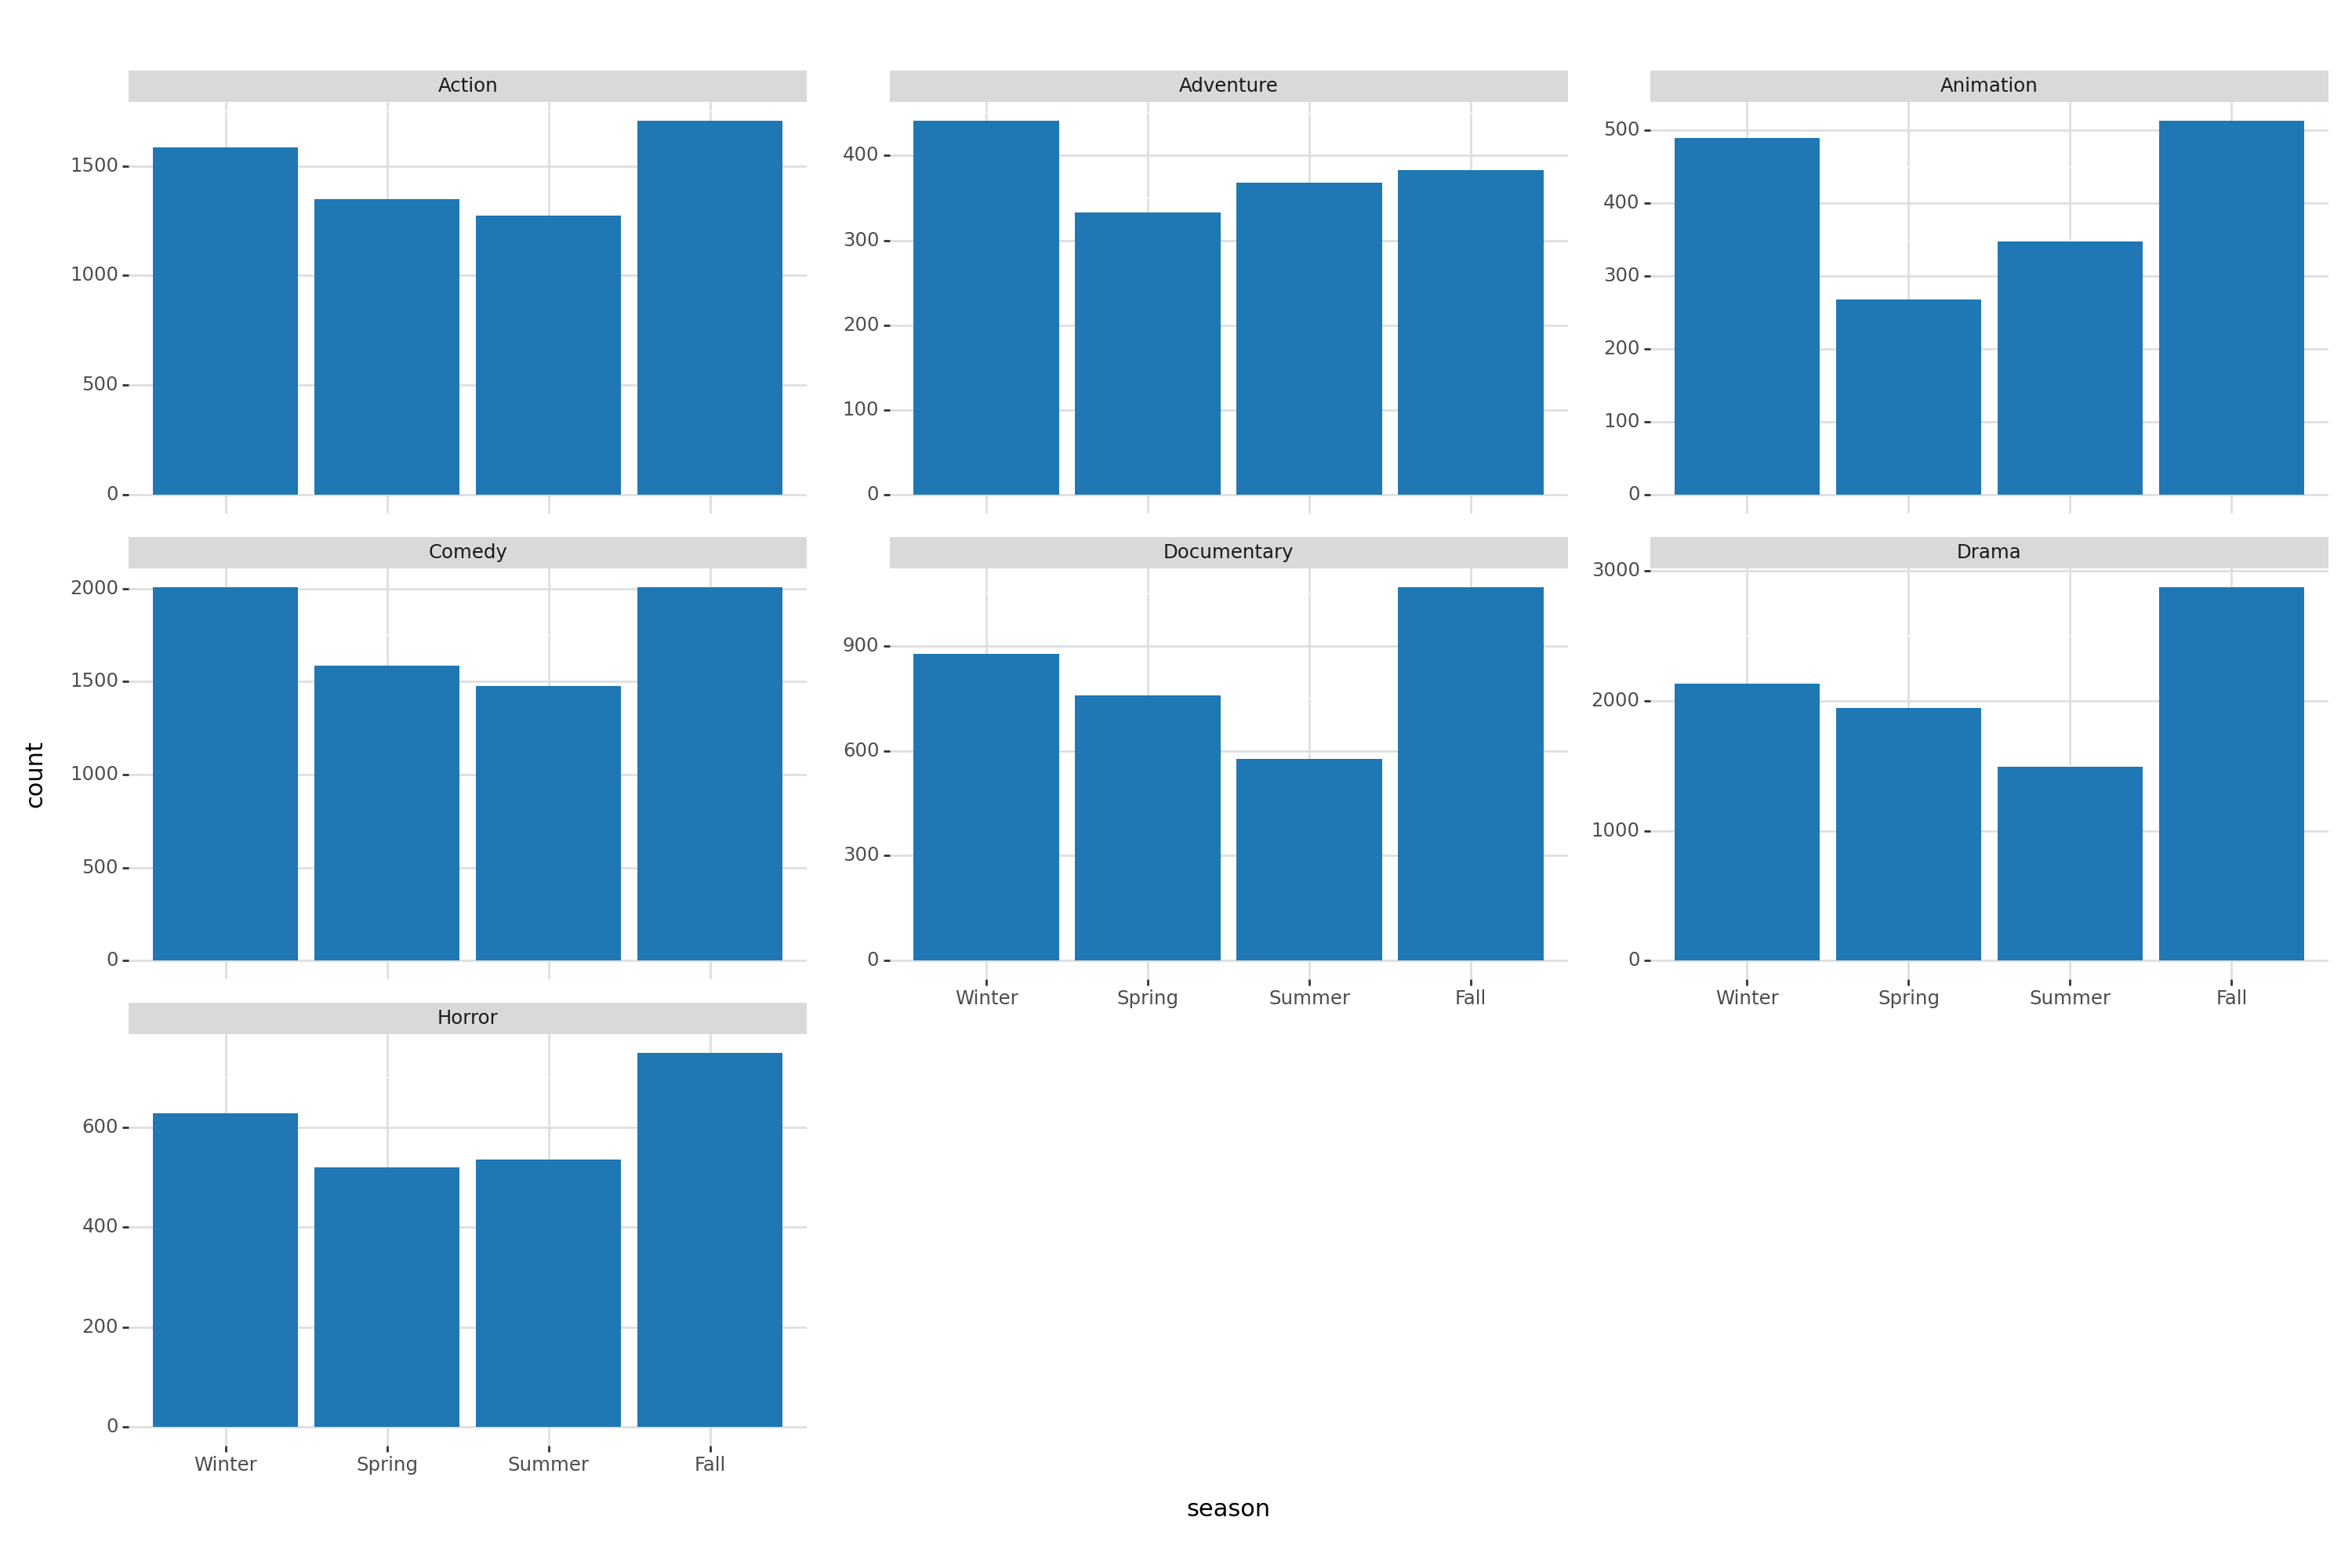

In [15]:
# Create a bar chart with facet wrap for the genre and the number of movies per season. Have a different Y axis for each genre

df_season_genre_count = (
    df_main.groupby(["season", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_genre_count["season"] = pd.Categorical(
    df_season_genre_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_genre_count,
        p9.aes("season", "count"),
    )
    + p9.geom_col(position="stack", fill="#1f77b4")
    + p9.facet_wrap("main_genre", scales="free_y")
    + p9.theme(
        figure_size=(15, 10),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)

p.draw()


season  count
Winter  8153     1
Spring  6757     1
Summer  6070     1
Fall    9302     1
Name: count, dtype: int64


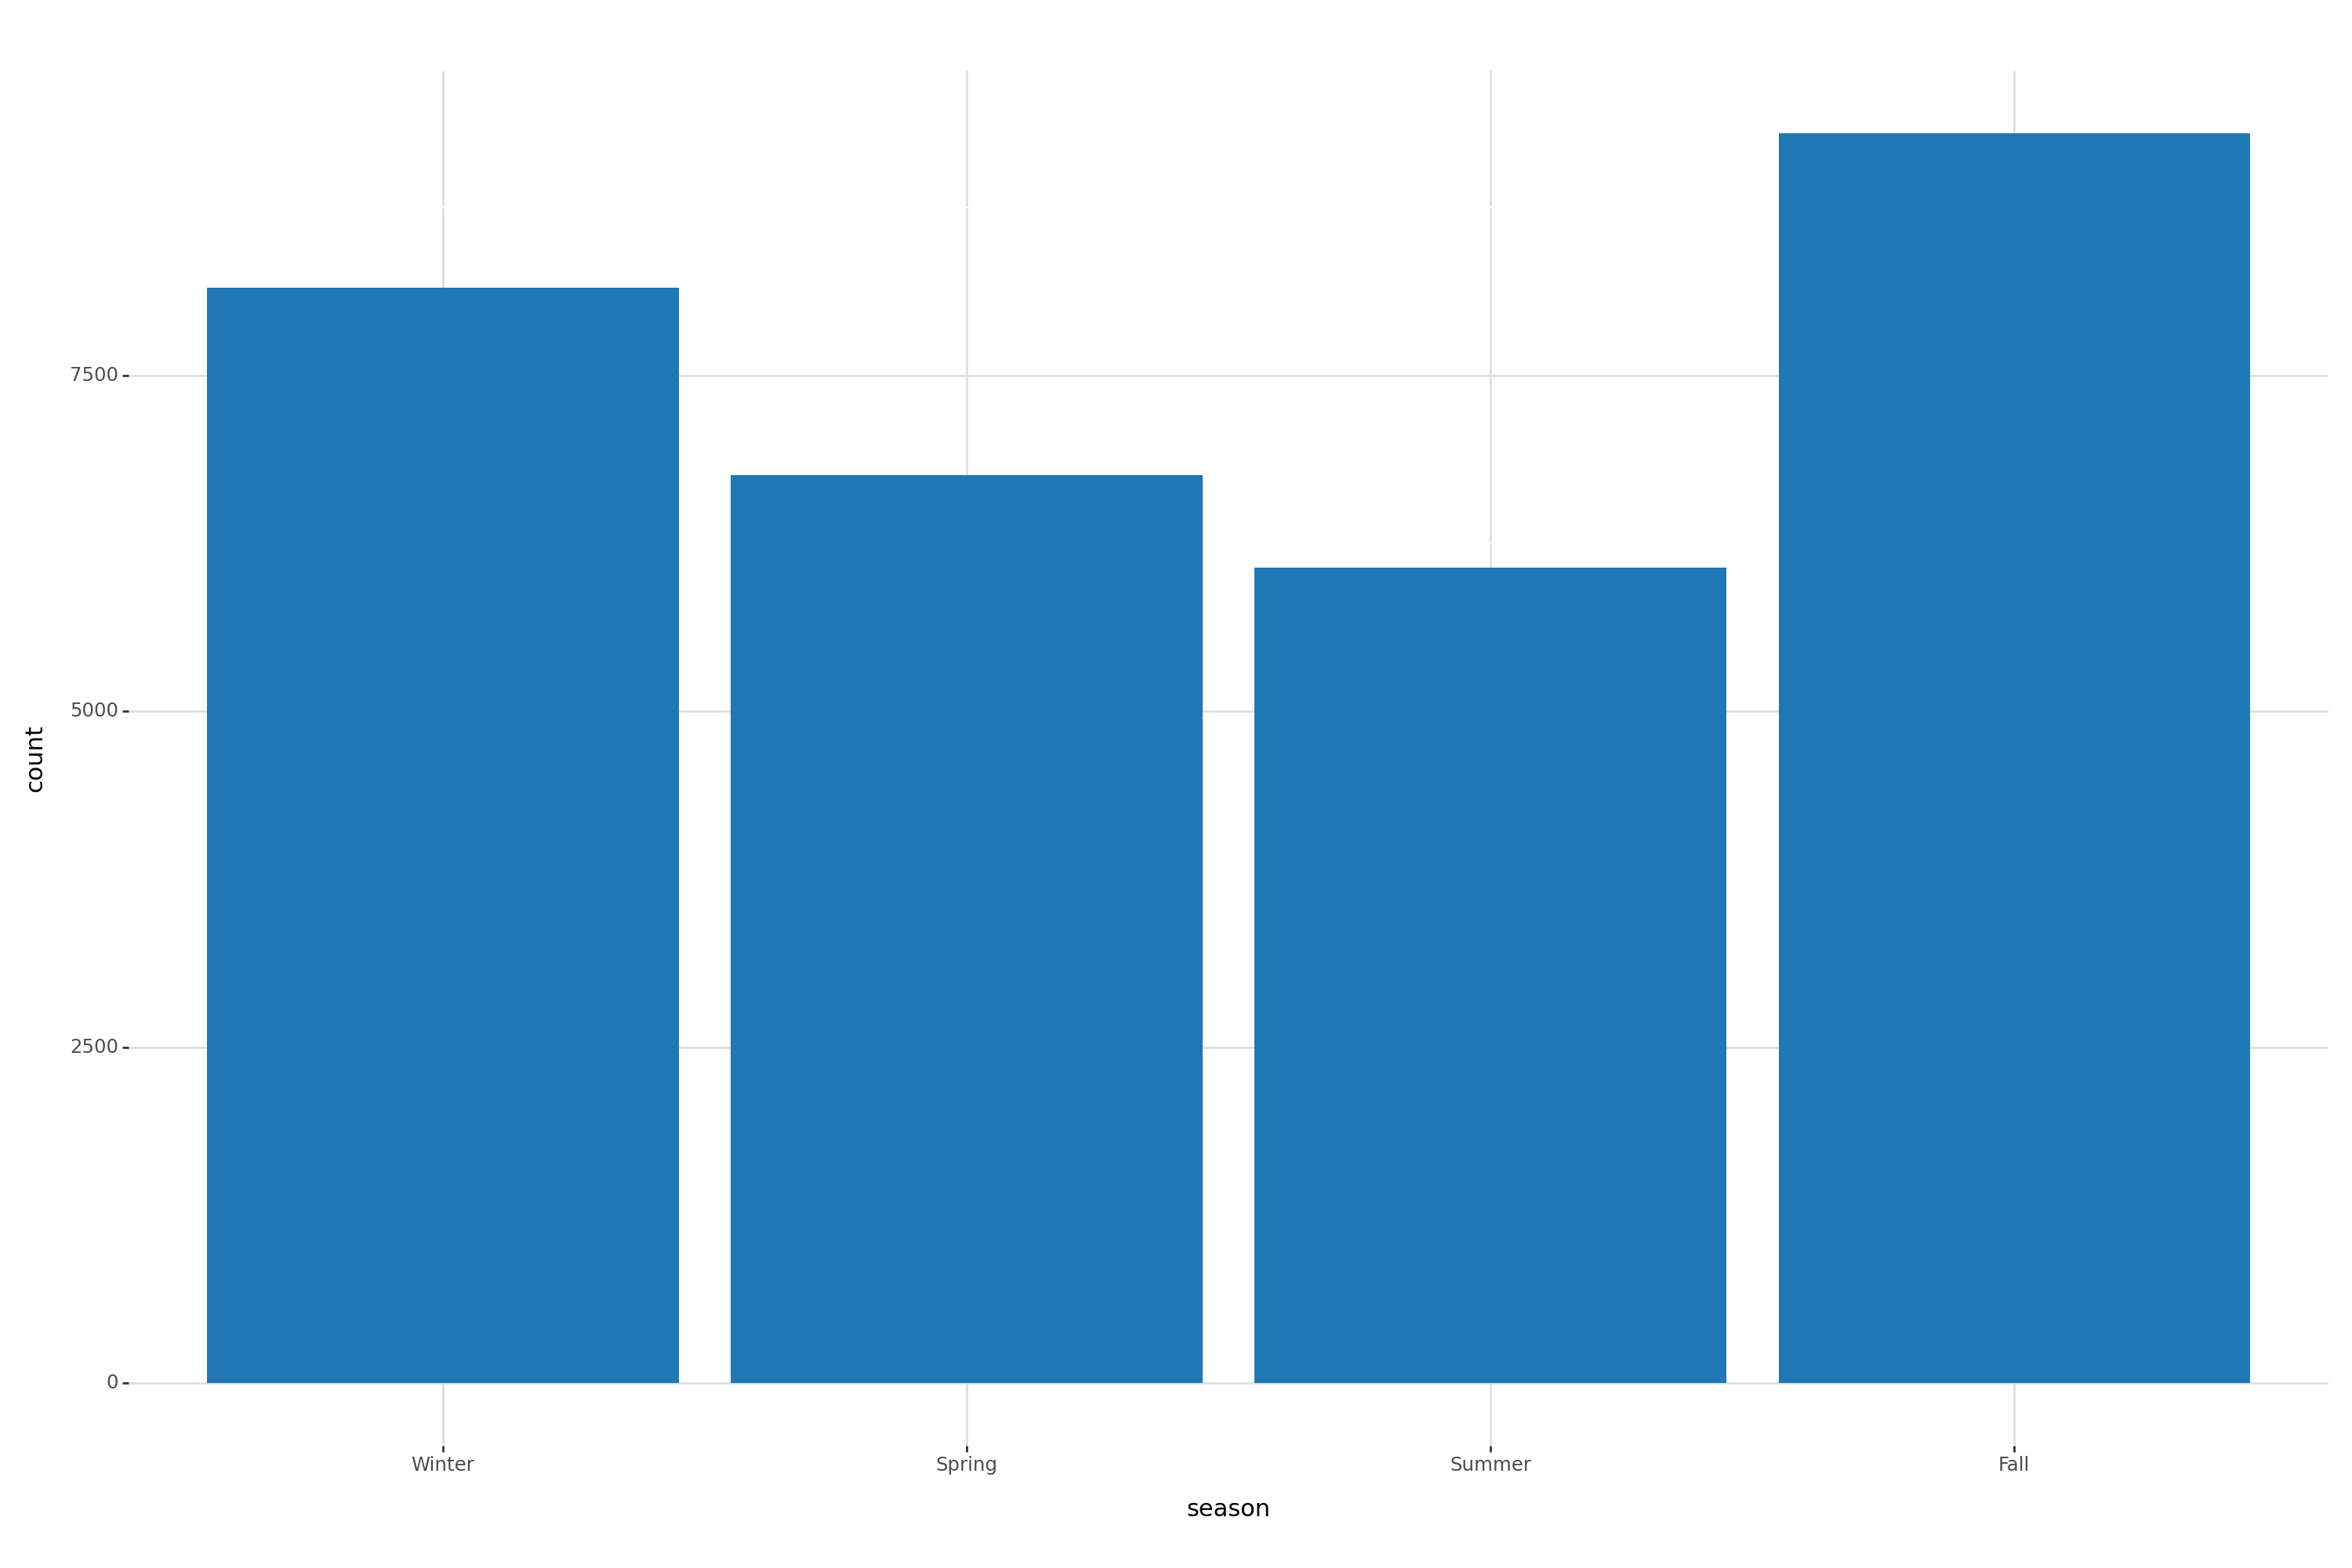

In [16]:
# Total number of movies per season
df_season_count = (
    df_main.groupby(["season"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_count["season"] = pd.Categorical(
    df_season_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_count,
        p9.aes("season", "count"),
    )
    + p9.geom_col(position="stack", fill="#1f77b4")
    + p9.theme(
        figure_size=(15, 10),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
print(df_season_count.value_counts())
p.draw()


In [17]:
df_main["main_genre"] = df_main["genres"].apply(
    lambda x: x[0].strip() if len(x) > 0 else None
)
df_main.dropna(subset=["main_genre"], inplace=True)


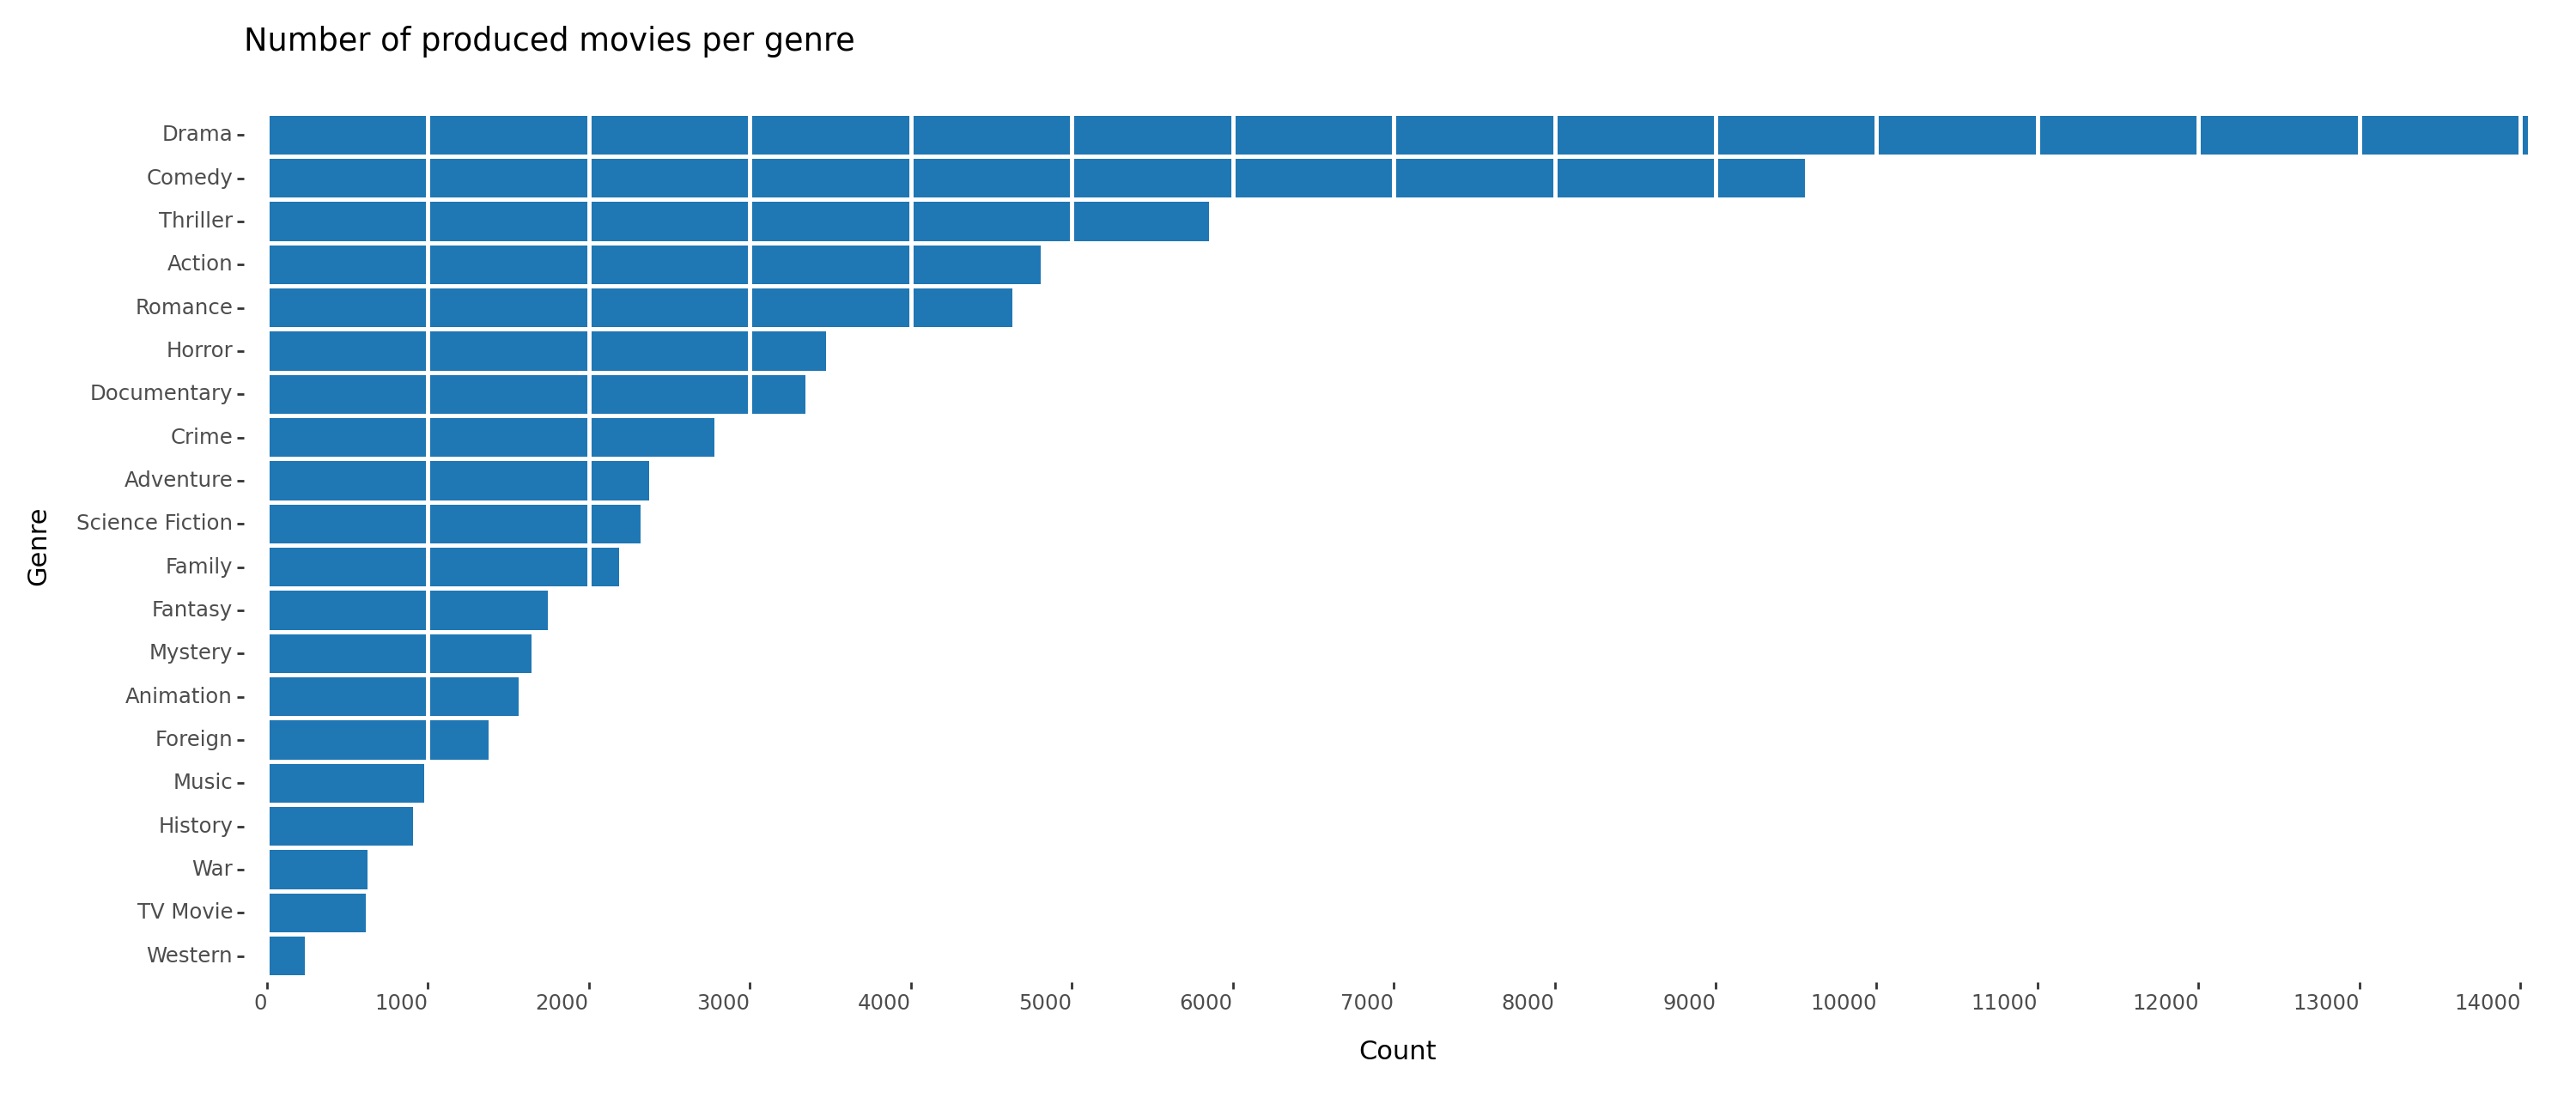

In [18]:
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = df_genres.groupby("genres").size().reset_index(name="count")
df_genres_count = df_genres_count.sort_values(by="count", ascending=False)

p = (
    p9.ggplot(df_genres_count, p9.aes("reorder(genres, count)", "count", fill="genres"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 15000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


(20, 2)


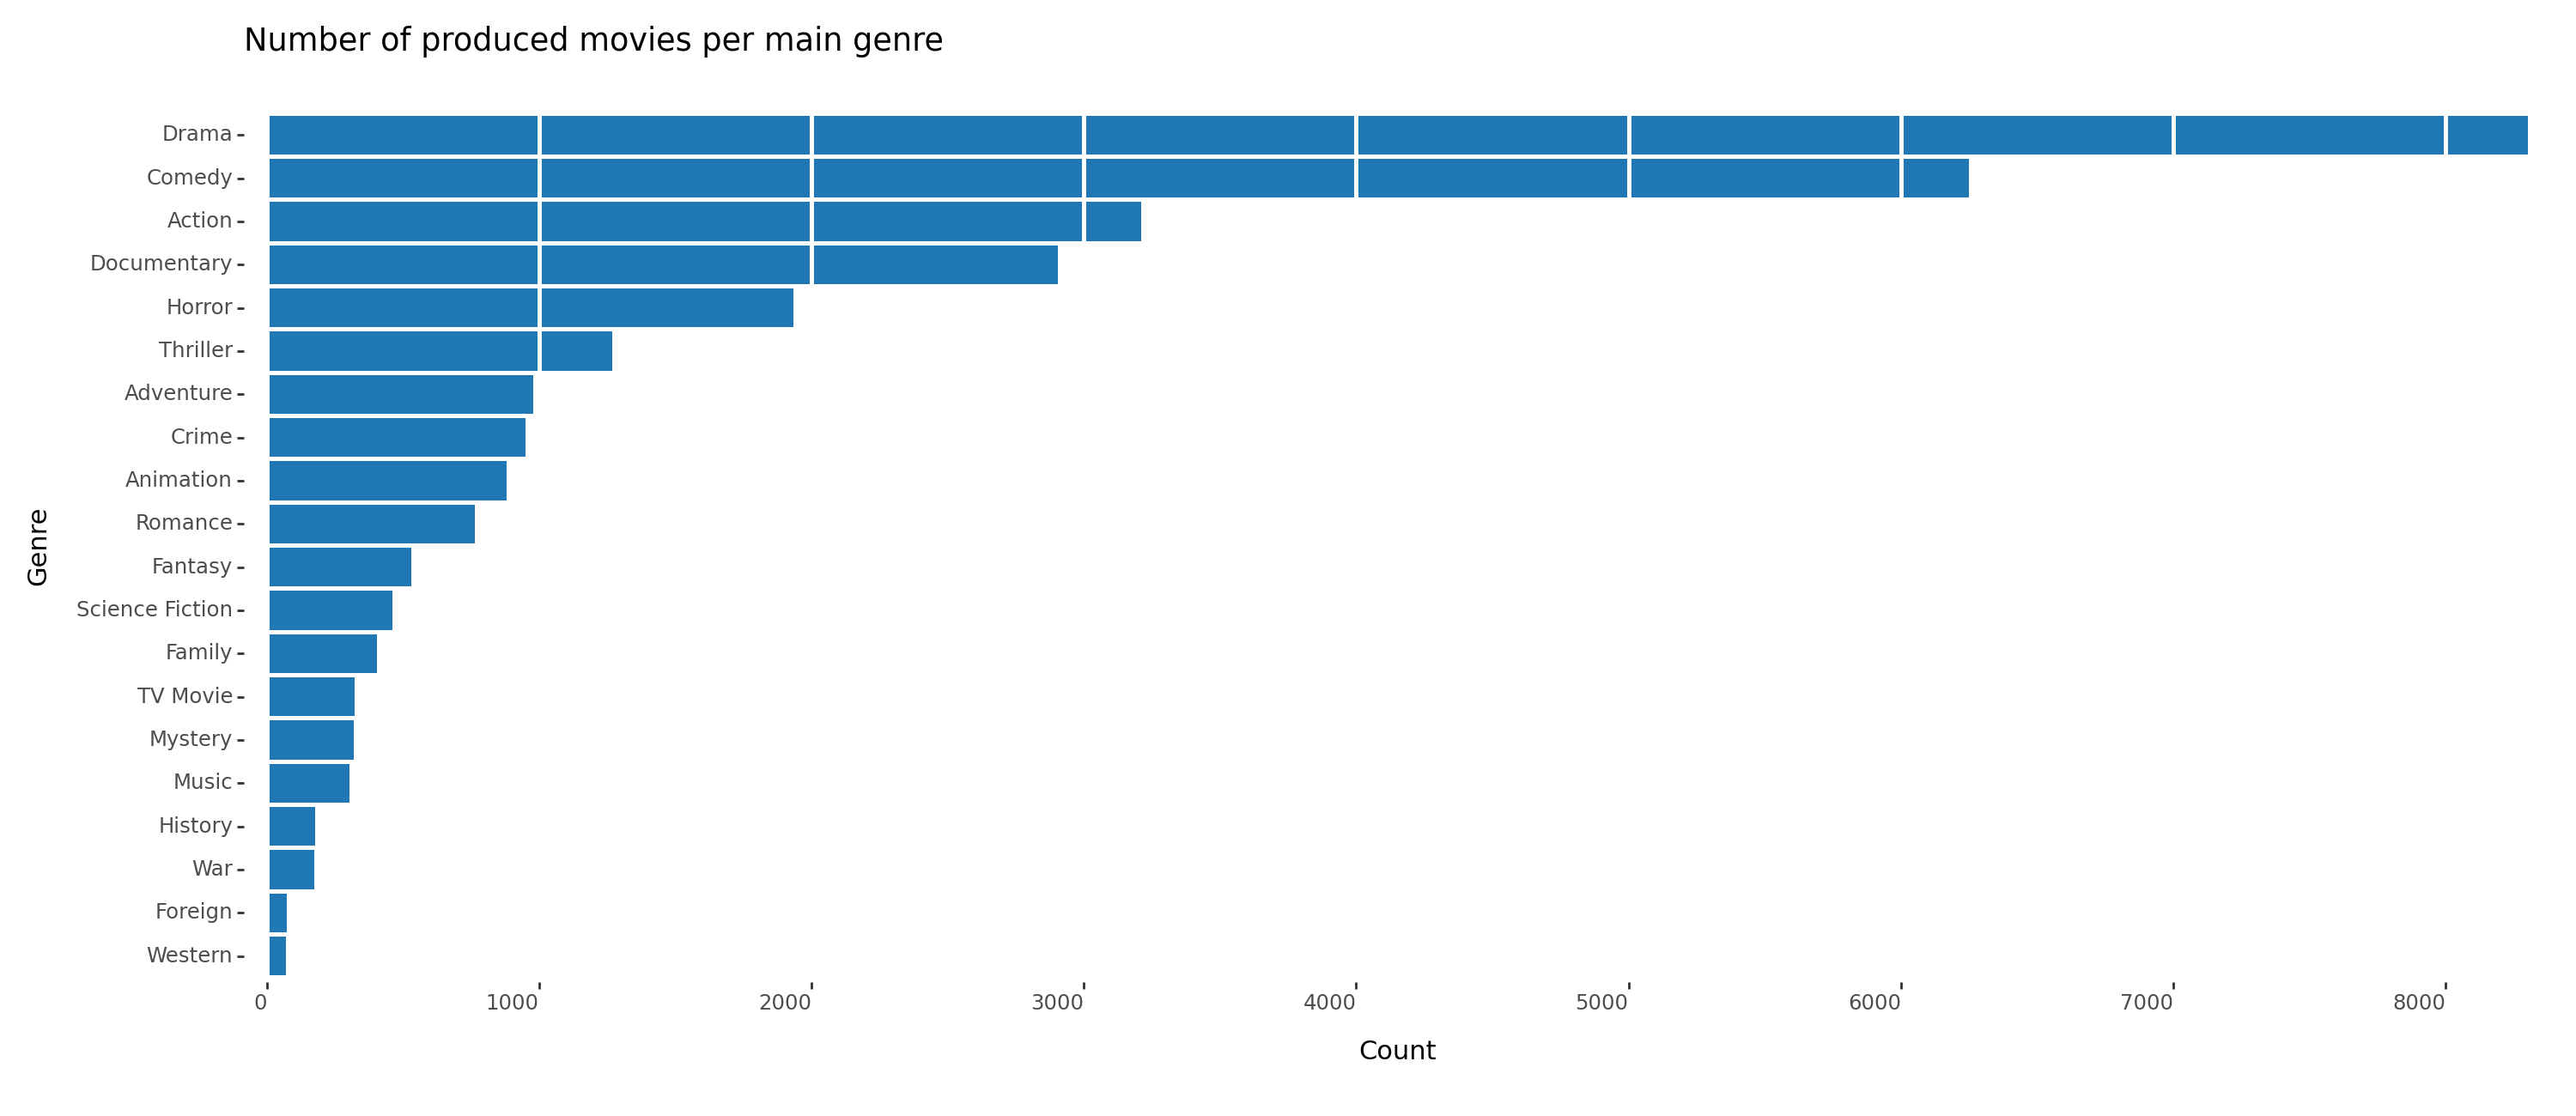

In [19]:
# Visualize the count by main genre
df_main_count = df_main.groupby("main_genre").size().reset_index(name="count")
df_main_count = df_main_count.sort_values(by="count", ascending=False)
print(df_main_count.shape)

p = (
    p9.ggplot(
        df_main_count, p9.aes("reorder(main_genre, count)", "count", fill="main_genre")
    )
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per main genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 9000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


(20, 2)


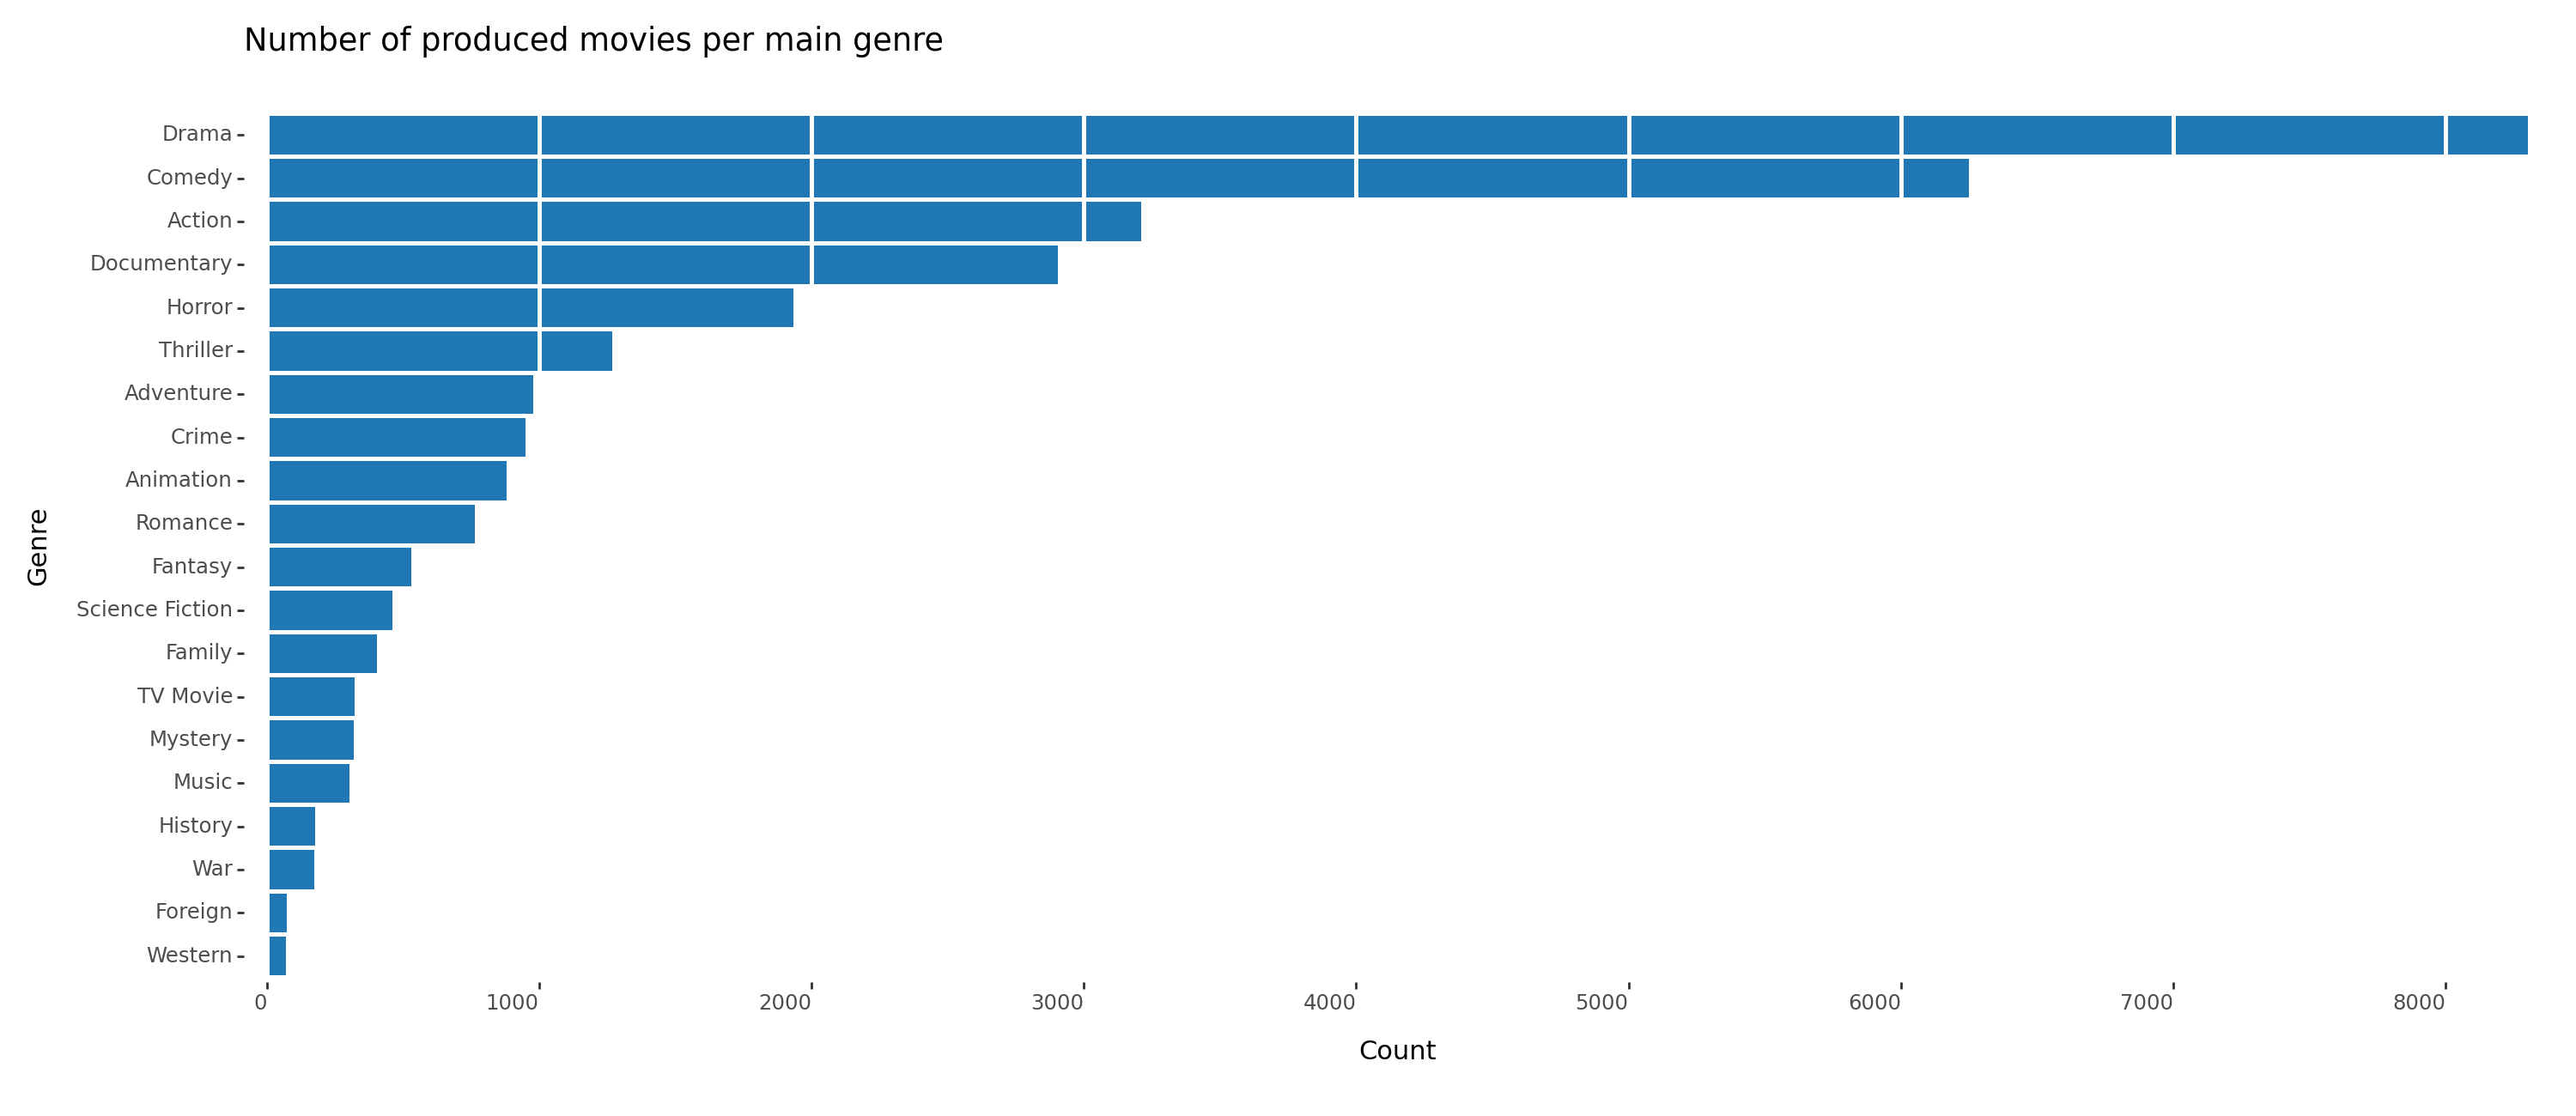

In [20]:
# Visualize the count by main genre
df_main_count = df_main.groupby("main_genre").size().reset_index(name="count")
df_main_count = df_main_count.sort_values(by="count", ascending=False)
print(df_main_count.shape)

p = (
    p9.ggplot(
        df_main_count, p9.aes("reorder(main_genre, count)", "count", fill="main_genre")
    )
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per main genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 9000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)

p.draw()


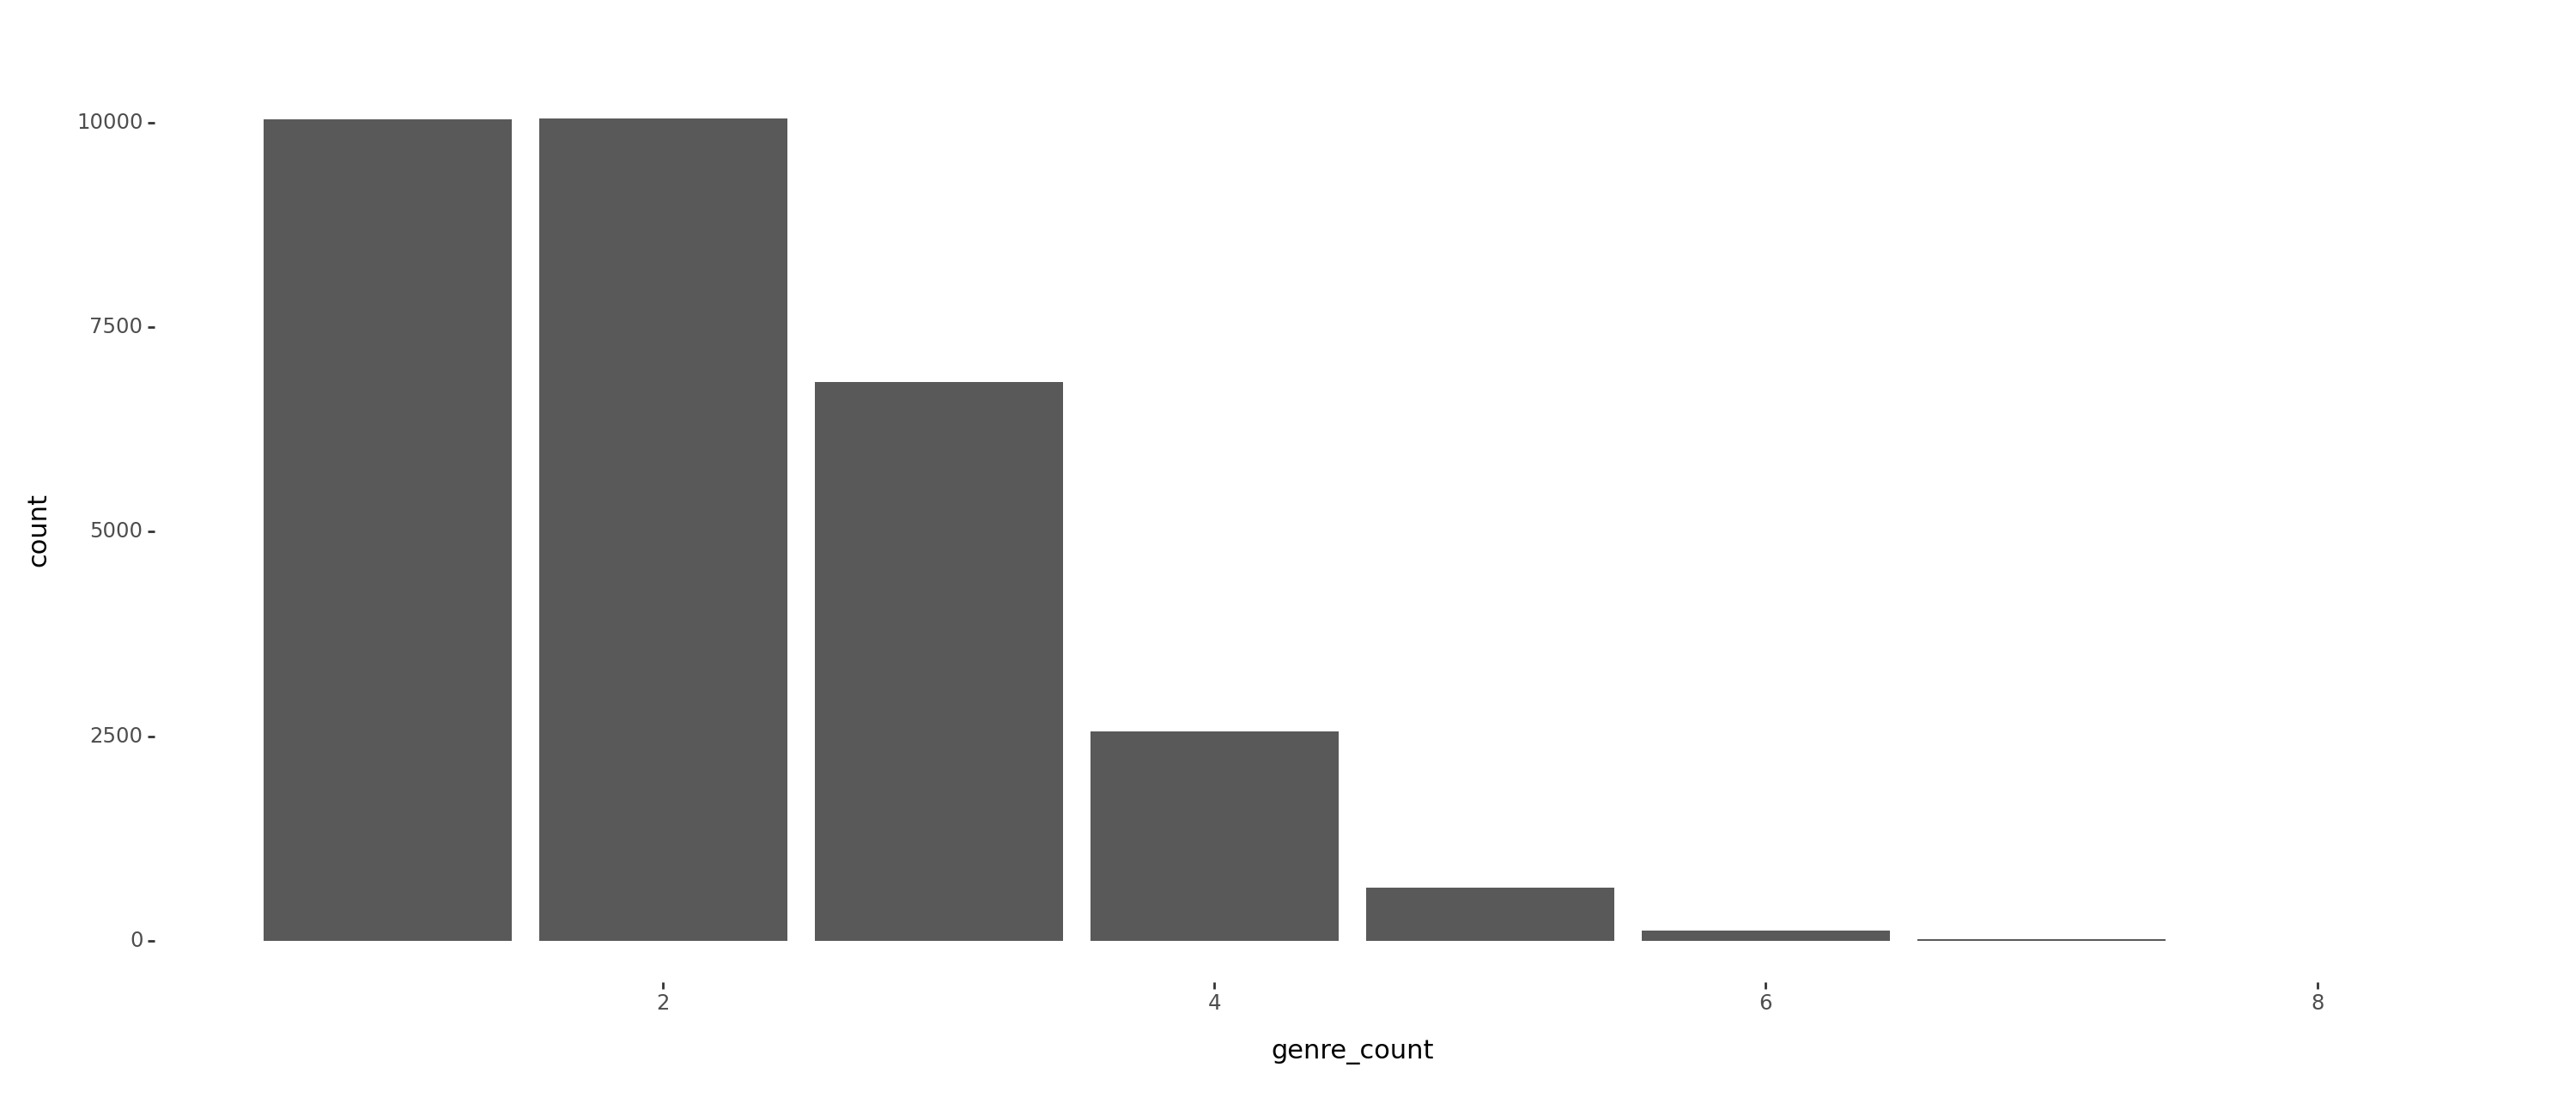

In [21]:
df_genre_counts = df_main.copy()
df_genre_counts["genre_count"] = df_genre_counts["genres"].apply(lambda x: len(set(x)))
# group the movies by the number of genres they have
df_genre_counts.groupby("genre_count").size().reset_index(name="count")

p = (
    p9.ggplot(df_genre_counts, p9.aes("genre_count", fill="genre_count"))
    + p9.geom_bar()
    + p9.scale_fill_gradient(low="#1f77b4", high="#ff7f0e")
    + p9.theme(
        legend_position="none",
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
)
p.draw()


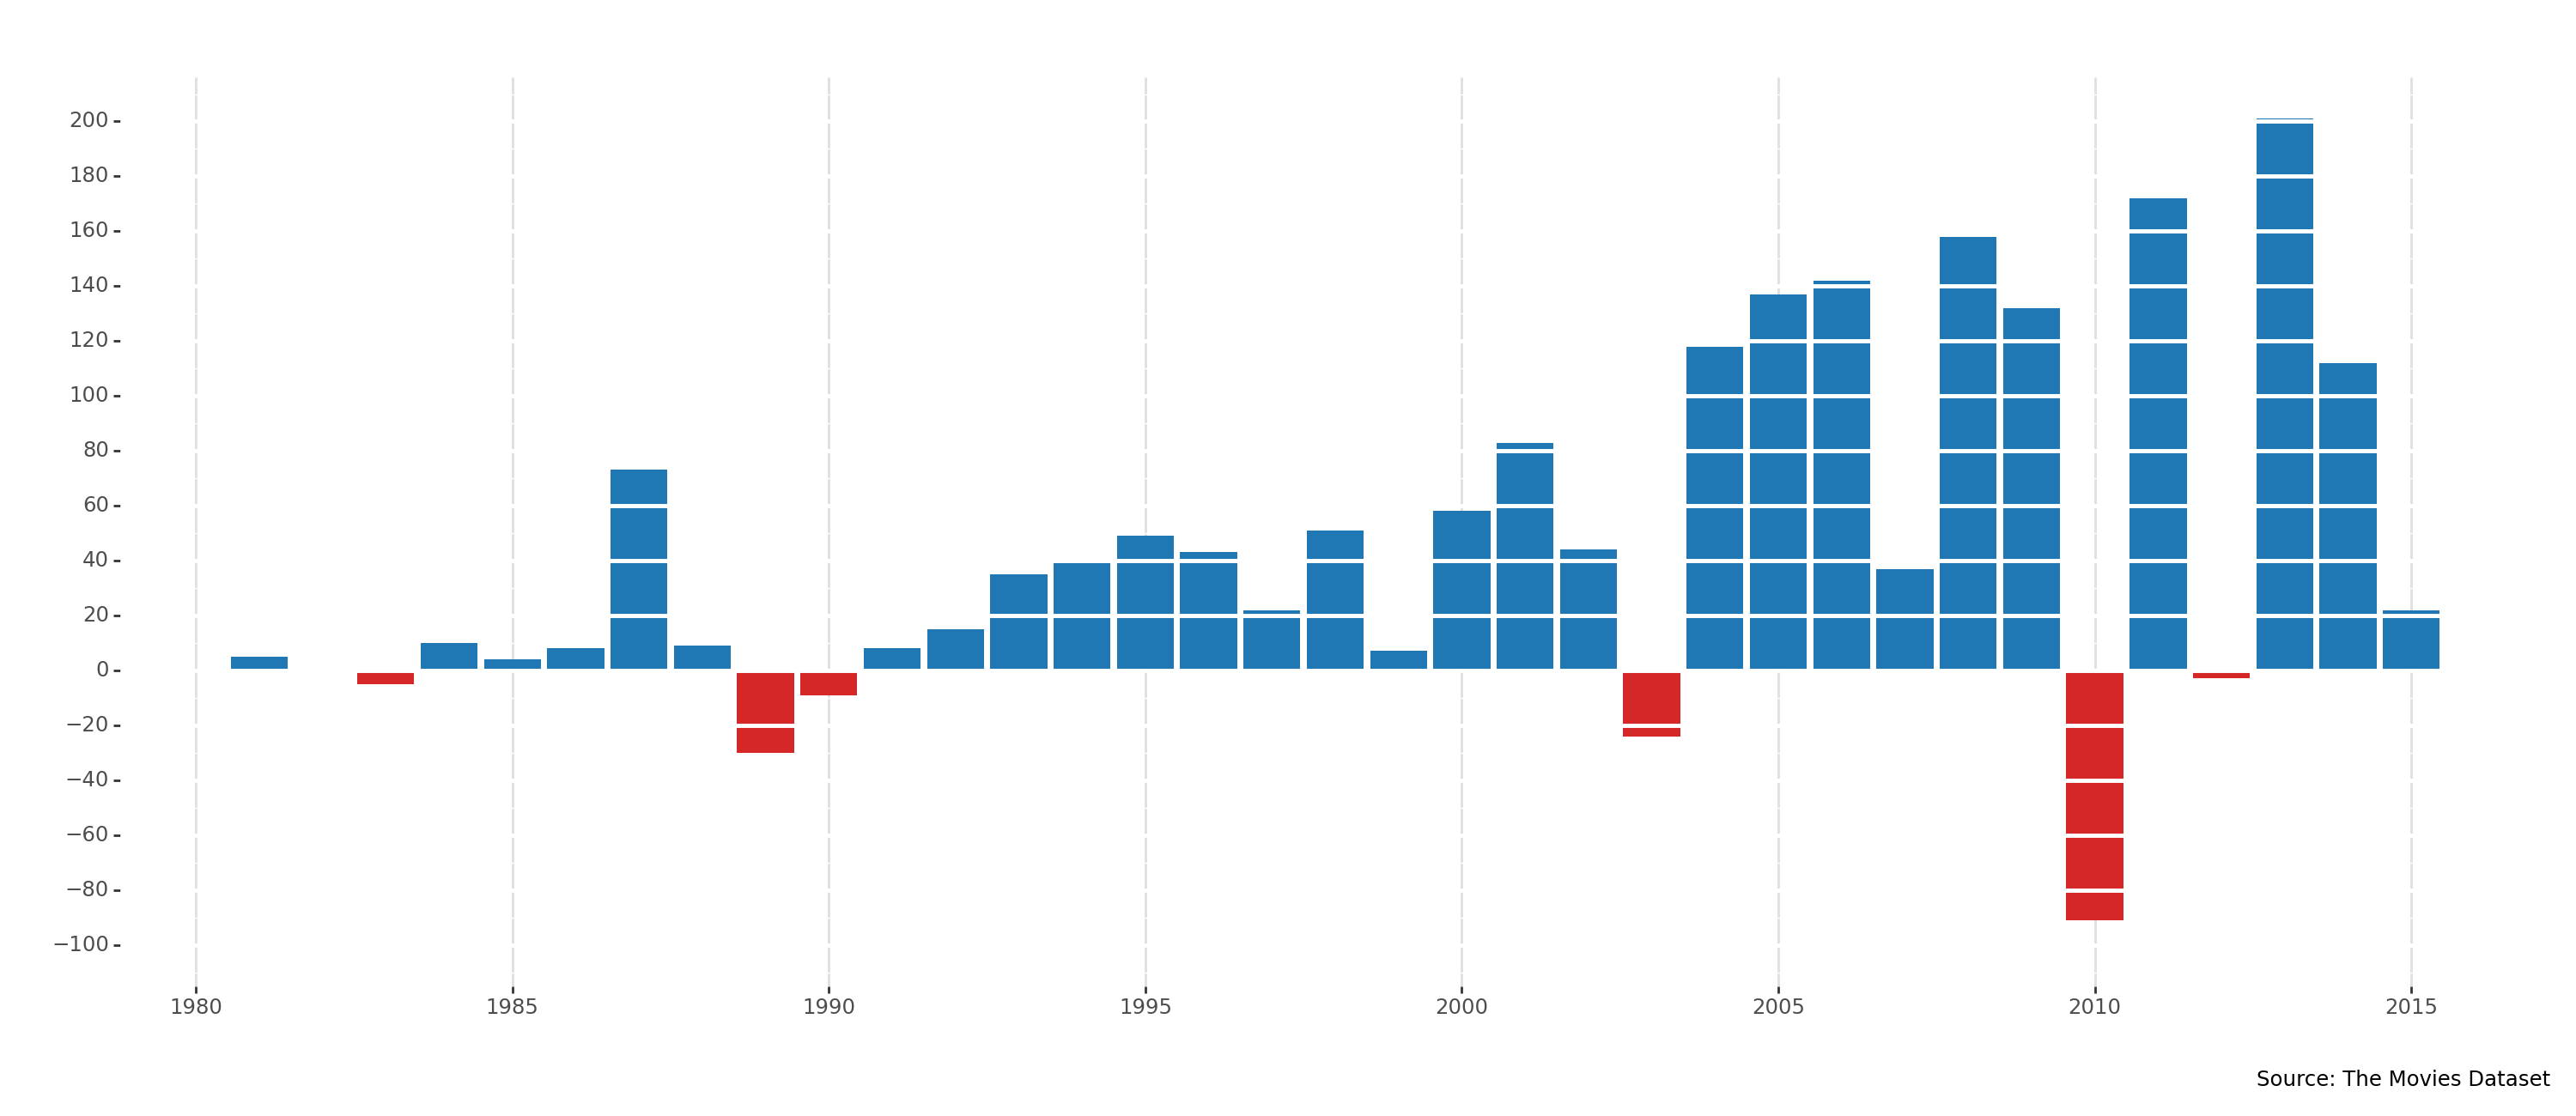

In [22]:
# Let's now see how the number of movies produced per year has evolved.
df_year_count = df_main.groupby("release_year").size().reset_index(name="count")
df_year_count = df_year_count.sort_values(by="release_year", ascending=True)
df_year_count["count"] = df_year_count["count"].astype(int)

df_year_count["count"] = df_year_count["count"].diff()
df_year_count = df_year_count.dropna(subset=["count"])
df_year_count["count"] = df_year_count["count"].astype(int)

p = (
    p9.ggplot(df_year_count, p9.aes("release_year", "count"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(
        data=df_year_count[df_year_count["count"] < 0], stat="identity", fill="#d62728"
    )
    + p9.labs(
        x="",
        y="",
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5))
    + p9.scale_y_continuous(breaks=range(-100, 210, 20), expand=(0.05, 0.05))
    + p9.geom_hline(yintercept=range(-100, 210, 20), color="#ffffff", size=1)
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)
p.draw()


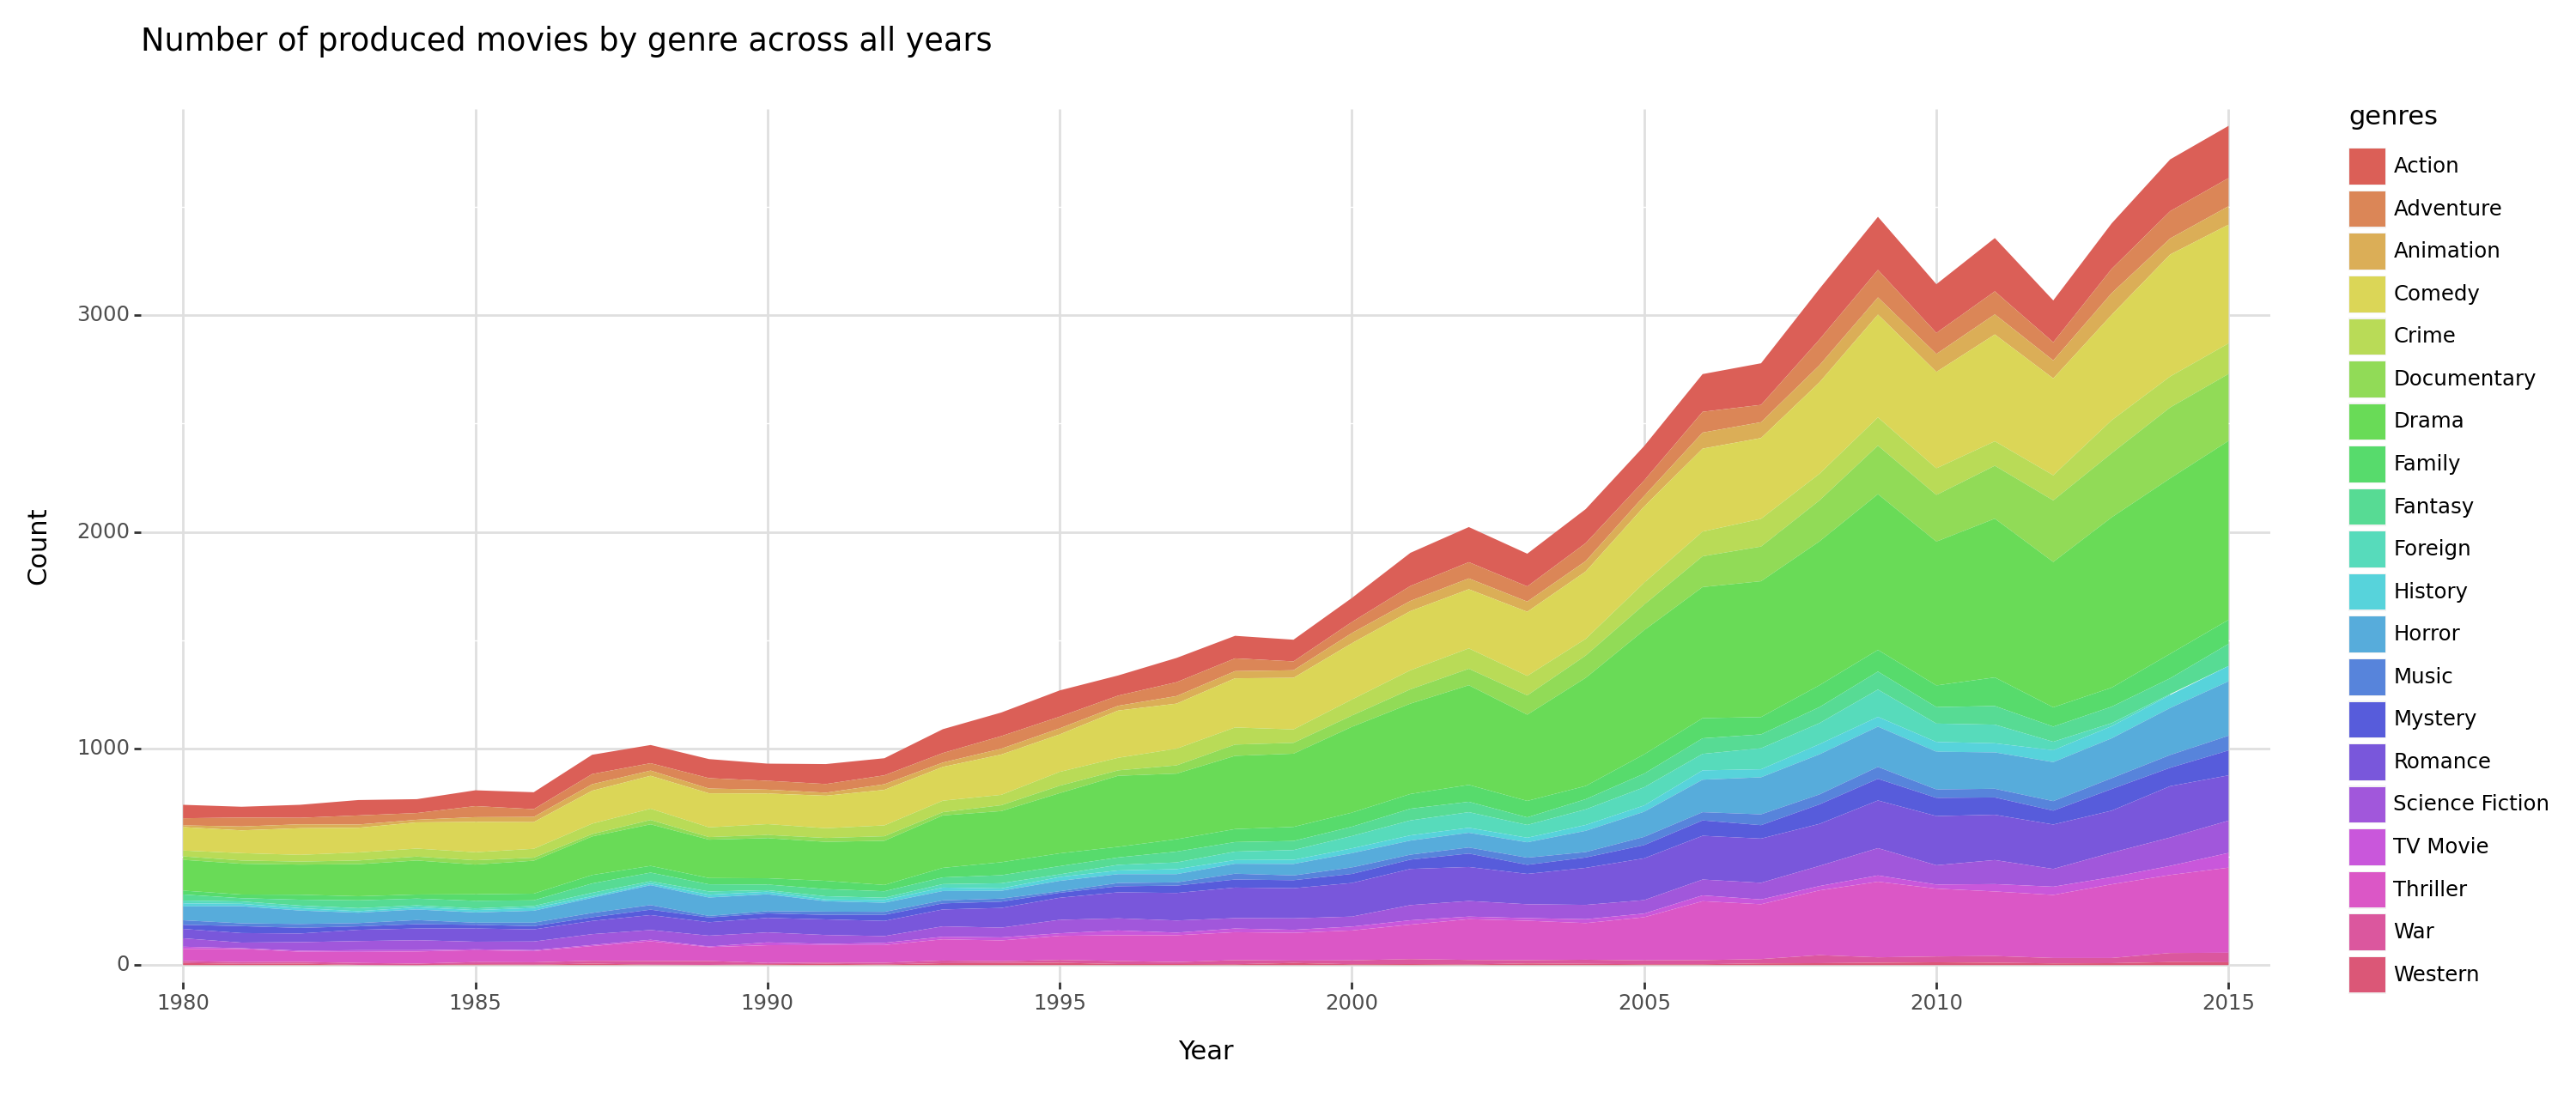

In [23]:
# Total number of produced movies by genre across all years as a stacked area chart.
df_genres_year_count = df_main.explode("genres")
df_genres_year_count = df_genres_year_count.dropna(subset=["genres"])
df_genres_year_count["genres"] = df_genres_year_count["genres"].str.strip()

df_genres_year_count = (
    df_genres_year_count.groupby(["release_year", "genres"])
    .size()
    .reset_index(name="count")
)
df_genres_year_count = df_genres_year_count.sort_values(
    by="release_year", ascending=True
)
df_genres_year_count["count"] = df_genres_year_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_year_count, p9.aes("release_year", "count", fill="genres"))
    + p9.geom_area()
    + p9.labs(
        x="Year", y="Count", title="Number of produced movies by genre across all years"
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5), expand=(0.02, 0.02))
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.02, 0.02))
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


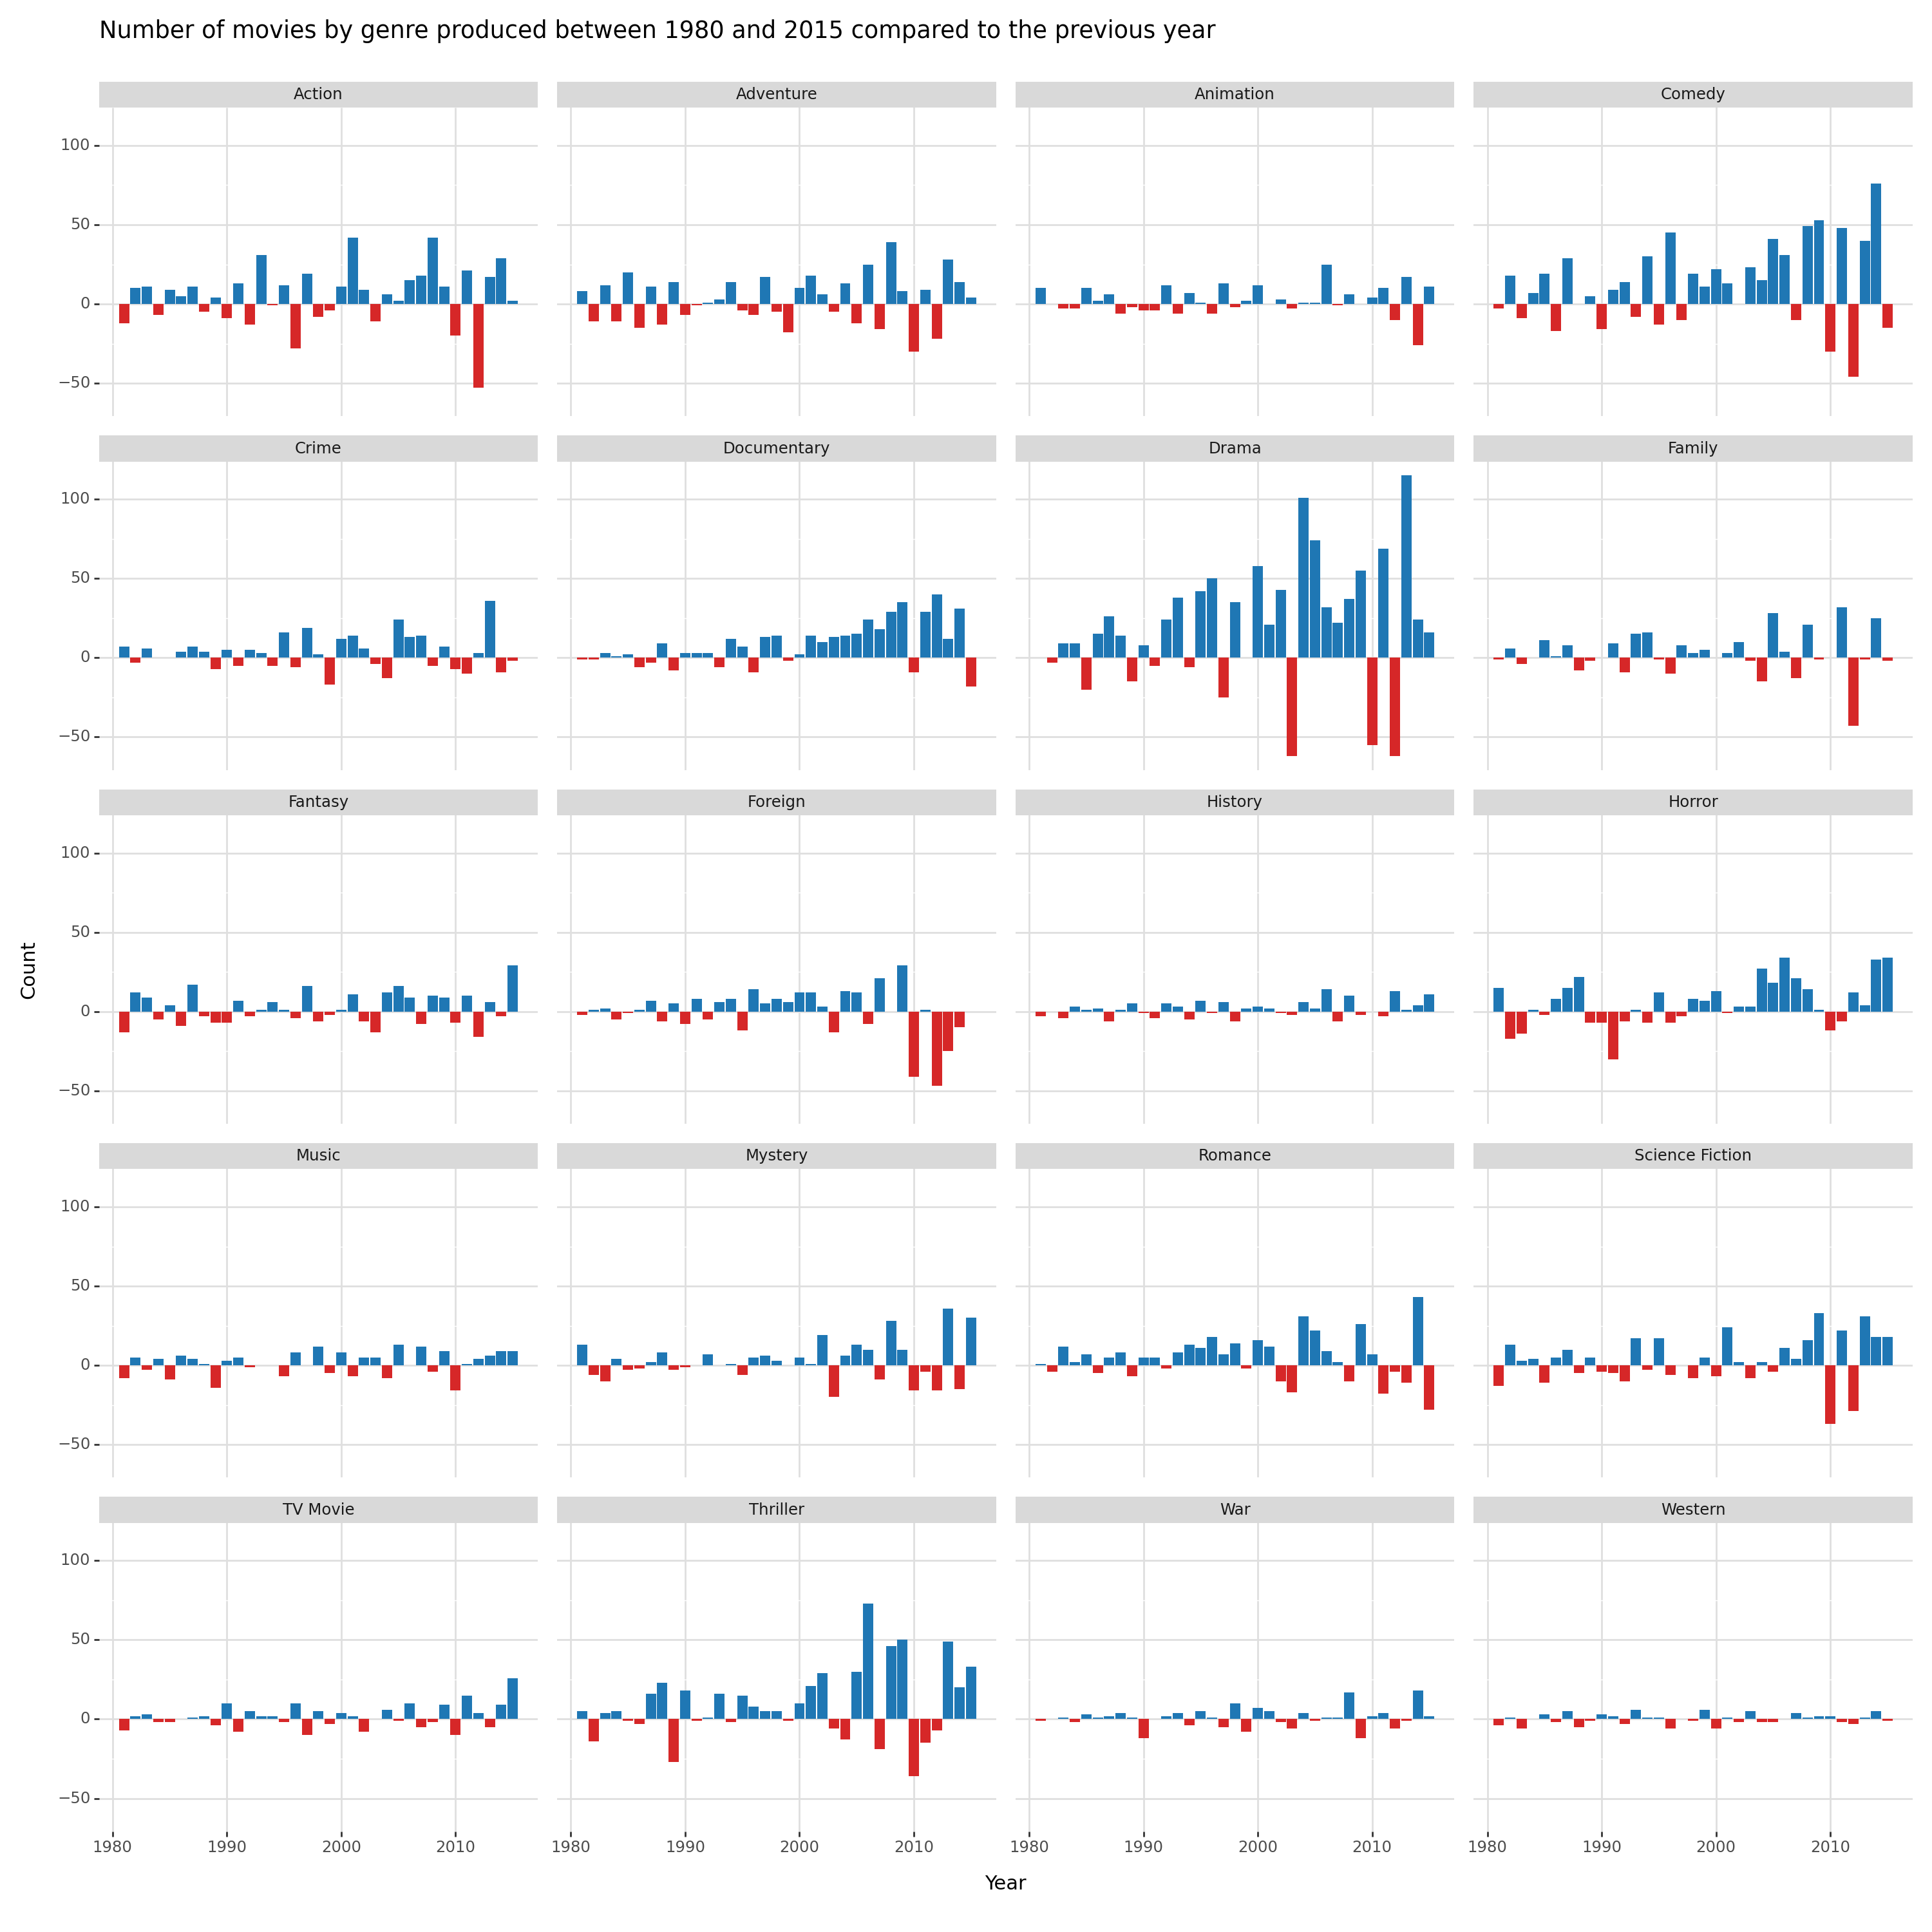

In [24]:
# Let's do a re-expression of the number of movies by genre. We will use the increase per year as a metric.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = (
    df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
)
df_genres_count = df_genres_count.sort_values(
    by=["genres", "release_year"], ascending=True
)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_count, p9.aes("release_year", "count"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(
        data=df_genres_count[df_genres_count["count"] < 0],
        stat="identity",
        fill="#d62728",
    )
    + p9.labs(
        x="Year",
        y="Count",
        title="Number of movies by genre produced between 1980 and 2015 compared to the previous year",
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.facet_wrap("genres", ncol=4, scales="fixed", labeller="label_context")
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


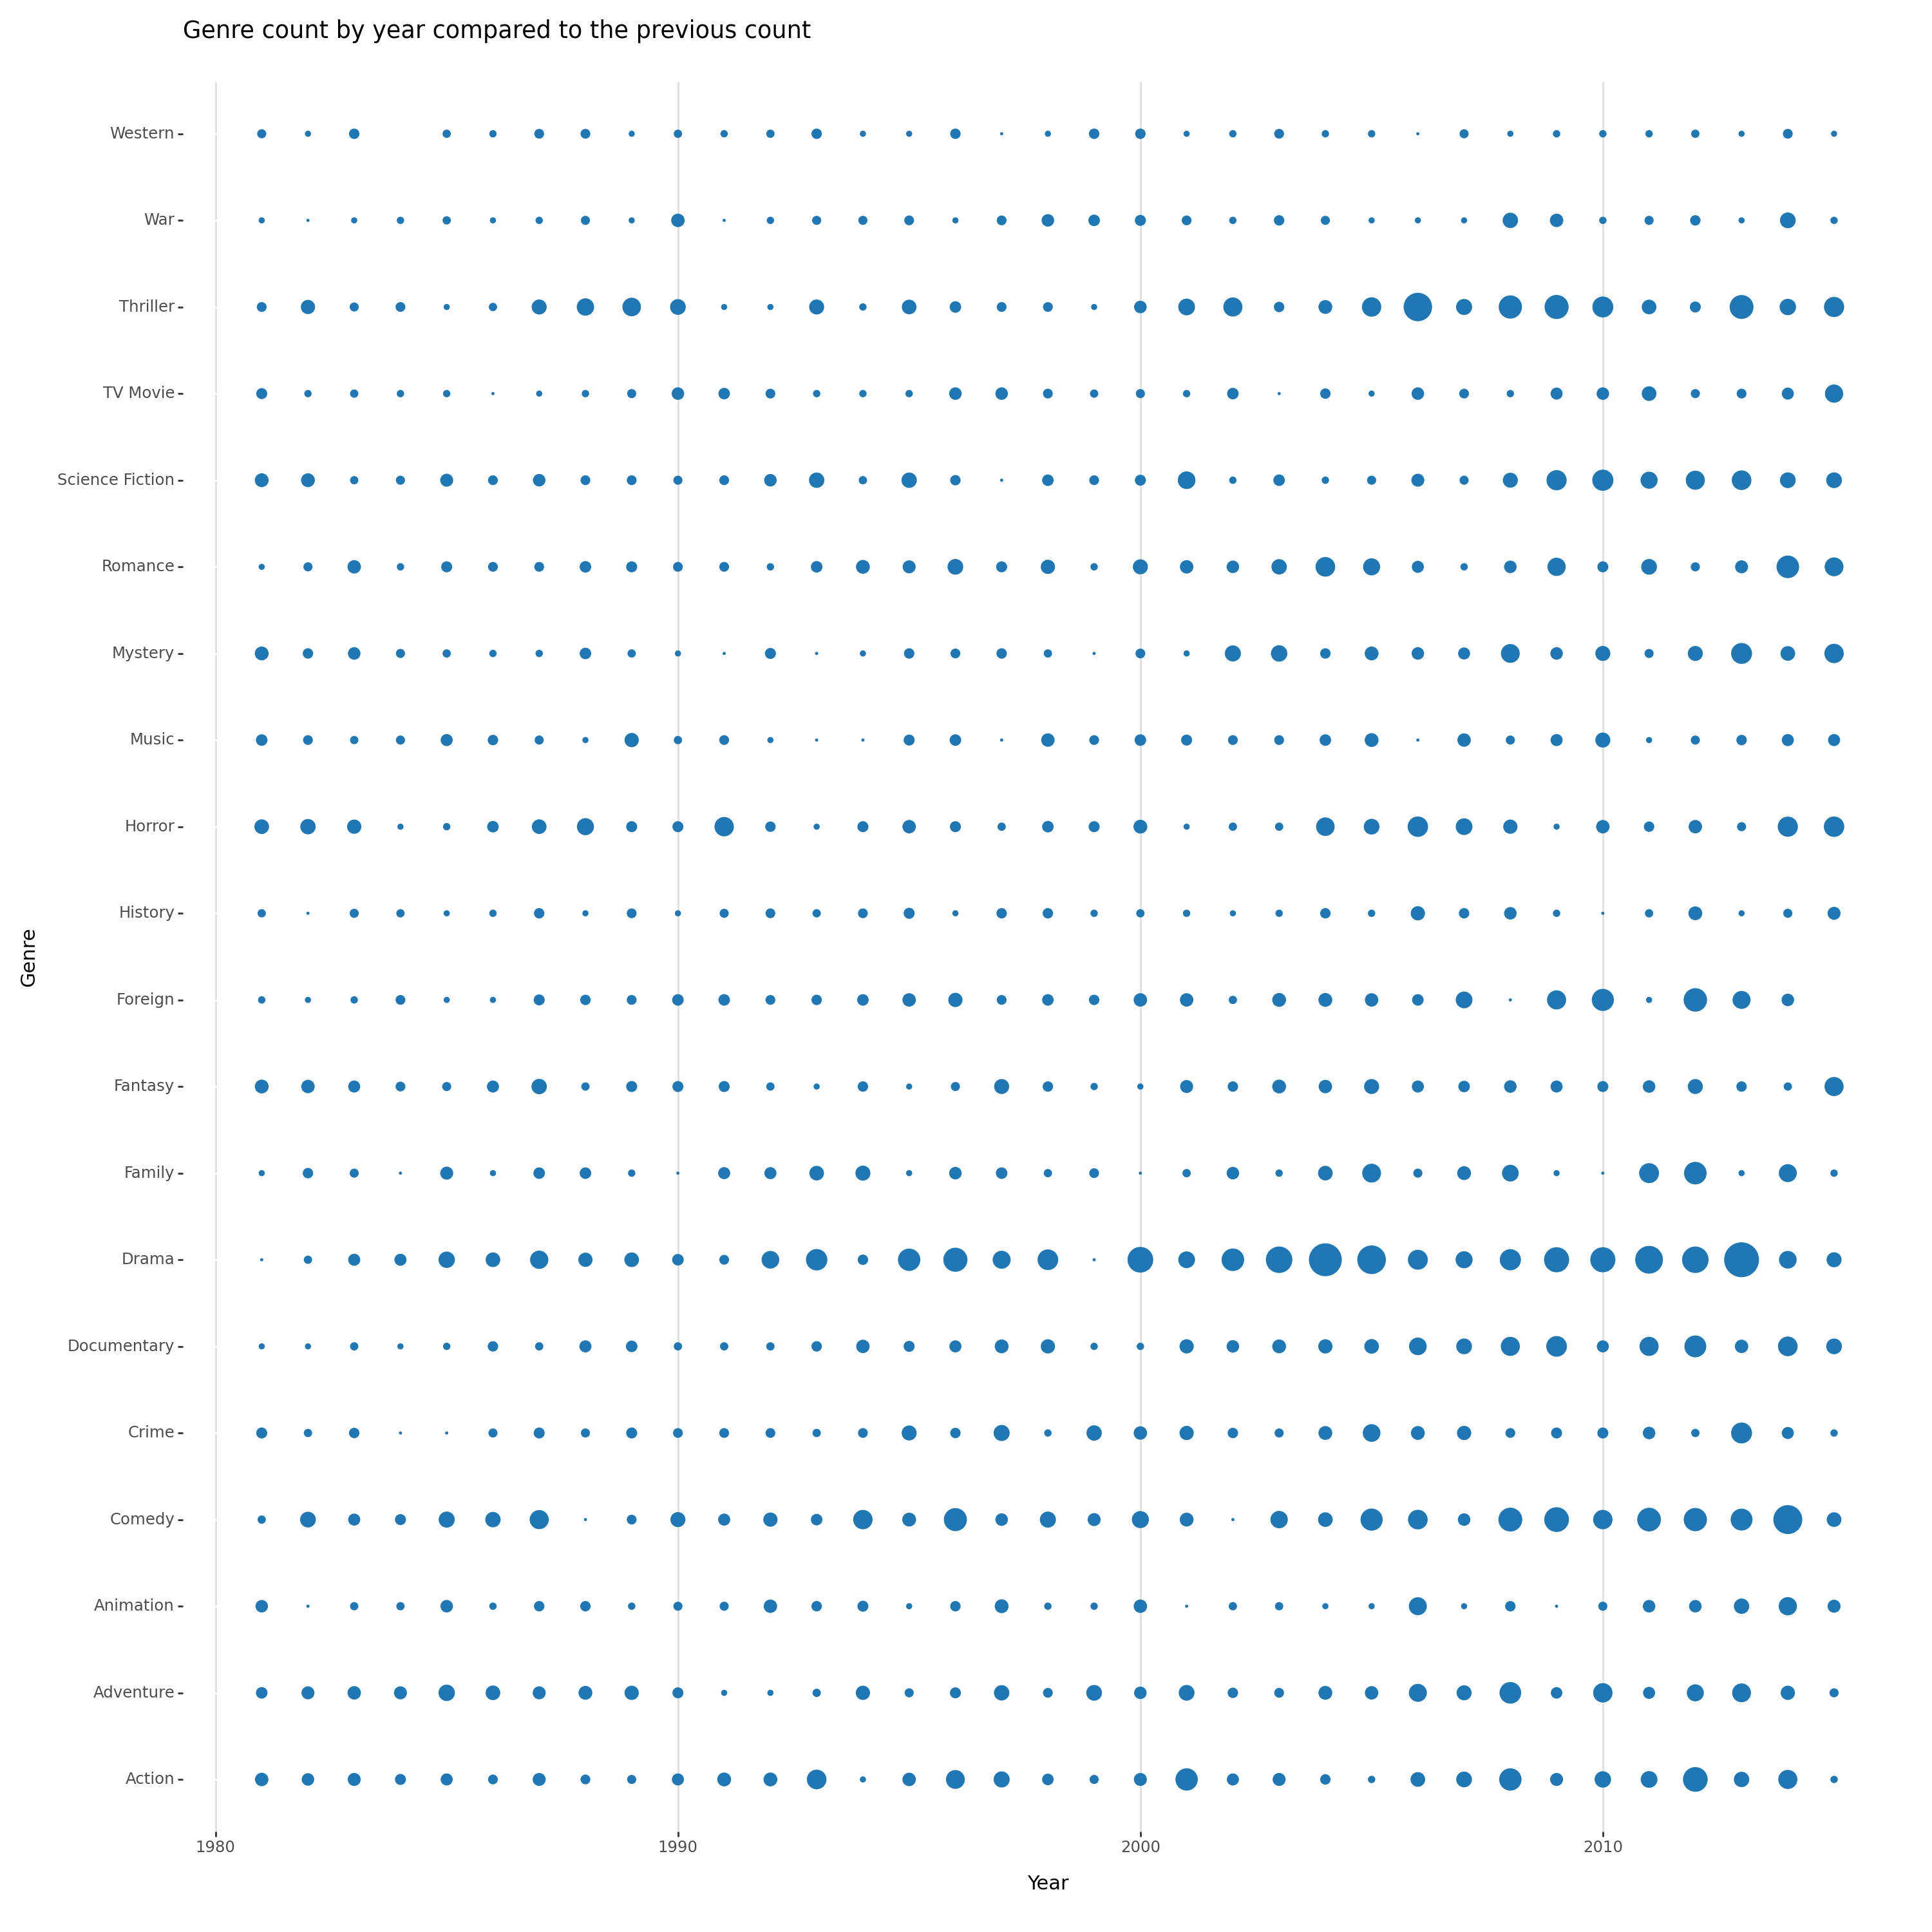

In [25]:
# Genre count by year re-expression

df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = (
    df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
)
df_genres_count = df_genres_count.sort_values(
    by=["genres", "release_year"], ascending=True
)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count["count"].abs()
df_genres_count["count"] = df_genres_count["count"] / df_genres_count["count"].max()
df_genres_count["count"] = df_genres_count["count"] * 100

p = (
    p9.ggplot(df_genres_count, p9.aes("release_year", "genres", size="count"))
    + p9.geom_point(fill="#1f77b4", color="#1f77b4")
    + p9.labs(
        x="Year", y="Genre", title="Genre count by year compared to the previous count"
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.theme(
        figure_size=(15, 15),
        legend_position="none",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major_x=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


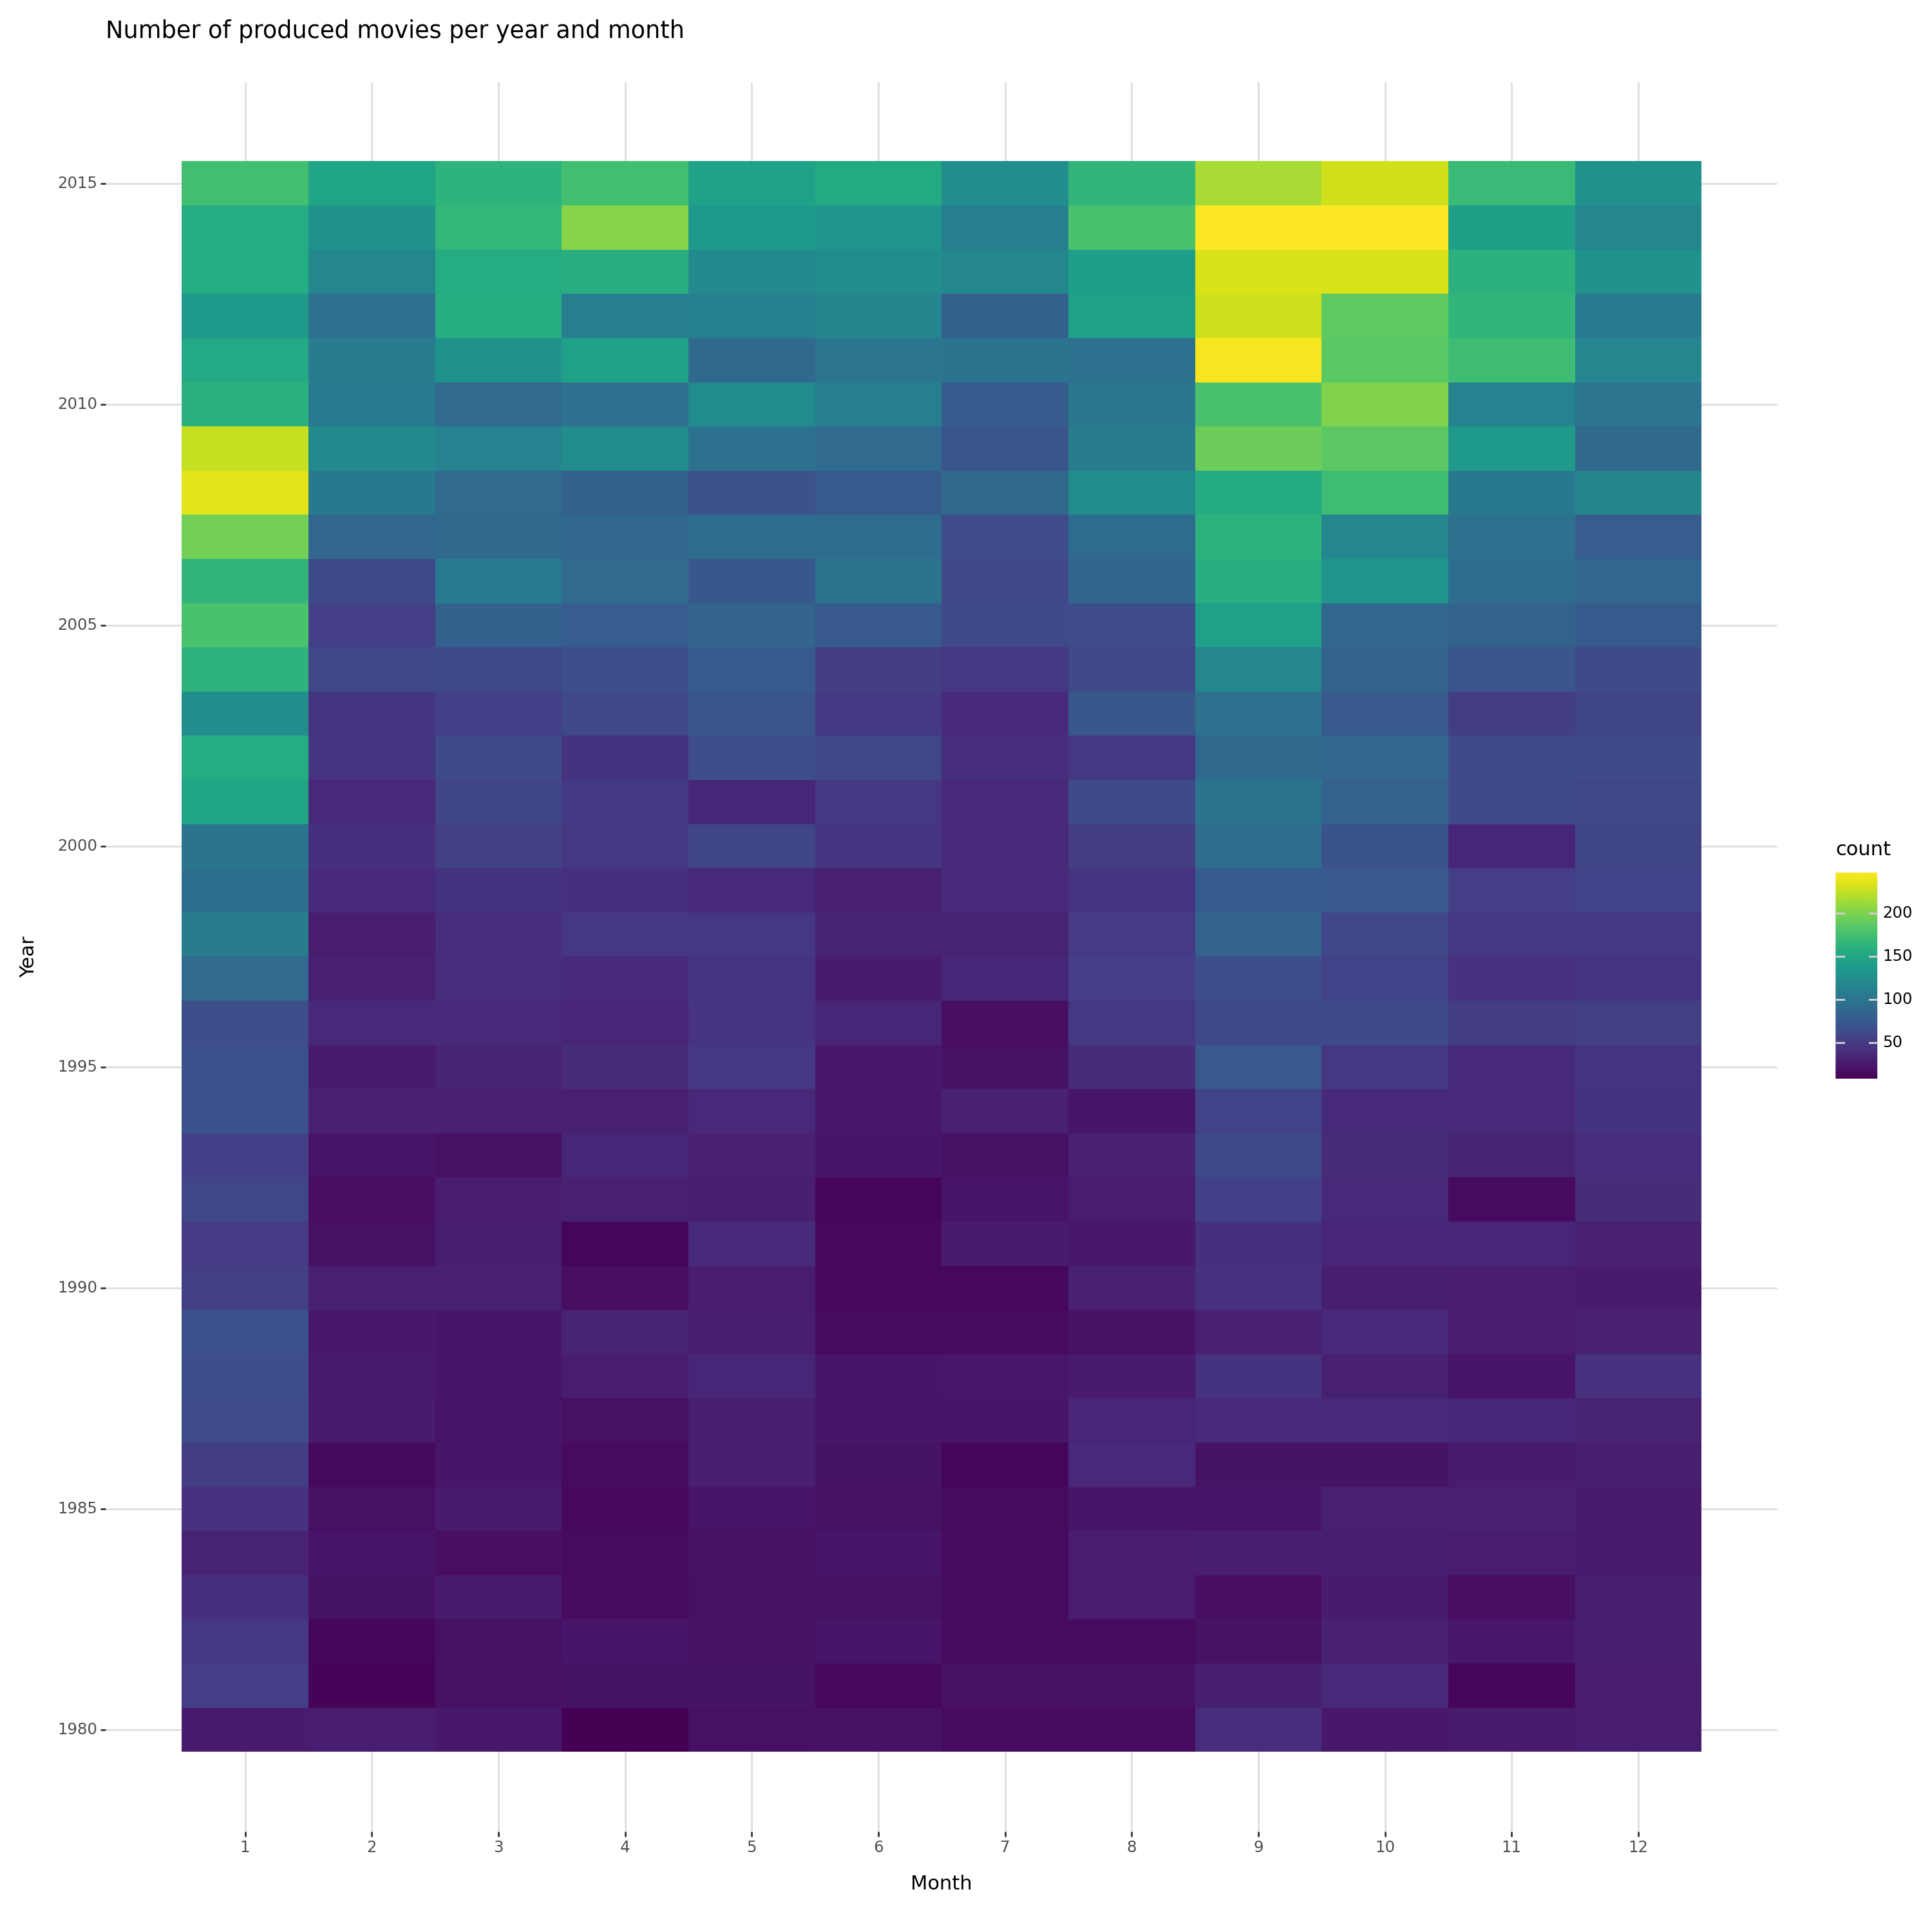

In [26]:
# Number of produced movies per year and month as tiles.
df_year_month_count = (
    df_main.groupby(["release_year", "release_month"]).size().reset_index(name="count")
)
df_year_month_count = df_year_month_count.sort_values(
    by=["release_year", "release_month"], ascending=True
)
df_year_month_count["count"] = df_year_month_count["count"].astype(int)

p = (
    p9.ggplot(
        df_year_month_count, p9.aes("release_month", "release_year", fill="count")
    )
    + p9.geom_tile()
    + p9.labs(x="Month", y="Year", title="Number of produced movies per year and month")
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    + p9.scale_x_continuous(breaks=range(1, 13))
    + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


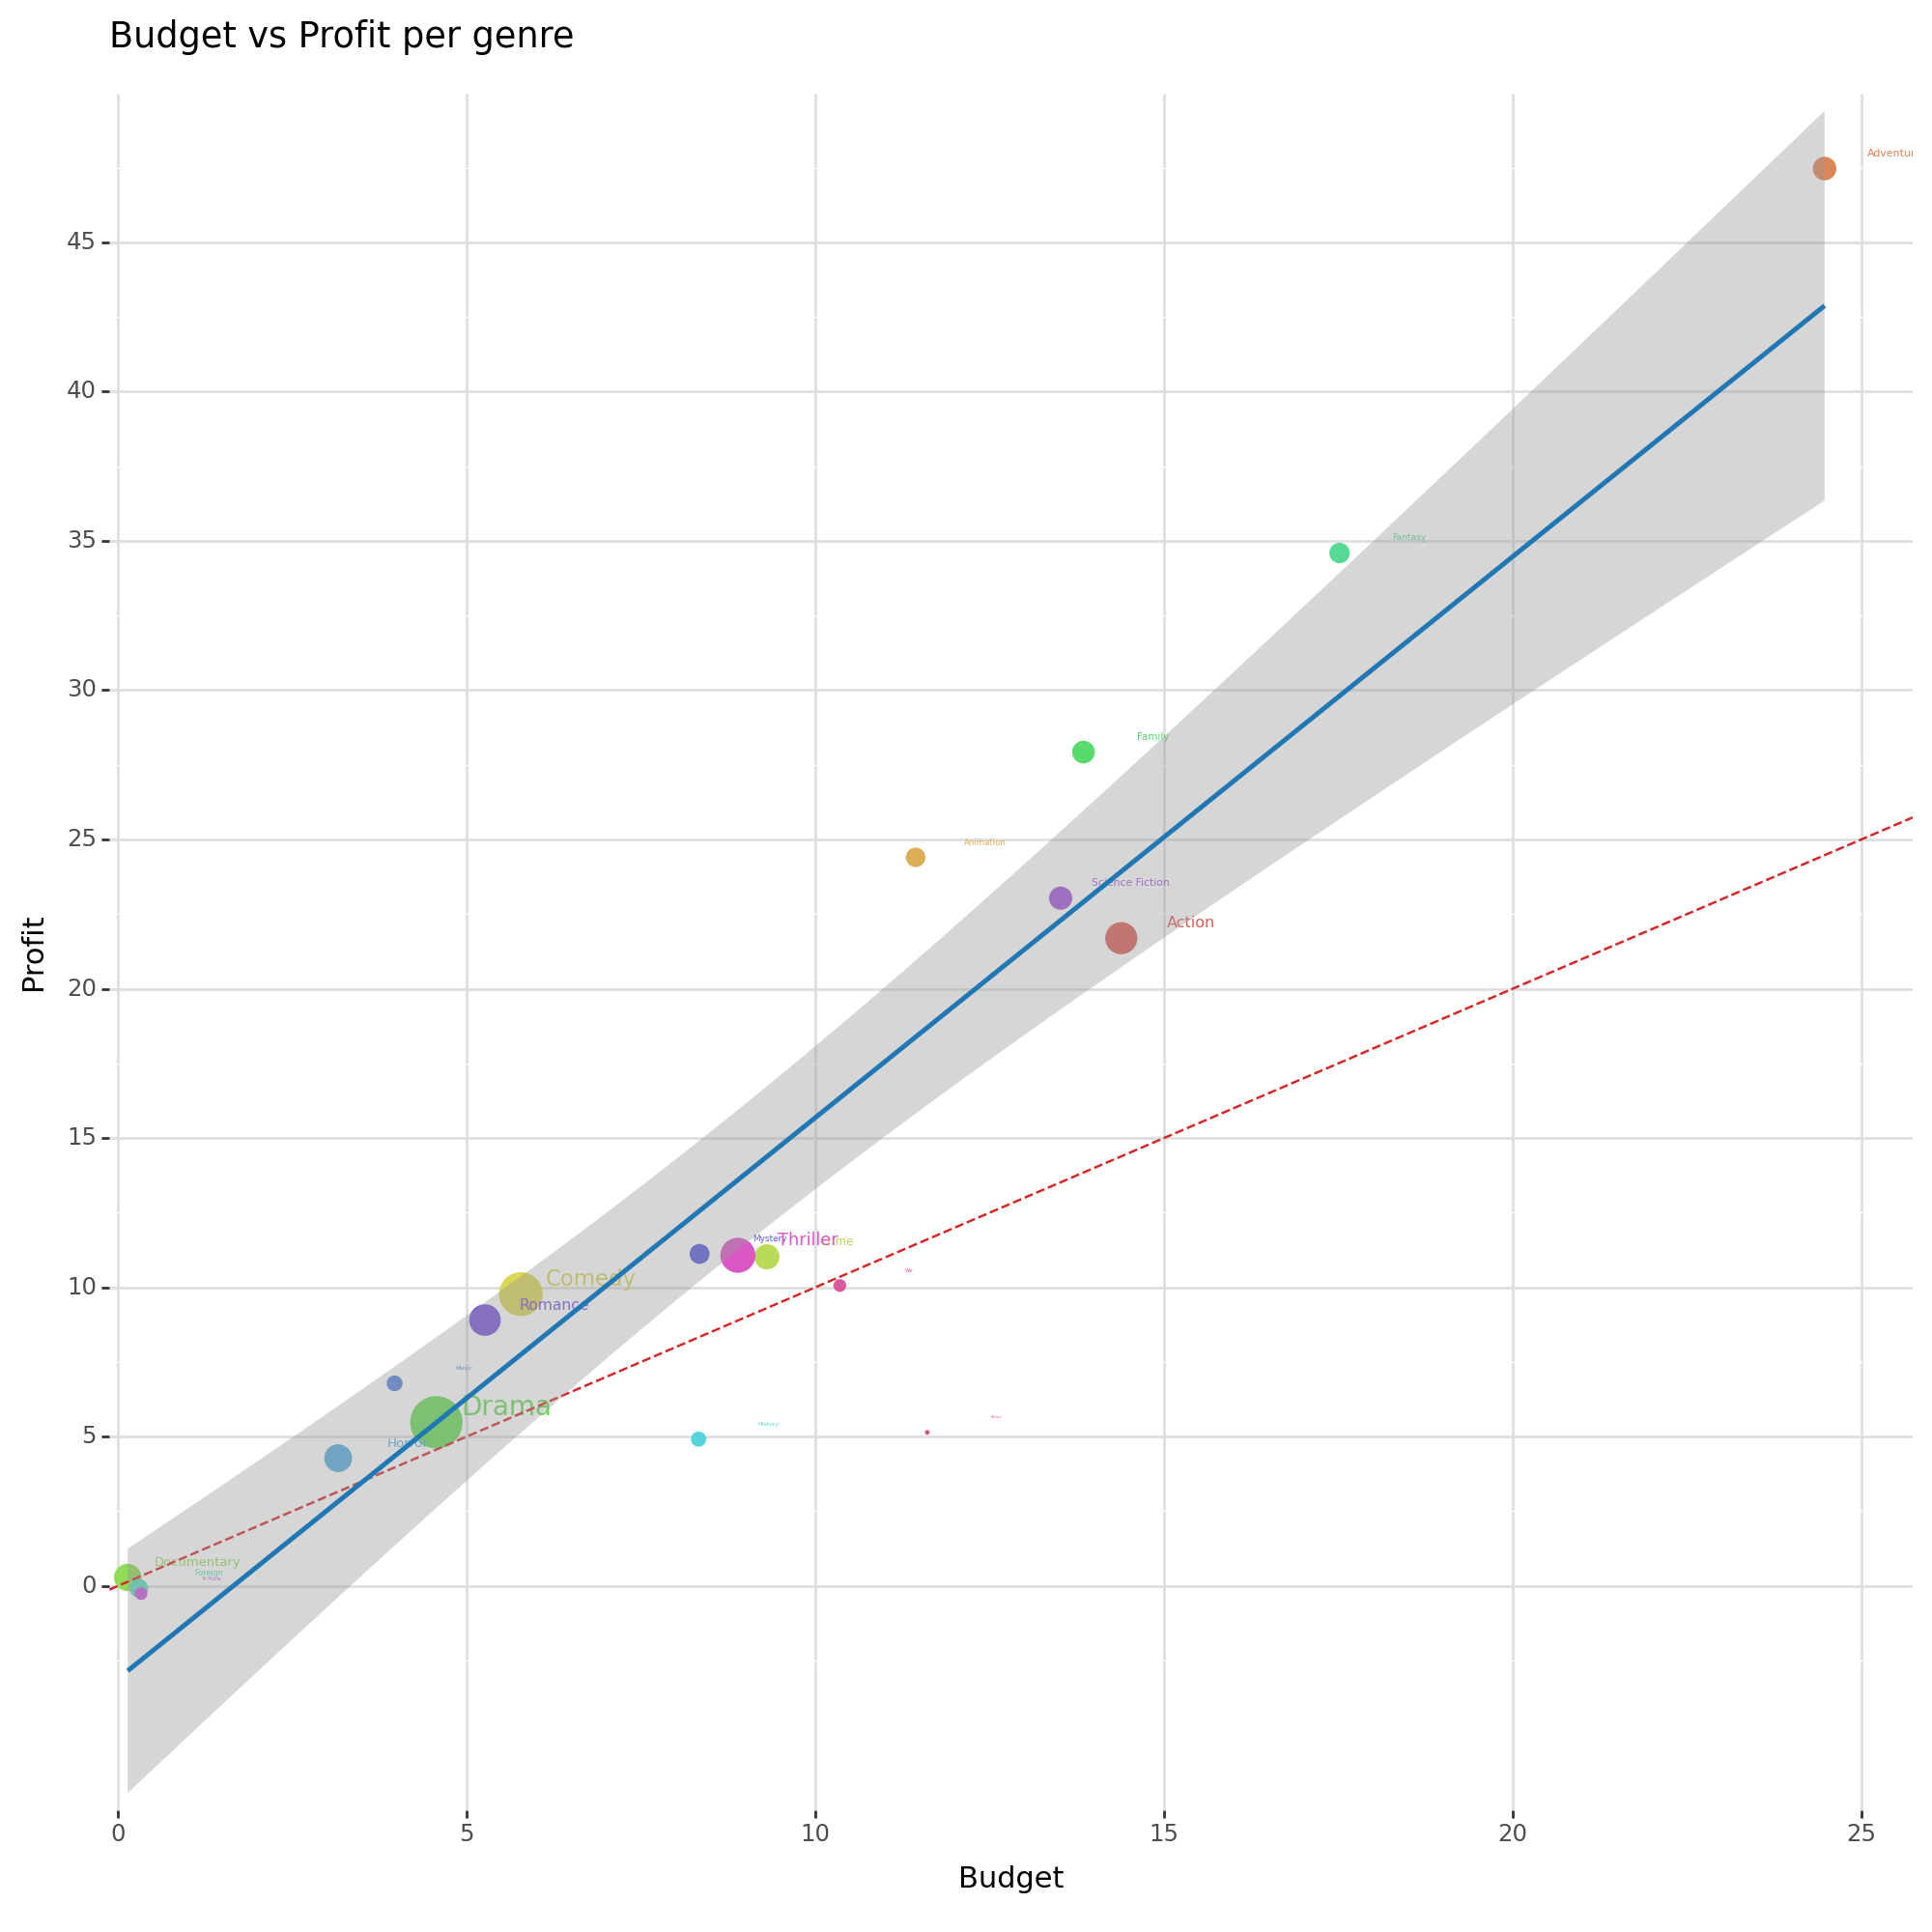

In [27]:
# For each genre we need to calculate the average budget, revenue and how many movies were produced.
# In the plot, the x-axis will be the budget, the y axis the profit, the size of the bubble will be the number of movies produced and the color will be the genre.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()

df_genres = (
    df_genres.groupby("genres")
    .agg(
        {
            "budget": "mean",
            "revenue": "mean",
            "id": "count",
        }
    )
    .reset_index()
)

df_genres["profit"] = df_genres["revenue"] - df_genres["budget"]
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["revenue"] = df_genres["revenue"] / 1000000
df_genres["profit"] = df_genres["profit"] / 1000000

p = (
    p9.ggplot(df_genres, p9.aes("budget", "profit", size="id", color="genres"))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit per genre")
    + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.geom_text(p9.aes(label="genres"), nudge_x=1, nudge_y=0.5)
    + p9.geom_abline(
        intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True
    )
    + p9.geom_smooth(
        method="lm", color="#1f77b4", se=True, show_legend=True, fullrange=True
    )
    + p9.guides(size=False, color=False)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


         main_genre     budget    revenue    id     profit
0            Action  13.190496  31.116061  3212  17.925565
1         Adventure  26.038898  76.297938   977  50.259040
2         Animation  11.018235  35.706327   882  24.688092
3            Comedy   4.252397  11.292584  6249   7.040187
4             Crime   6.731800  12.928008   950   6.196207
5       Documentary   0.105024   0.358402  2905   0.253377
6             Drama   3.547967   7.640406  8301   4.092439
7            Family   6.842006  24.320953   405  17.478947
8           Fantasy  12.682148  35.067233   532  22.385084
9           Foreign   0.138632   0.344264    75   0.205633
10          History   4.572945   9.547579   178   4.974634
11           Horror   2.647479   7.364838  1934   4.717360
12            Music   2.717228   5.608343   303   2.891115
13          Mystery   4.249960  10.035709   321   5.785749
14          Romance   3.618852  11.633157   763   8.014305
15  Science Fiction  11.189196  35.243147   460  24.0539

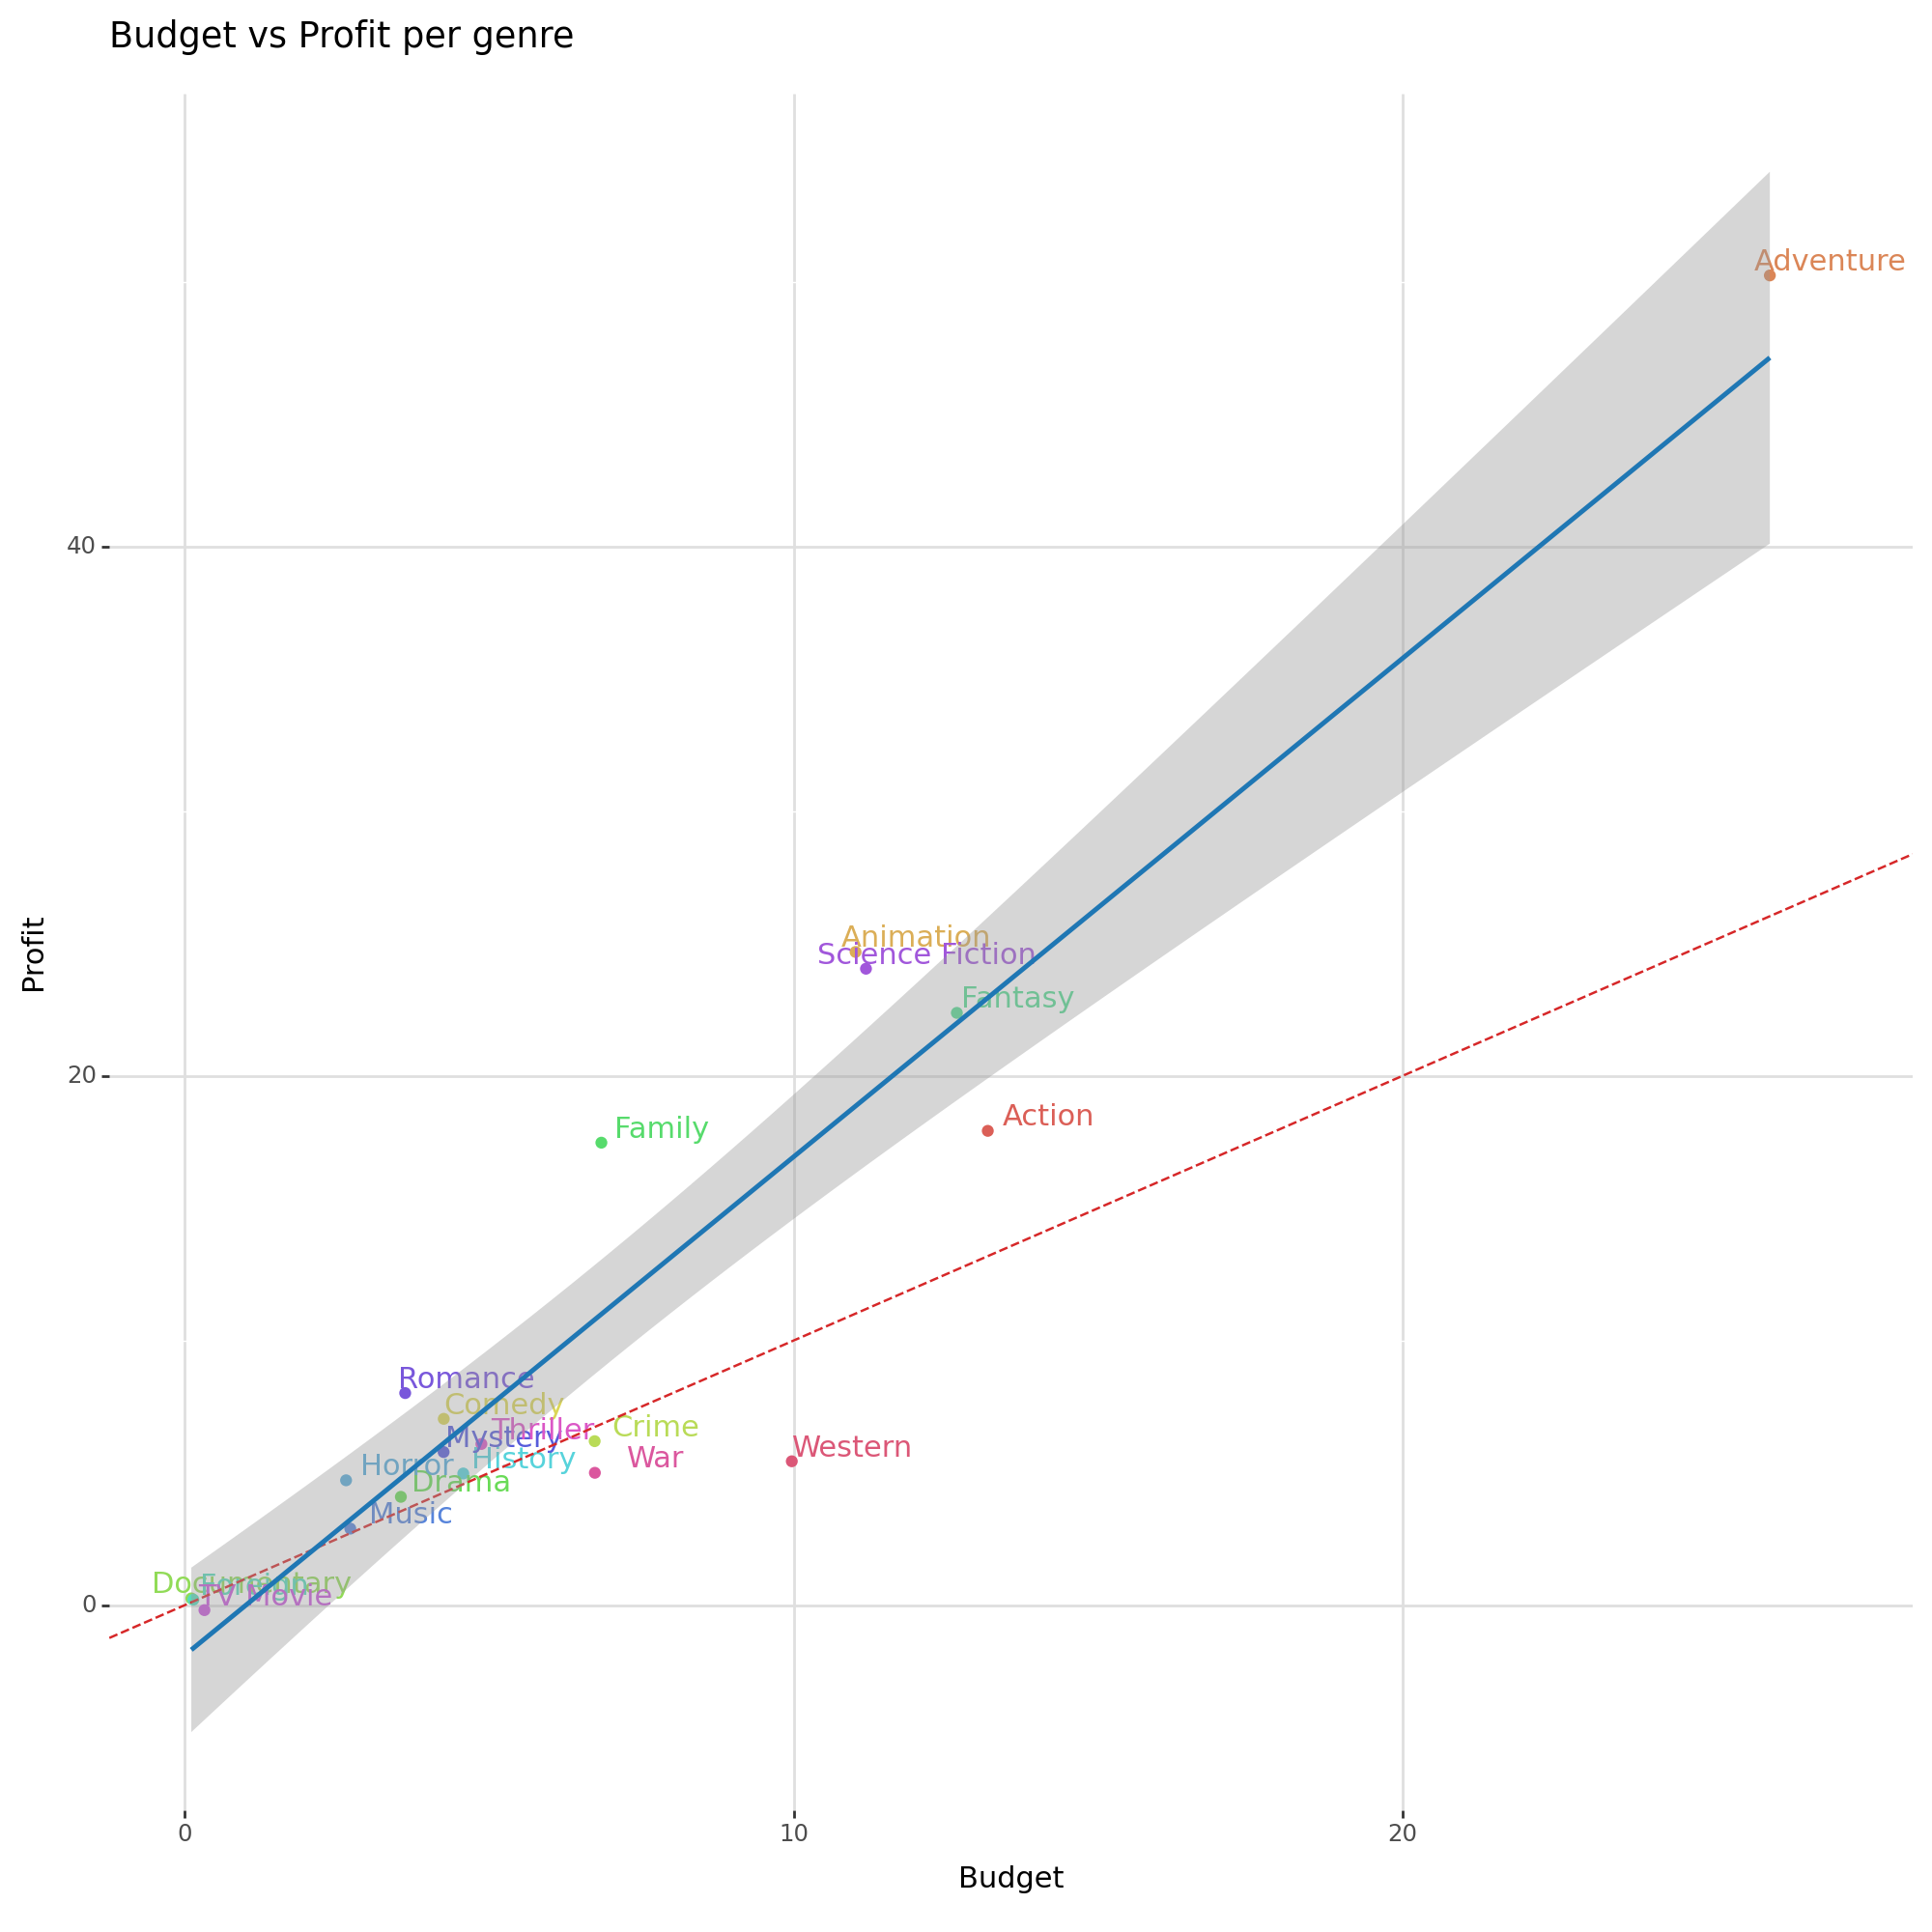

In [28]:
df_genres = (
    df_main.groupby("main_genre")
    .agg(
        {
            "budget": "mean",
            "revenue": "mean",
            "id": "count",
        }
    )
    .reset_index()
)

df_genres["profit"] = df_genres["revenue"] - df_genres["budget"]
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["revenue"] = df_genres["revenue"] / 1000000
df_genres["profit"] = df_genres["profit"] / 1000000

print(df_genres)

p = (
    p9.ggplot(df_genres, p9.aes("budget", "profit", color="main_genre"))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit per genre")
    # + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    # + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.geom_text(p9.aes(label="main_genre"), nudge_x=1, nudge_y=0.5)
    + p9.geom_abline(
        intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True
    )
    + p9.geom_smooth(
        method="lm", color="#1f77b4", se=True, show_legend=True, fullrange=True
    )
    + p9.guides(size=False, color=False)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


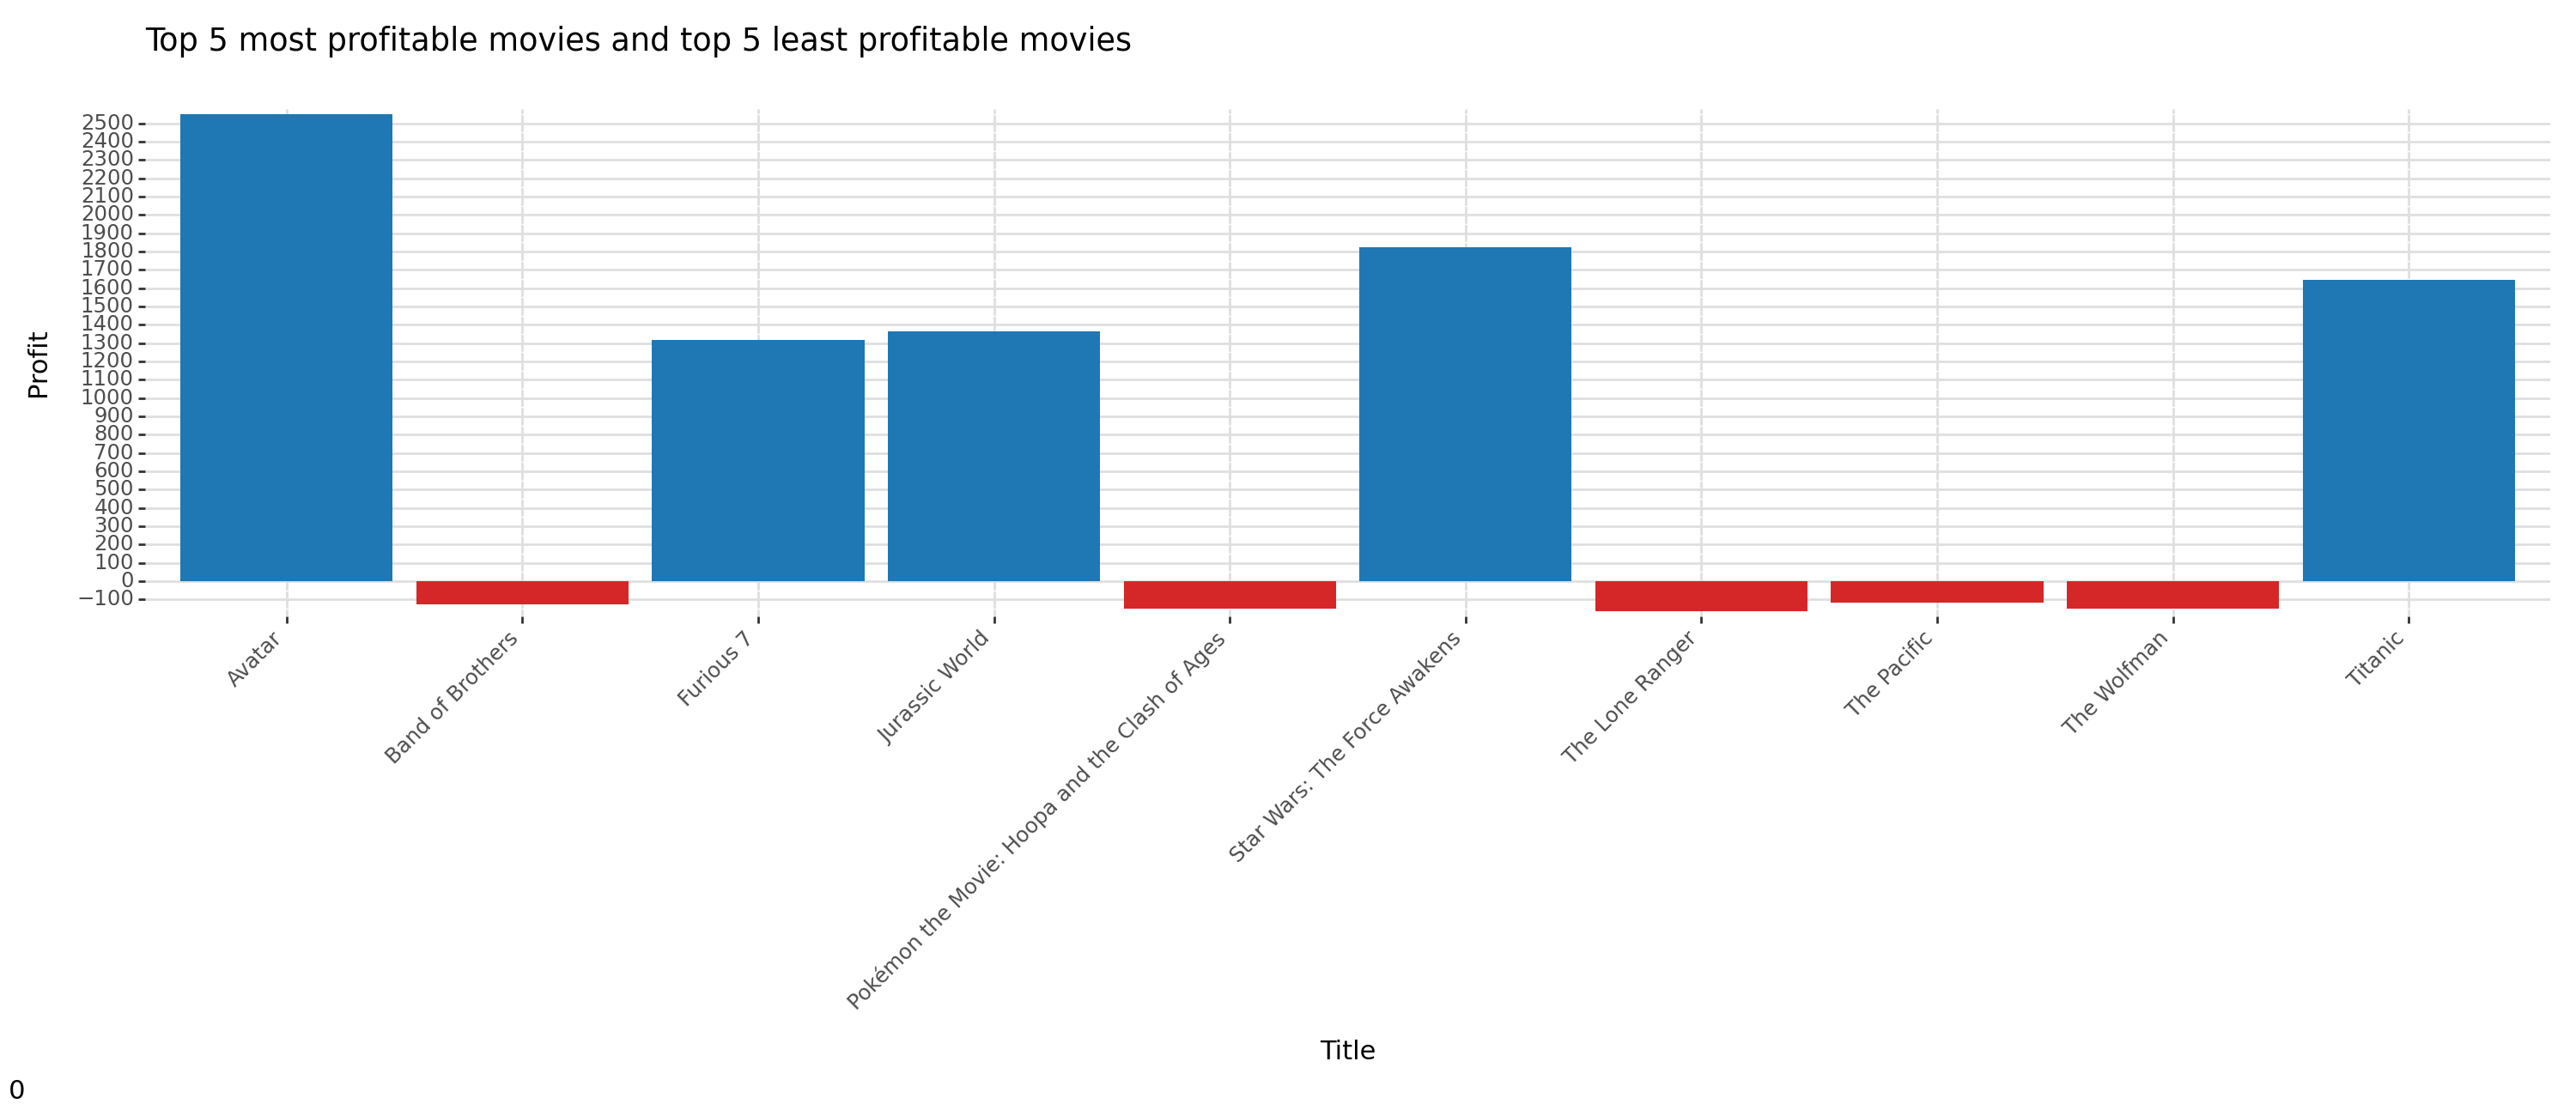

In [29]:
# Top 5 most profitable movies and top 5 least profitable movies in a single table.
df_profitable = df_main.copy()
# Round revenue and budget to nearest million
df_profitable["revenue"] = df_profitable["revenue"] / 1000000
df_profitable["revenue"] = df_profitable["revenue"].round()
df_profitable["budget"] = df_profitable["budget"] / 1000000
df_profitable["budget"] = df_profitable["budget"].round()
df_profitable["profit"] = df_profitable["revenue"] - df_profitable["budget"]
df_profitable = df_profitable.sort_values(by="profit", ascending=False)
df_most_profitable = df_profitable[["title", "release_year", "genres", "budget", "revenue", "profit"]].head(5)
df_least_profitable = df_profitable[["title", "release_year", "genres", "budget", "revenue", "profit"]].tail(5)
df_top_and_bottom = pd.concat([df_most_profitable, df_least_profitable])


# Plot the top 5 most profitable movies and top 5 least profitable movies in a single plot.
# Color the bars blue if the movie is profitable and red if it is not.
# Show the title of the movie on the x-axis and the profit on the y-axis.
# The y-axis should have 10m increments.

p = (
    p9.ggplot(df_top_and_bottom, p9.aes("title", "profit", fill="profit > 0"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Profit", title="Top 5 most profitable movies and top 5 least profitable movies")
    + p9.scale_y_continuous(breaks=range(-1000, 3000, 100), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#d62728", "#1f77b4"])
    + p9.theme(
        figure_size=(15, 6.5),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


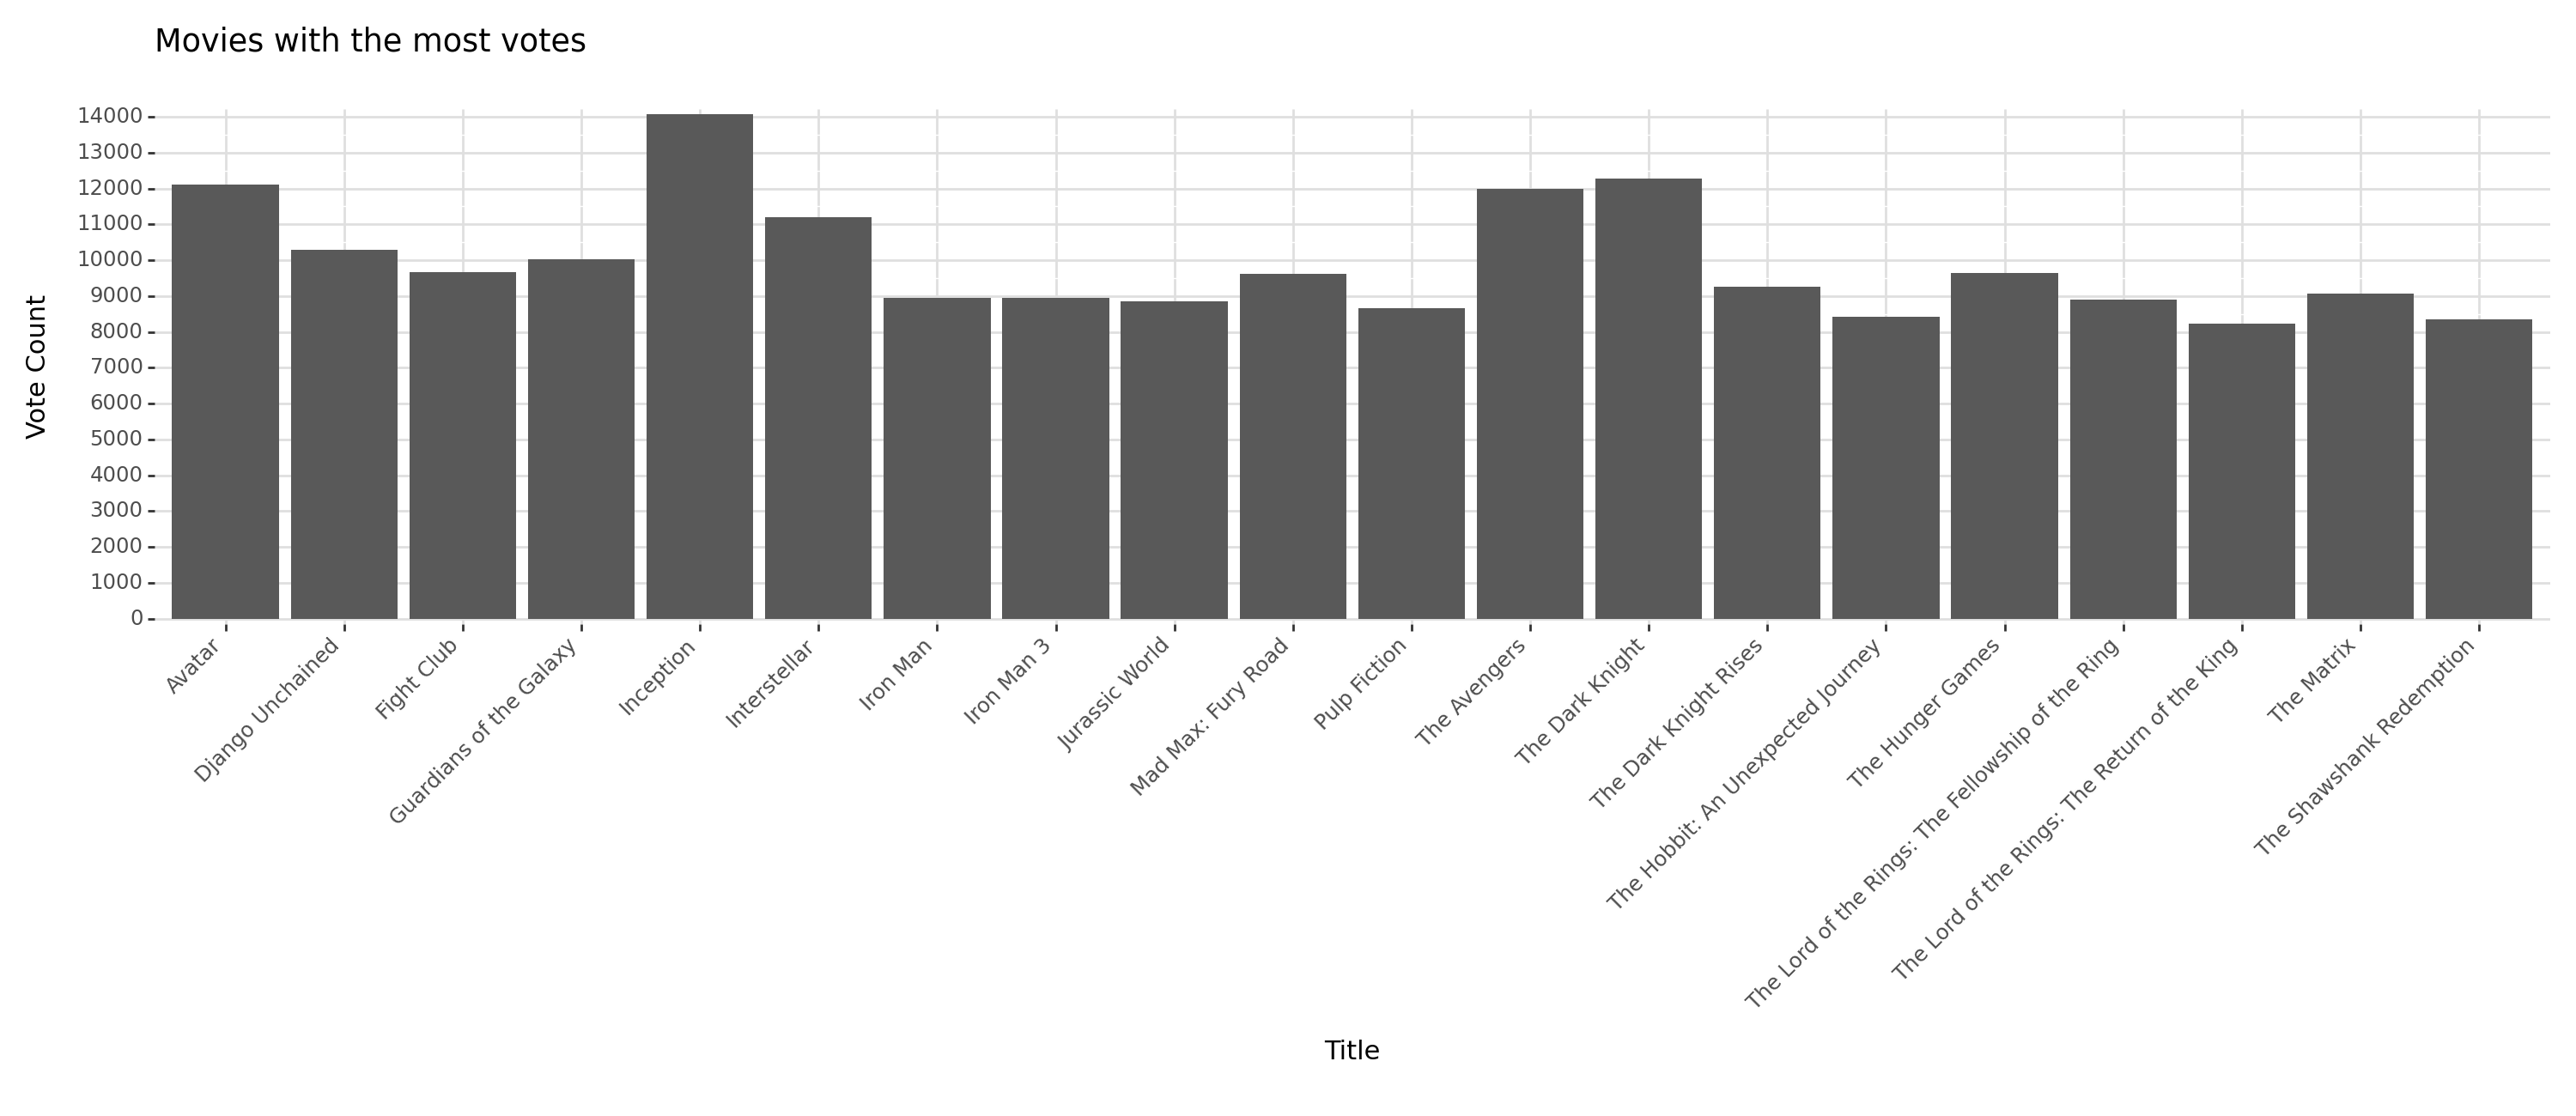

In [30]:
#SHow me as a bar chart the movies with the most votes
df_votes = df_main.copy()
df_votes = df_votes.sort_values(by="vote_count", ascending=False)
df_votes = df_votes[["title", "release_year", "genres", "vote_count"]].head(20)

p = (
    p9.ggplot(df_votes, p9.aes("title", "vote_count"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Vote Count", title="Movies with the most votes")
    + p9.scale_y_continuous(breaks=range(0, 20000, 1000), expand=(0.01, 0.01))
    + p9.theme(
        figure_size=(15, 6.5),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


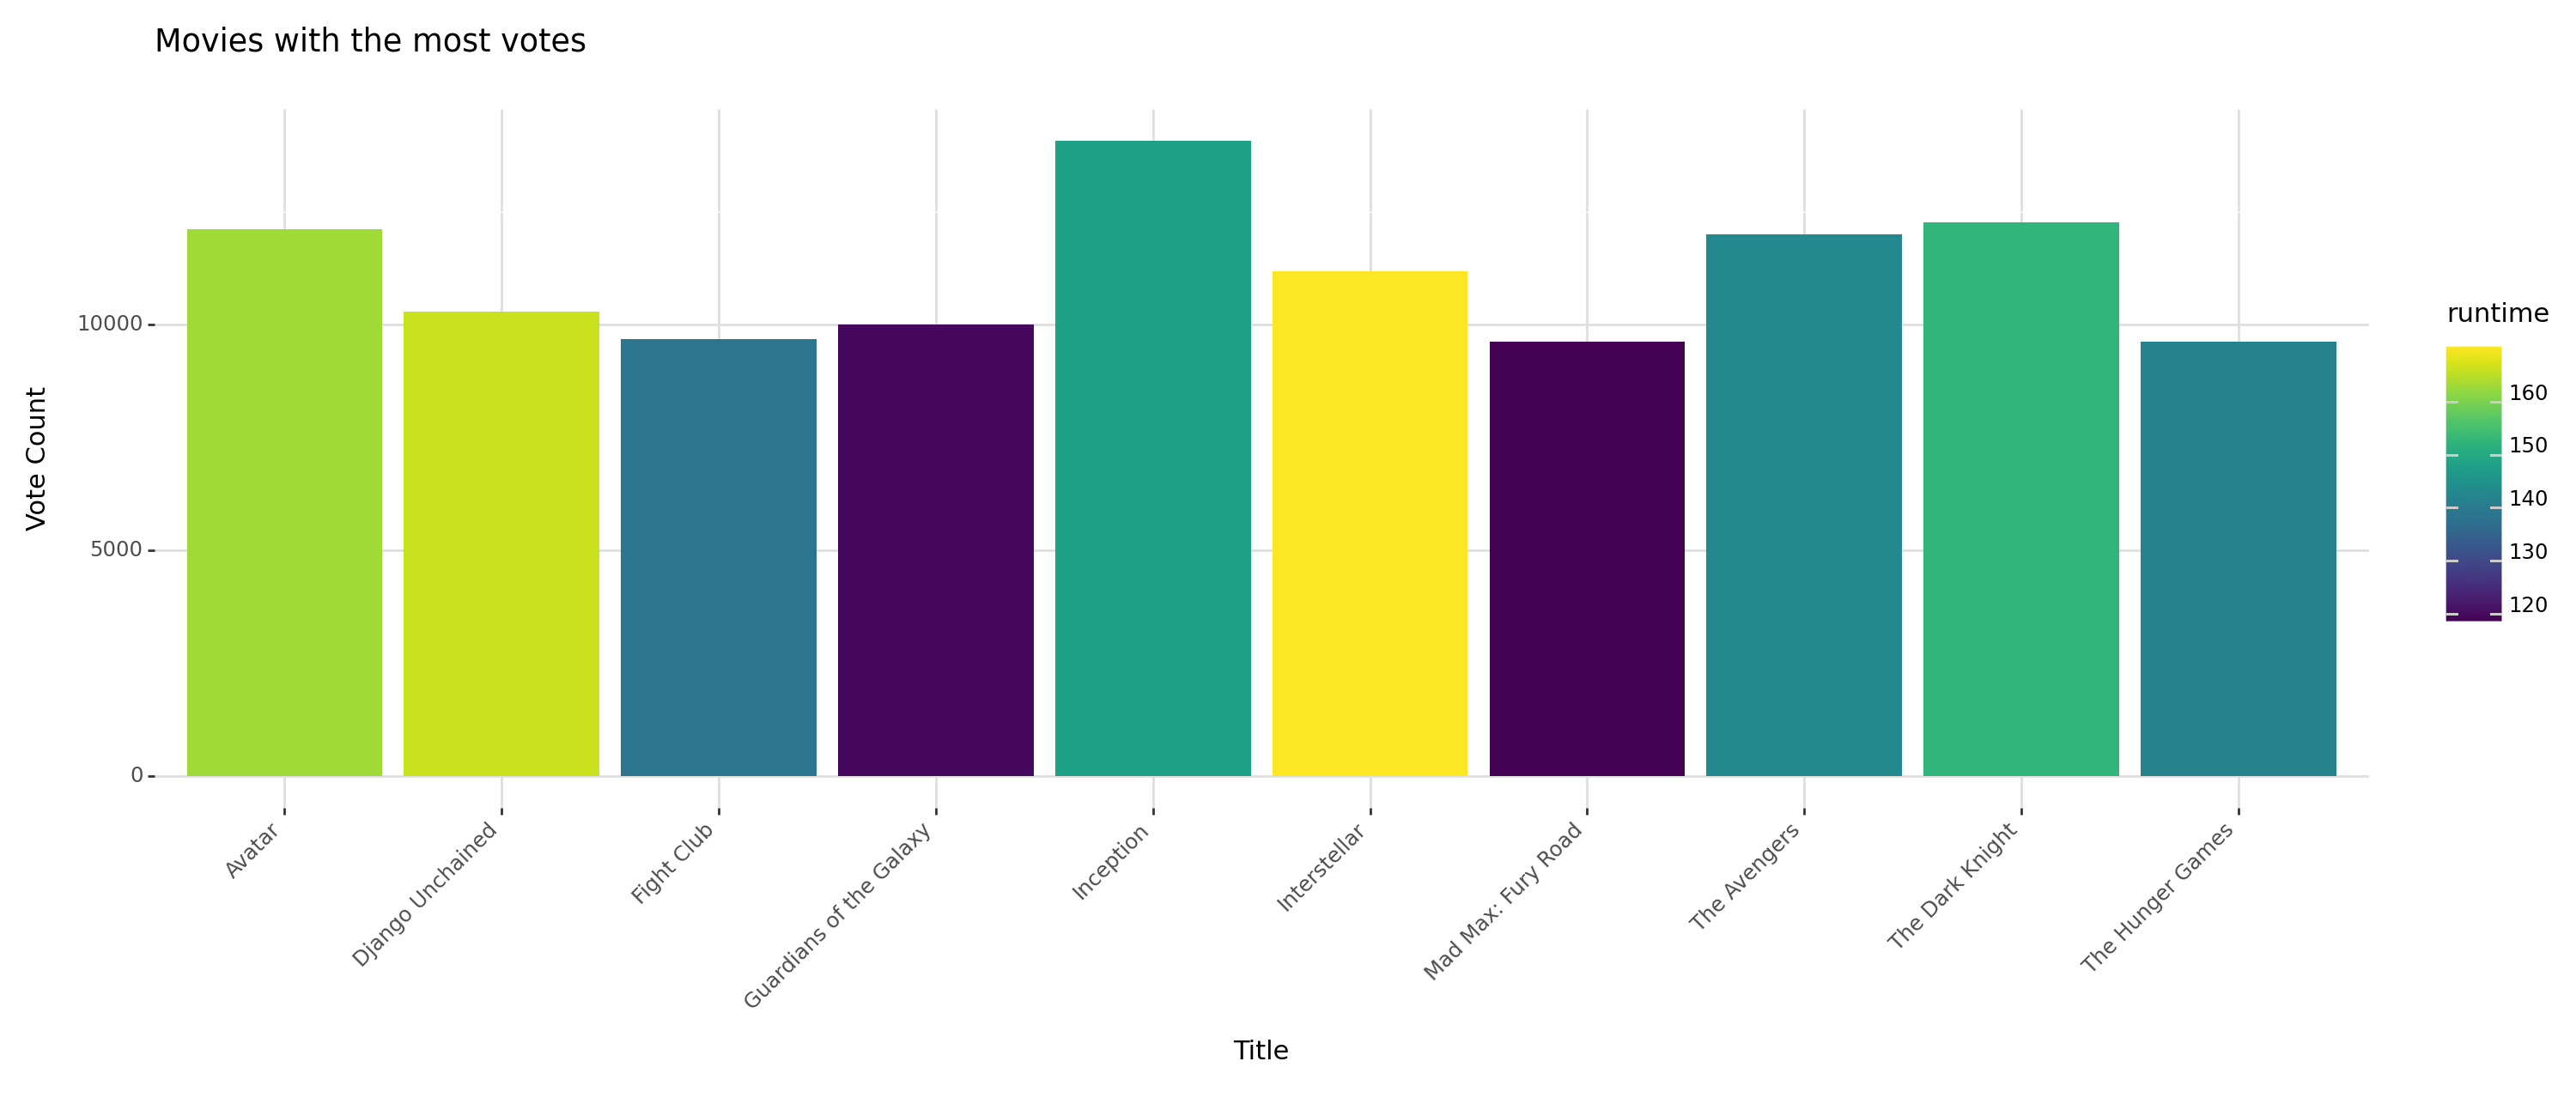

In [31]:
#Make a bar chart with top 10 movies with most votes and their runtime. Color the bars by runtime and make a legend for the colors.

df_votes = df_main.copy()
df_votes = df_votes.sort_values(by="vote_count", ascending=False)
df_votes = df_votes[["title", "release_year", "genres", "vote_count", "runtime"]].head(10)

p = (
    p9.ggplot(df_votes, p9.aes("title", "vote_count", fill="runtime"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Vote Count", title="Movies with the most votes")
    # + p9.scale_y_continuous(breaks=range(0, 20000, 1000), expand=(0.01, 0.01))
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


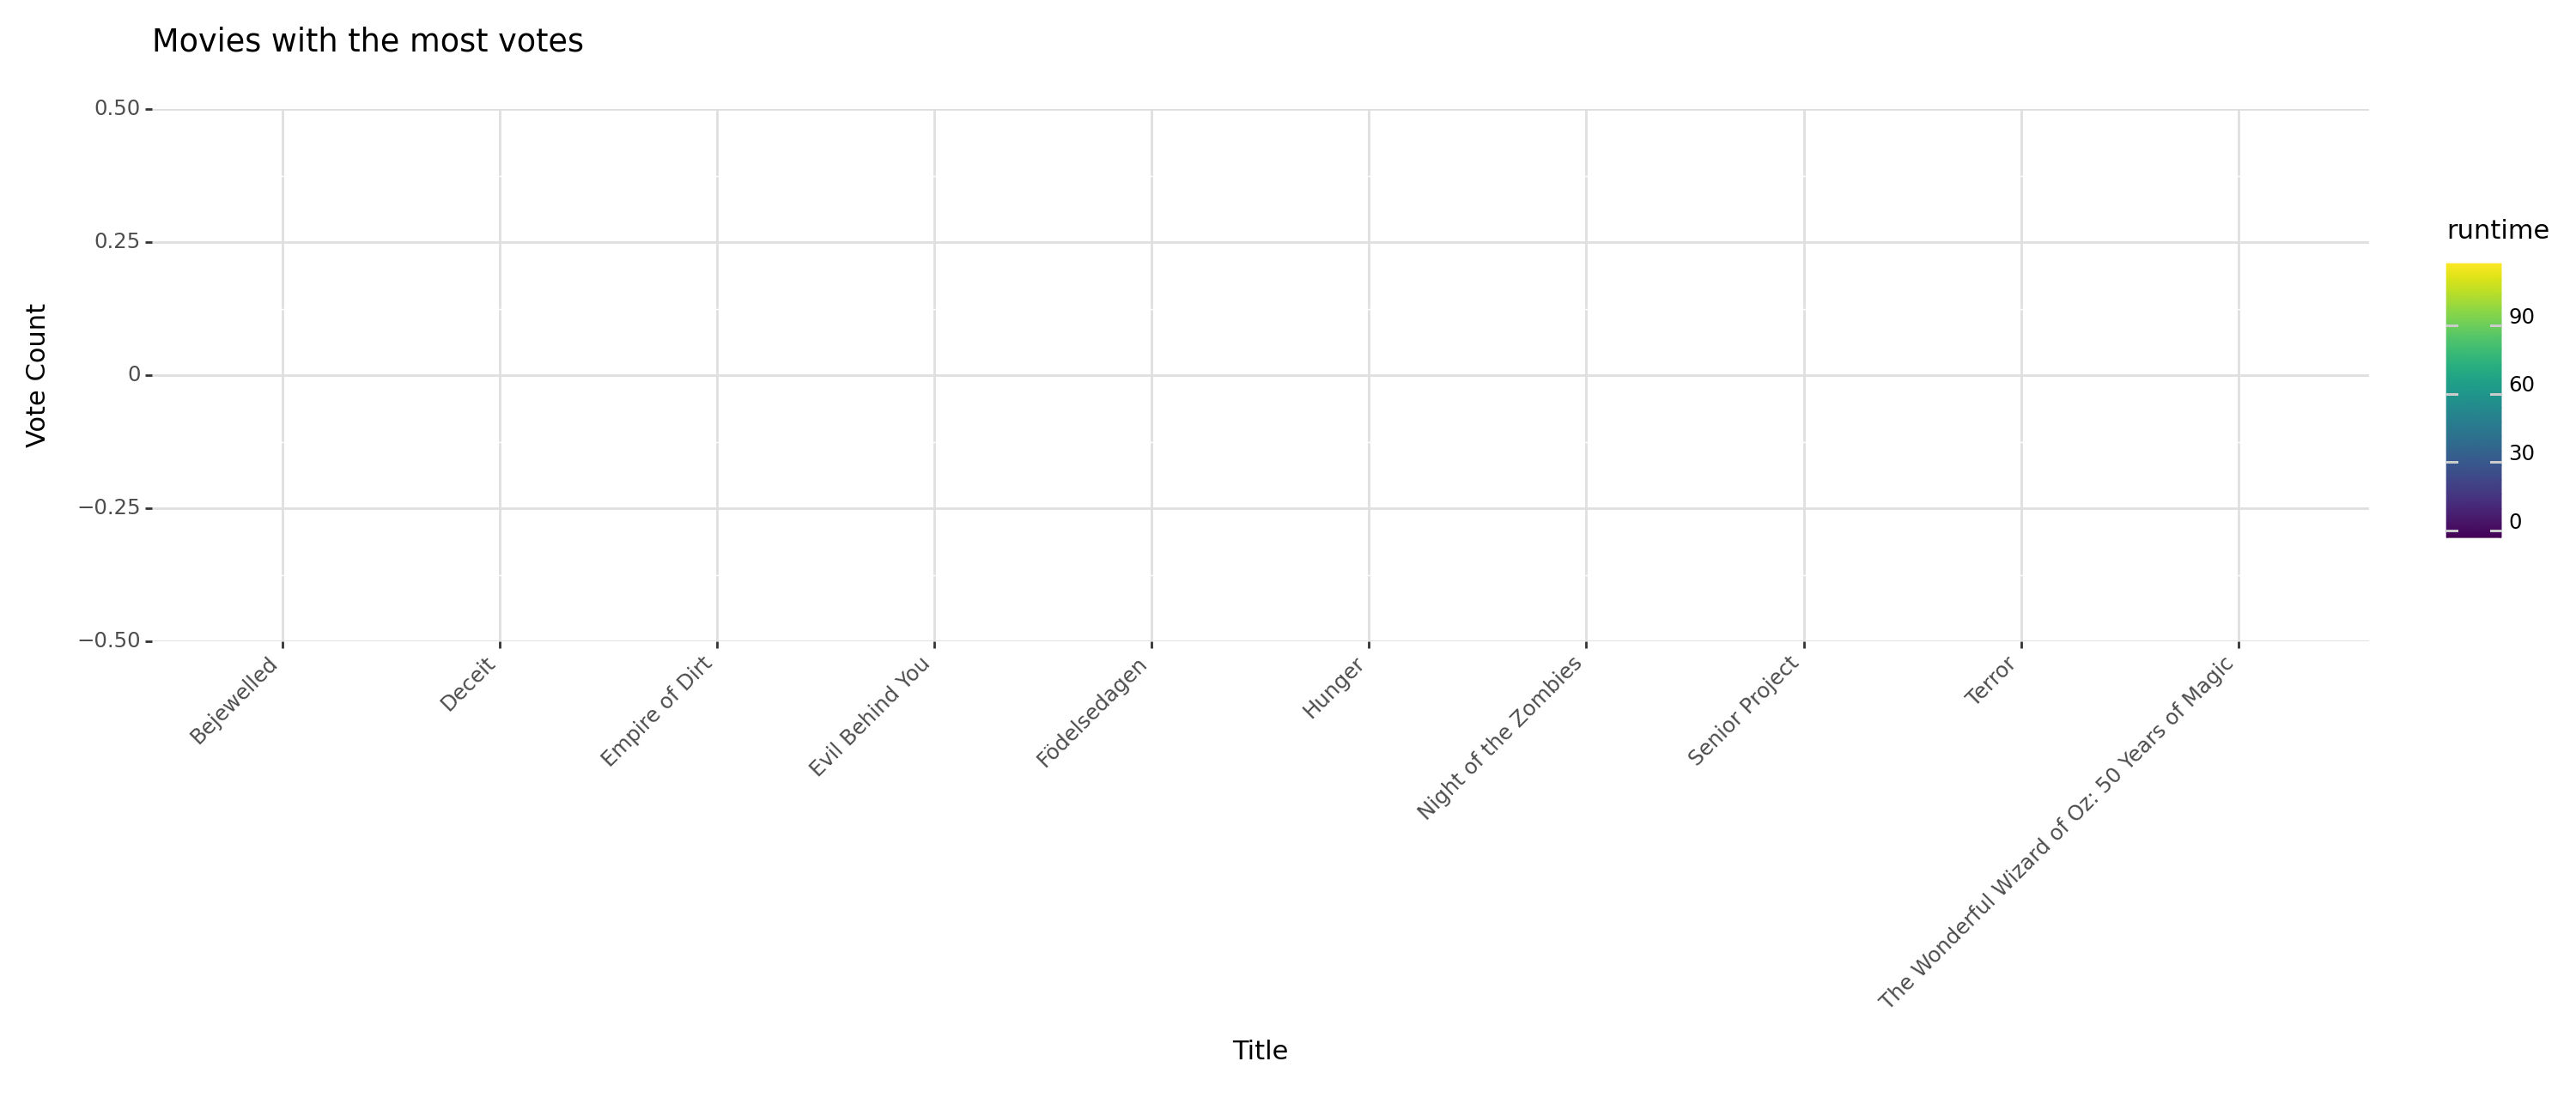

In [32]:
#Make a bar chart with top 10 movies with least votes and their runtime. Color the bars by runtime and make a legend for the colors.

df_votes = df_main.copy()
df_votes = df_votes.sort_values(by="vote_count", ascending=True)
df_votes = df_votes[["title", "release_year", "genres", "vote_count", "runtime"]].head(10)

p = (
    p9.ggplot(df_votes, p9.aes("title", "vote_count", fill="runtime"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Vote Count", title="Movies with the most votes")
    # + p9.scale_y_continuous(breaks=range(0, 20000, 1000), expand=(0.01, 0.01))
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


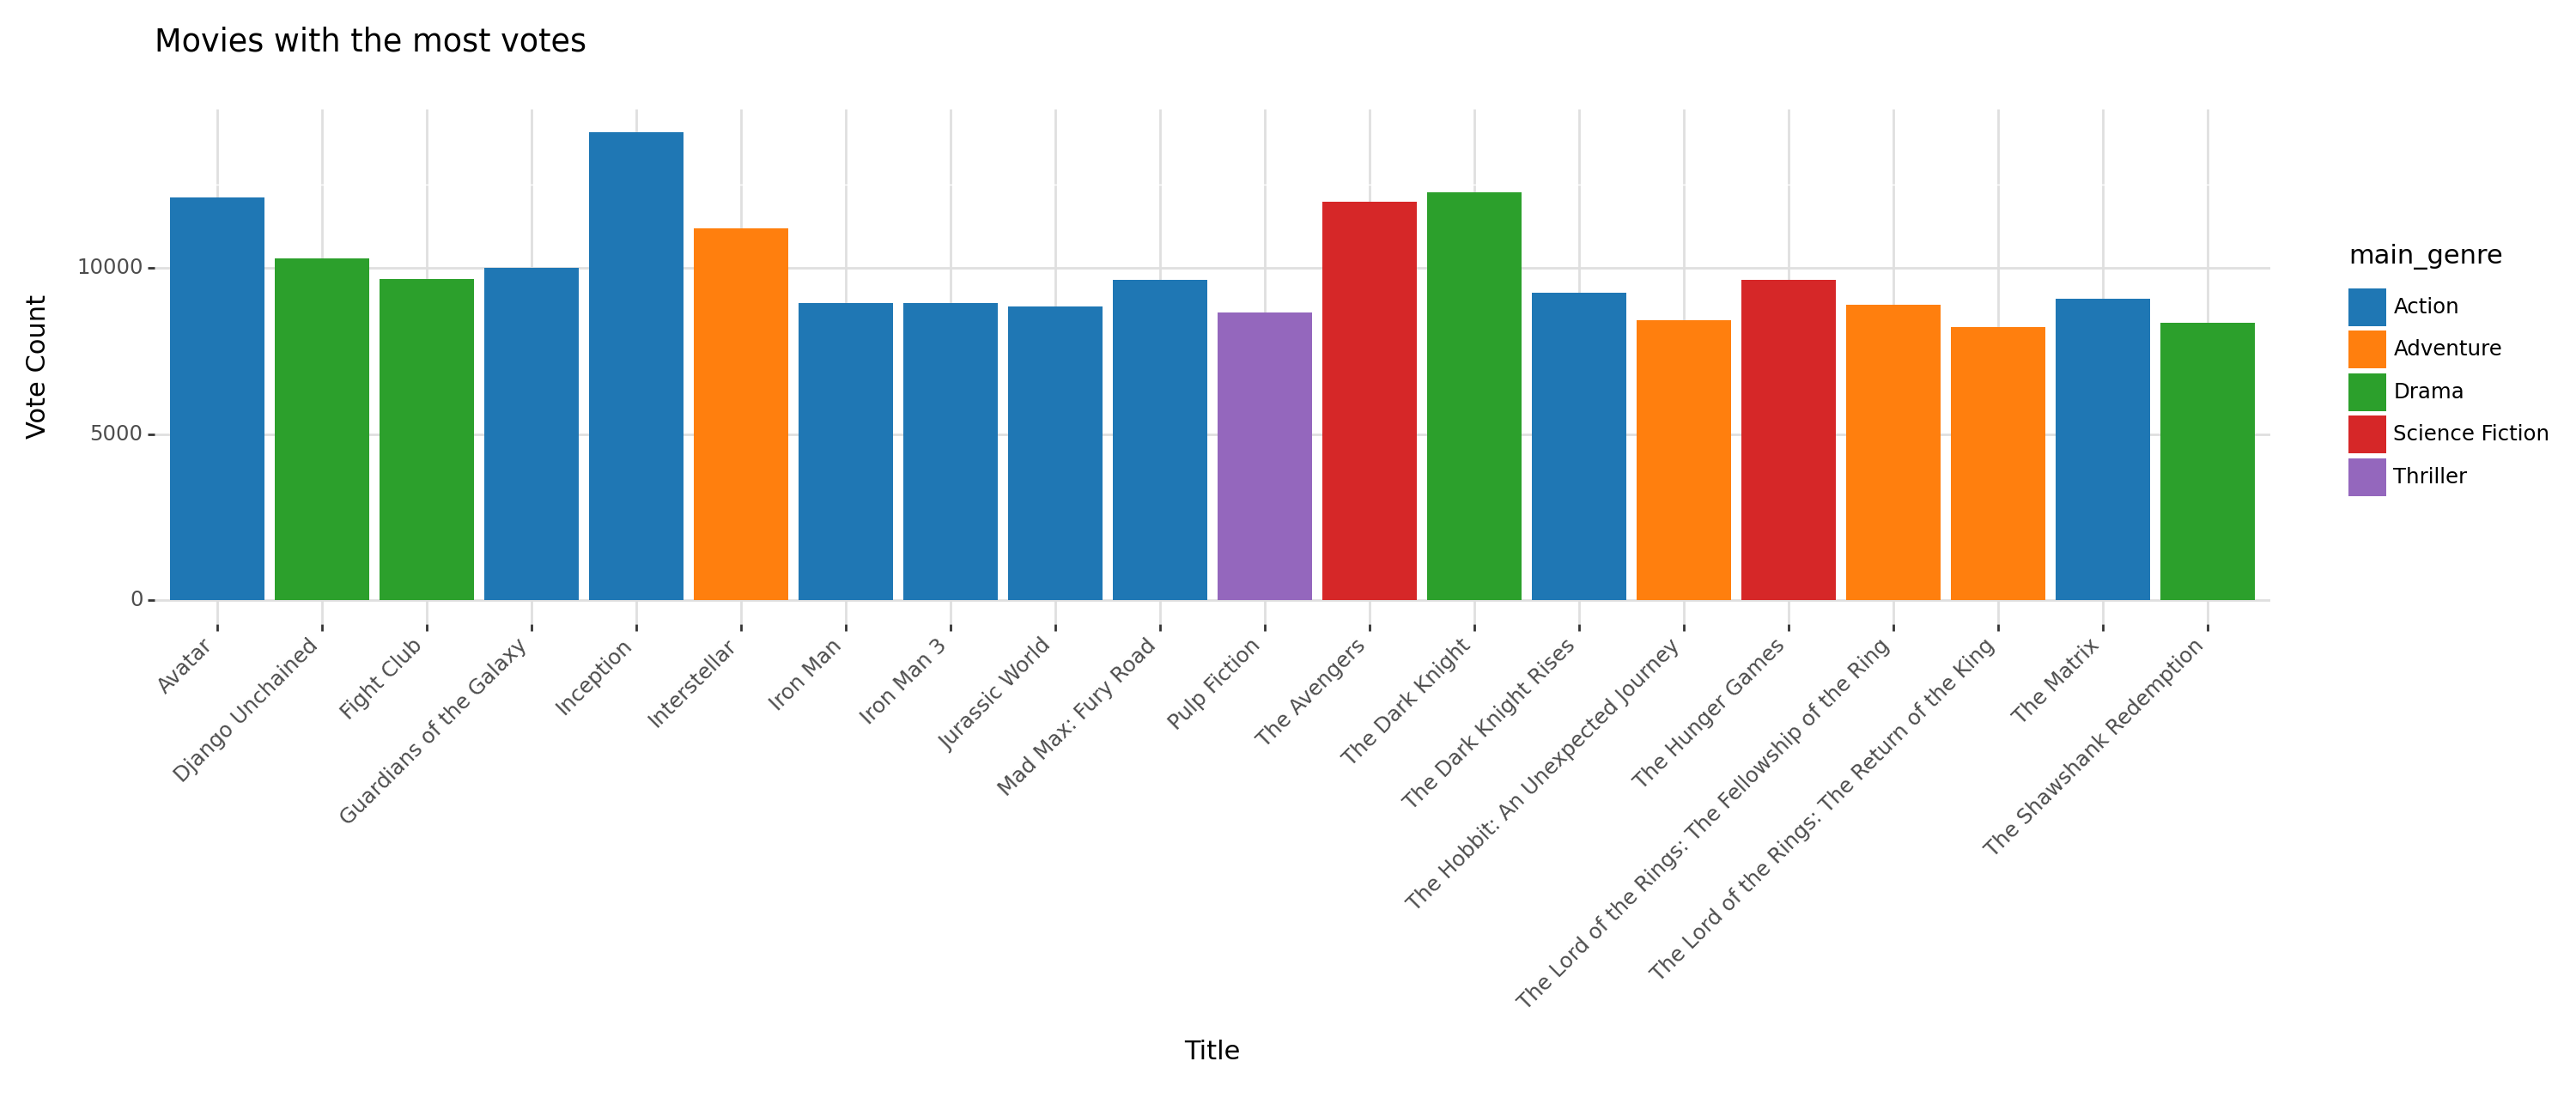

In [33]:
#Make a bar chart with top 10 movies with most votes and their genre. Color the bars by genre and make a legend for the colors.

df_votes = df_main.copy()
df_votes = df_votes.sort_values(by="vote_count", ascending=False)
df_votes = df_votes[["title", "release_year", "main_genre", "vote_count", "runtime"]].head(20)

p = (
    p9.ggplot(df_votes, p9.aes("title", "vote_count", fill="main_genre"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Vote Count", title="Movies with the most votes")
    # + p9.scale_y_continuous(breaks=range(0, 20000, 1000), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"])
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


                                               title  release_year  \
24934                                 Empire of Dirt          2013   
26452                                         Hunger          2001   
4333                            Night of the Zombies          1981   
17840                                         Deceit          1992   
20845                                 Senior Project          2015   
28639                                     Bejewelled          1991   
28640                                   Födelsedagen          2000   
23561                                         Terror          1981   
26439  The Wonderful Wizard of Oz: 50 Years of Magic          1990   
20844                                Evil Behind You          2006   

            main_genre  vote_count  runtime  
24934            Drama         0.0     99.0  
26452            Drama         0.0     82.0  
4333            Horror         0.0     88.0  
17840  Science Fiction         0.0     92.0  

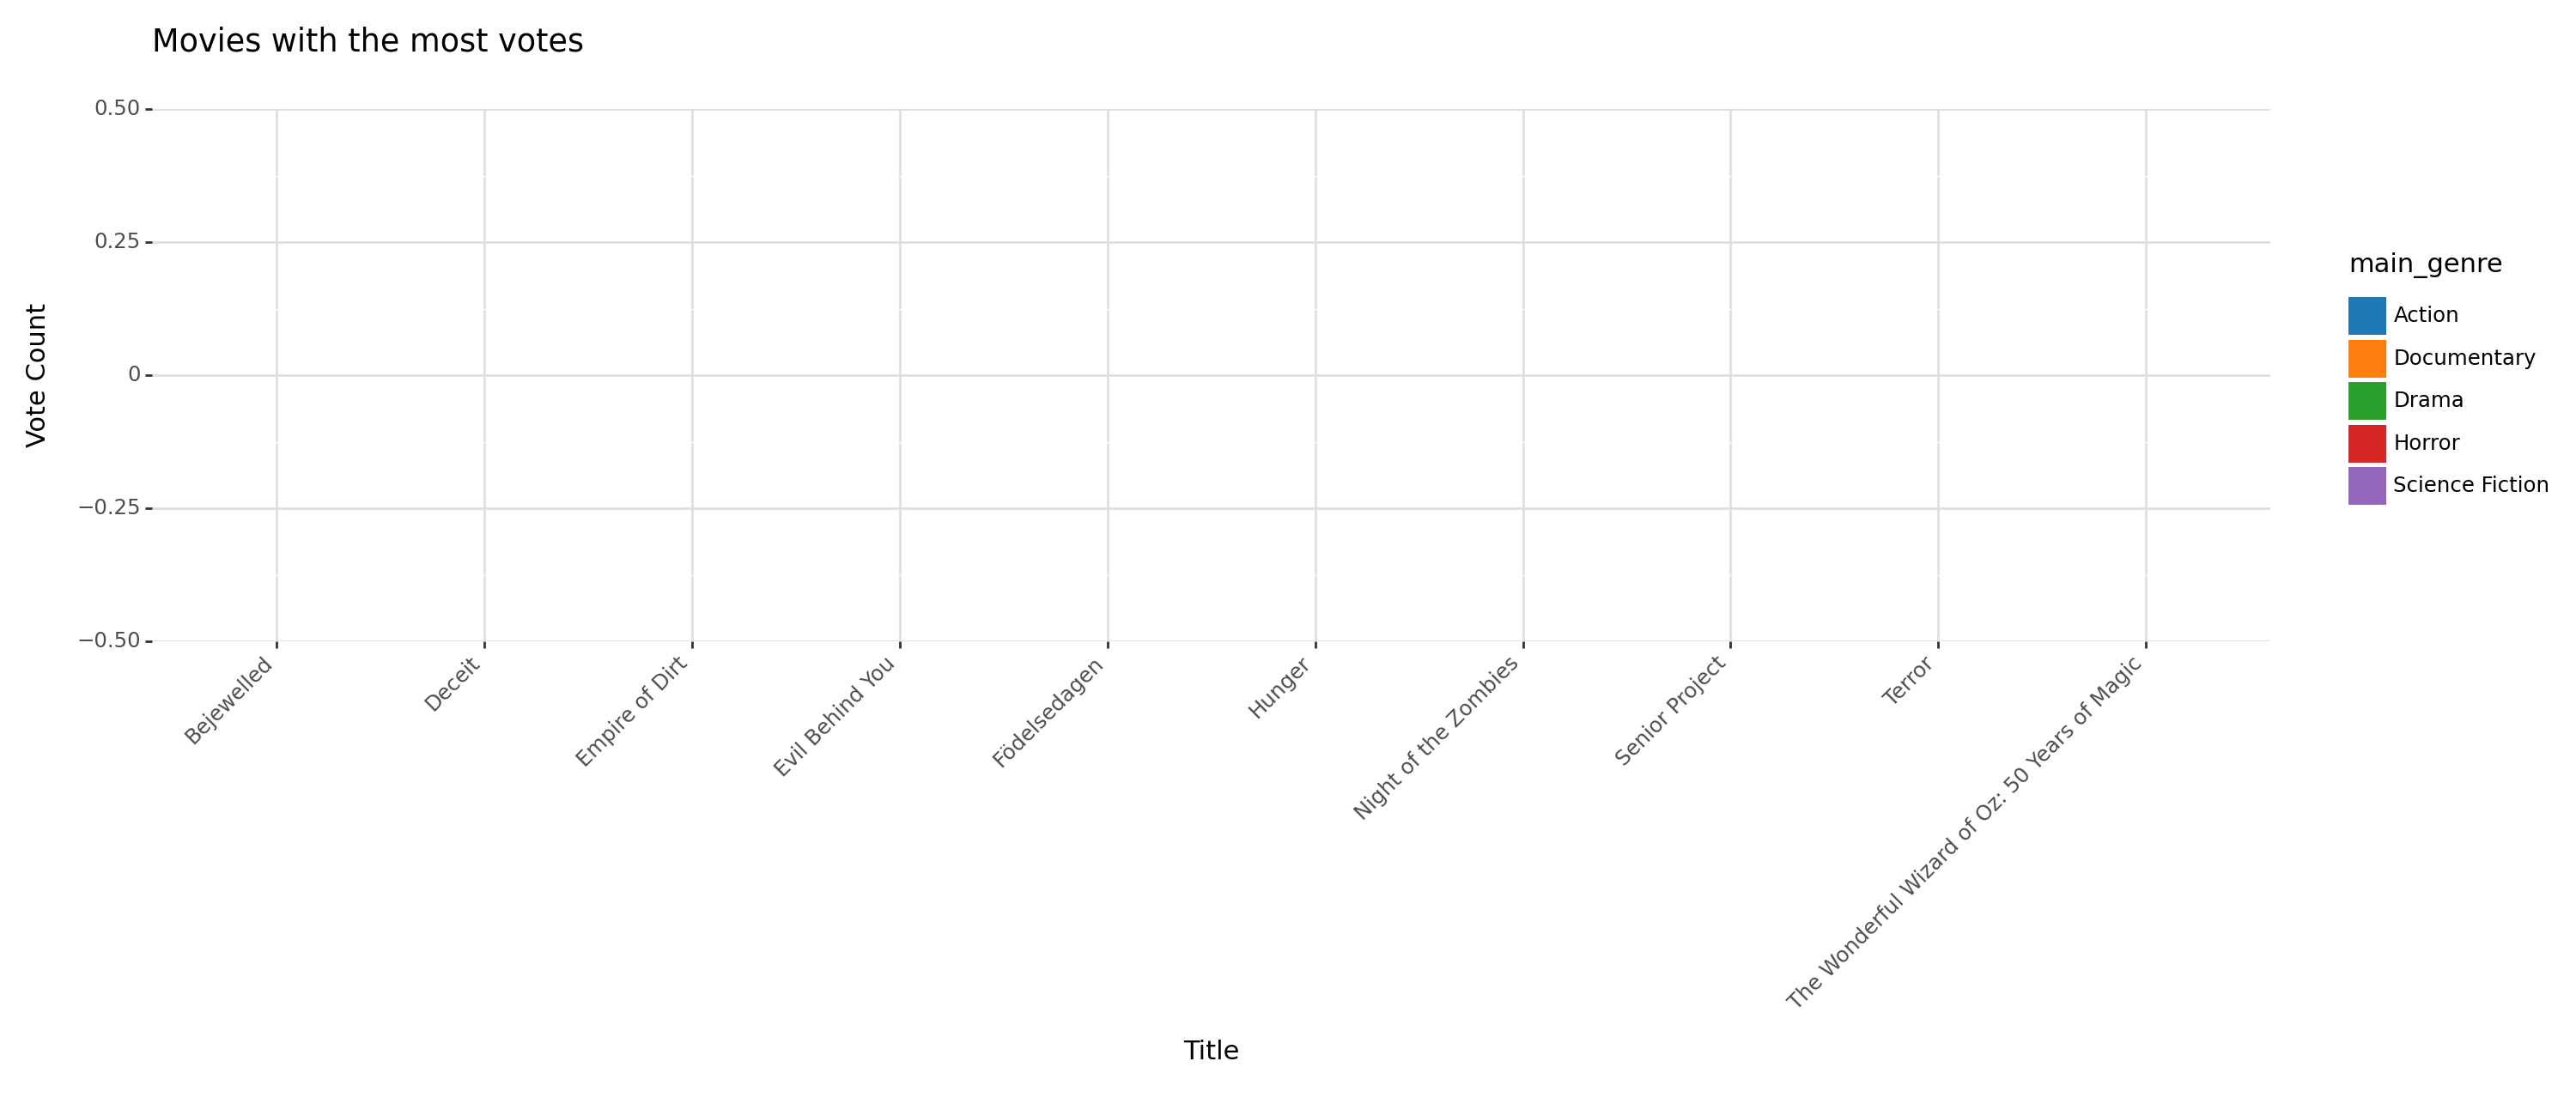

In [34]:
#Make a bar chart with top 10 movies with least votes and their genre. Color the bars by genre and make a legend for the colors.

df_votes = df_main.copy()
df_votes = df_votes.sort_values(by="vote_count", ascending=True)
df_votes = df_votes[["title", "release_year", "main_genre", "vote_count", "runtime"]].head(10)
print(df_votes.head(10))
p = (
    p9.ggplot(df_votes, p9.aes("title", "vote_count", fill="main_genre"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Vote Count", title="Movies with the most votes")
    # + p9.scale_y_continuous(breaks=range(0, 20000, 1000), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"])
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


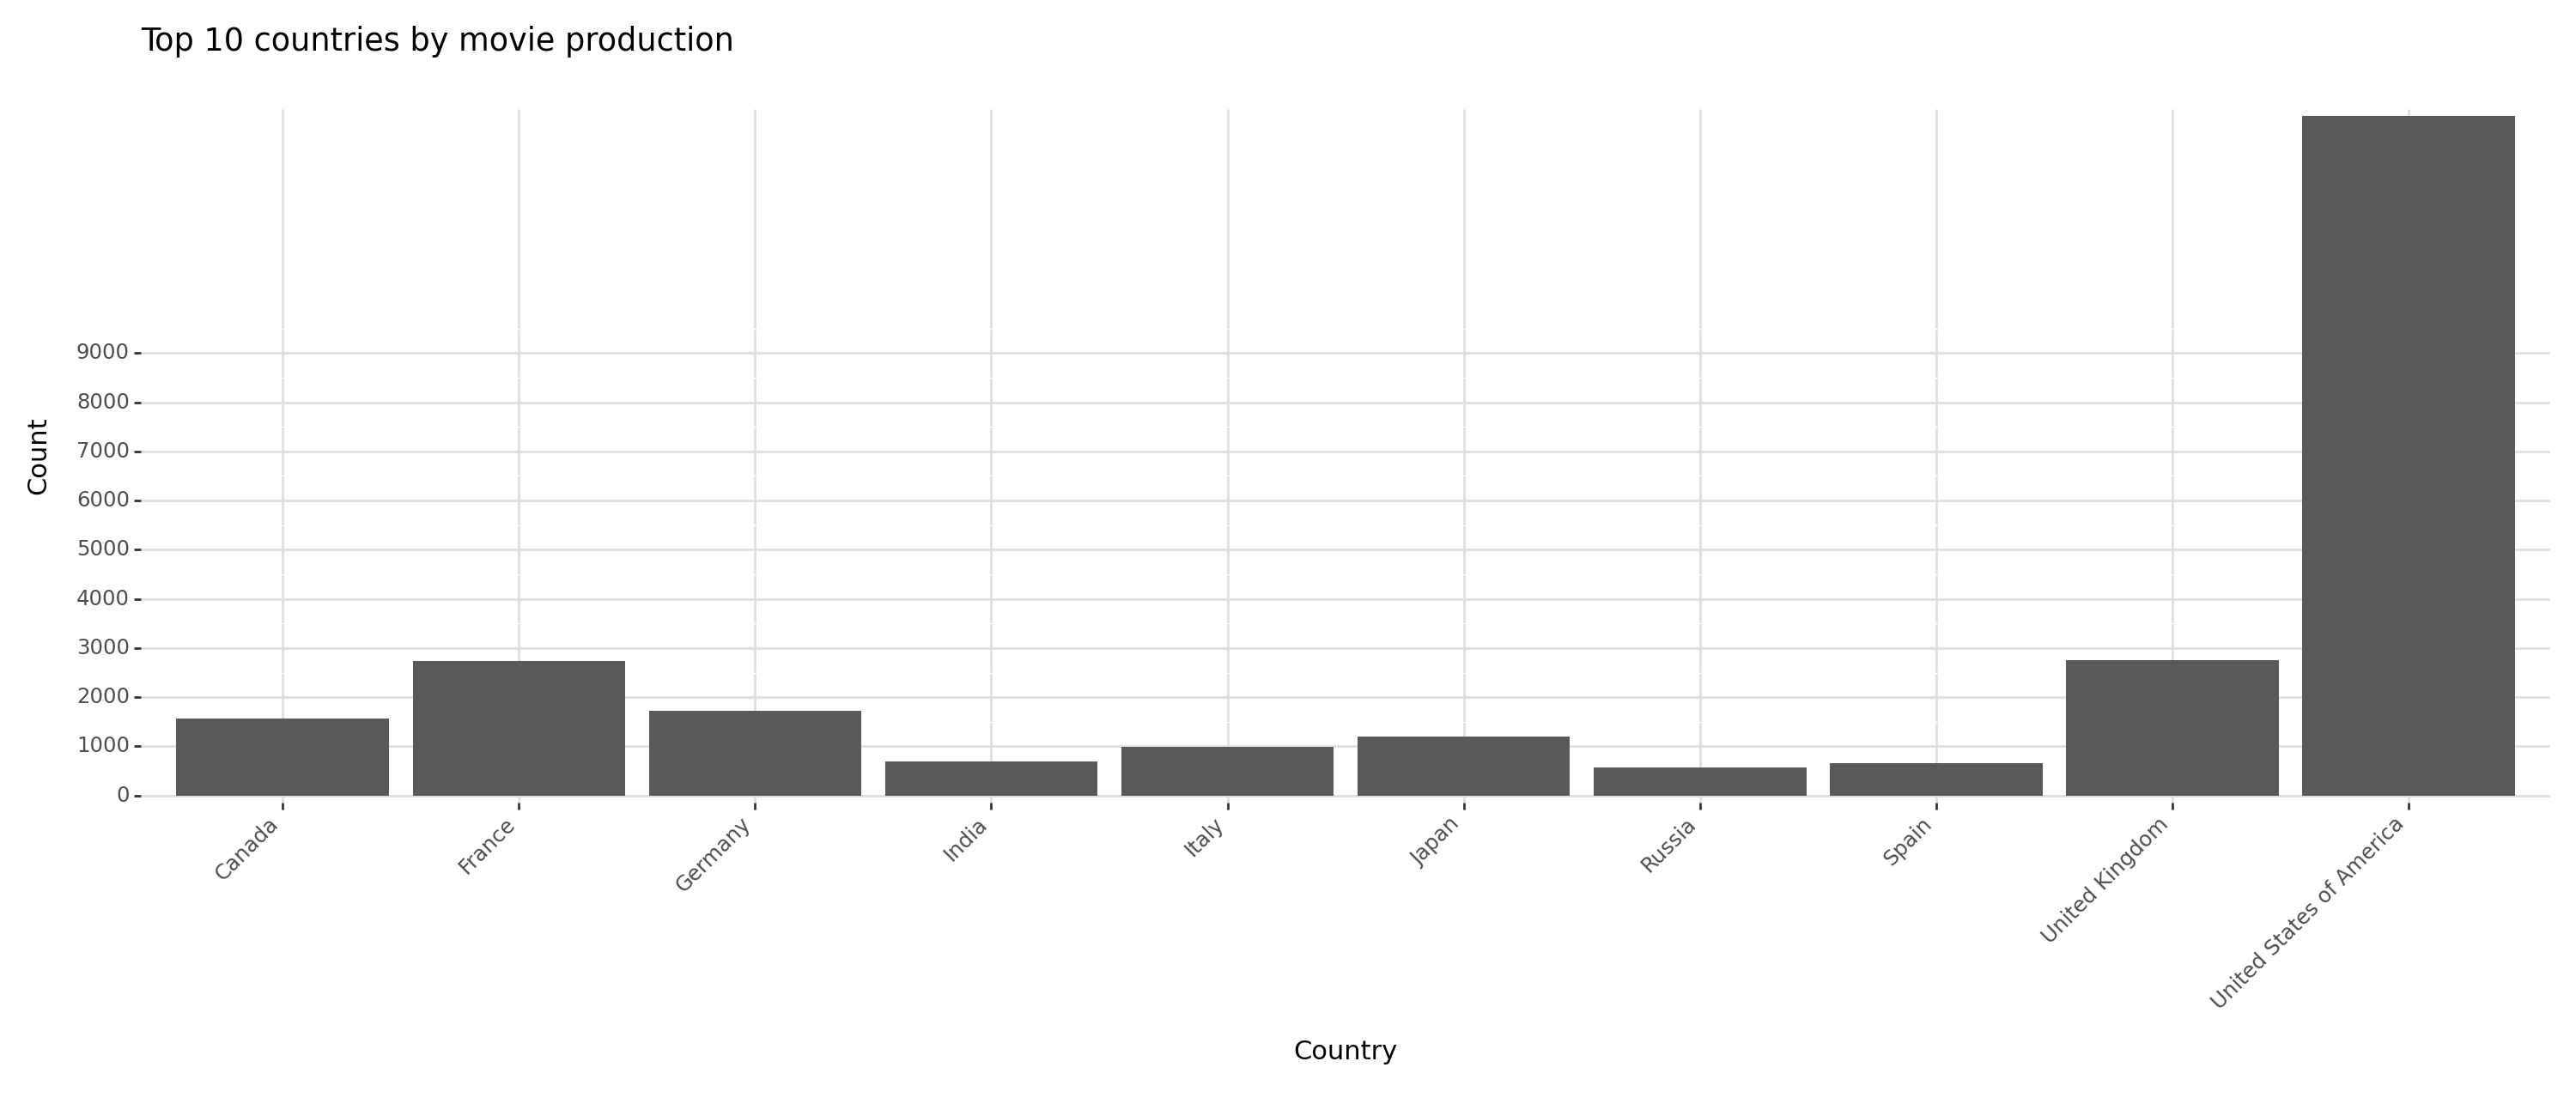

In [35]:
#Count the production countries and visualize the top 10 countries as a bar chart.
df_countries = df_main.copy()
df_countries = df_countries.explode("production_countries")
df_countries = df_countries.dropna(subset=["production_countries"])
df_countries["production_countries"] = df_countries["production_countries"].str.strip()
df_countries = df_countries.groupby("production_countries").size().reset_index(name="count")
df_countries = df_countries.sort_values(by="count", ascending=False)
df_countries = df_countries.head(10)

p = (
    p9.ggplot(df_countries, p9.aes("production_countries", "count"))
    + p9.geom_col()
    + p9.labs(x="Country", y="Count", title="Top 10 countries by movie production")
    + p9.scale_y_continuous(breaks=range(0, 10000, 1000), expand=(0.01, 0.01))
    + p9.theme(
        figure_size=(15, 6.5),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()


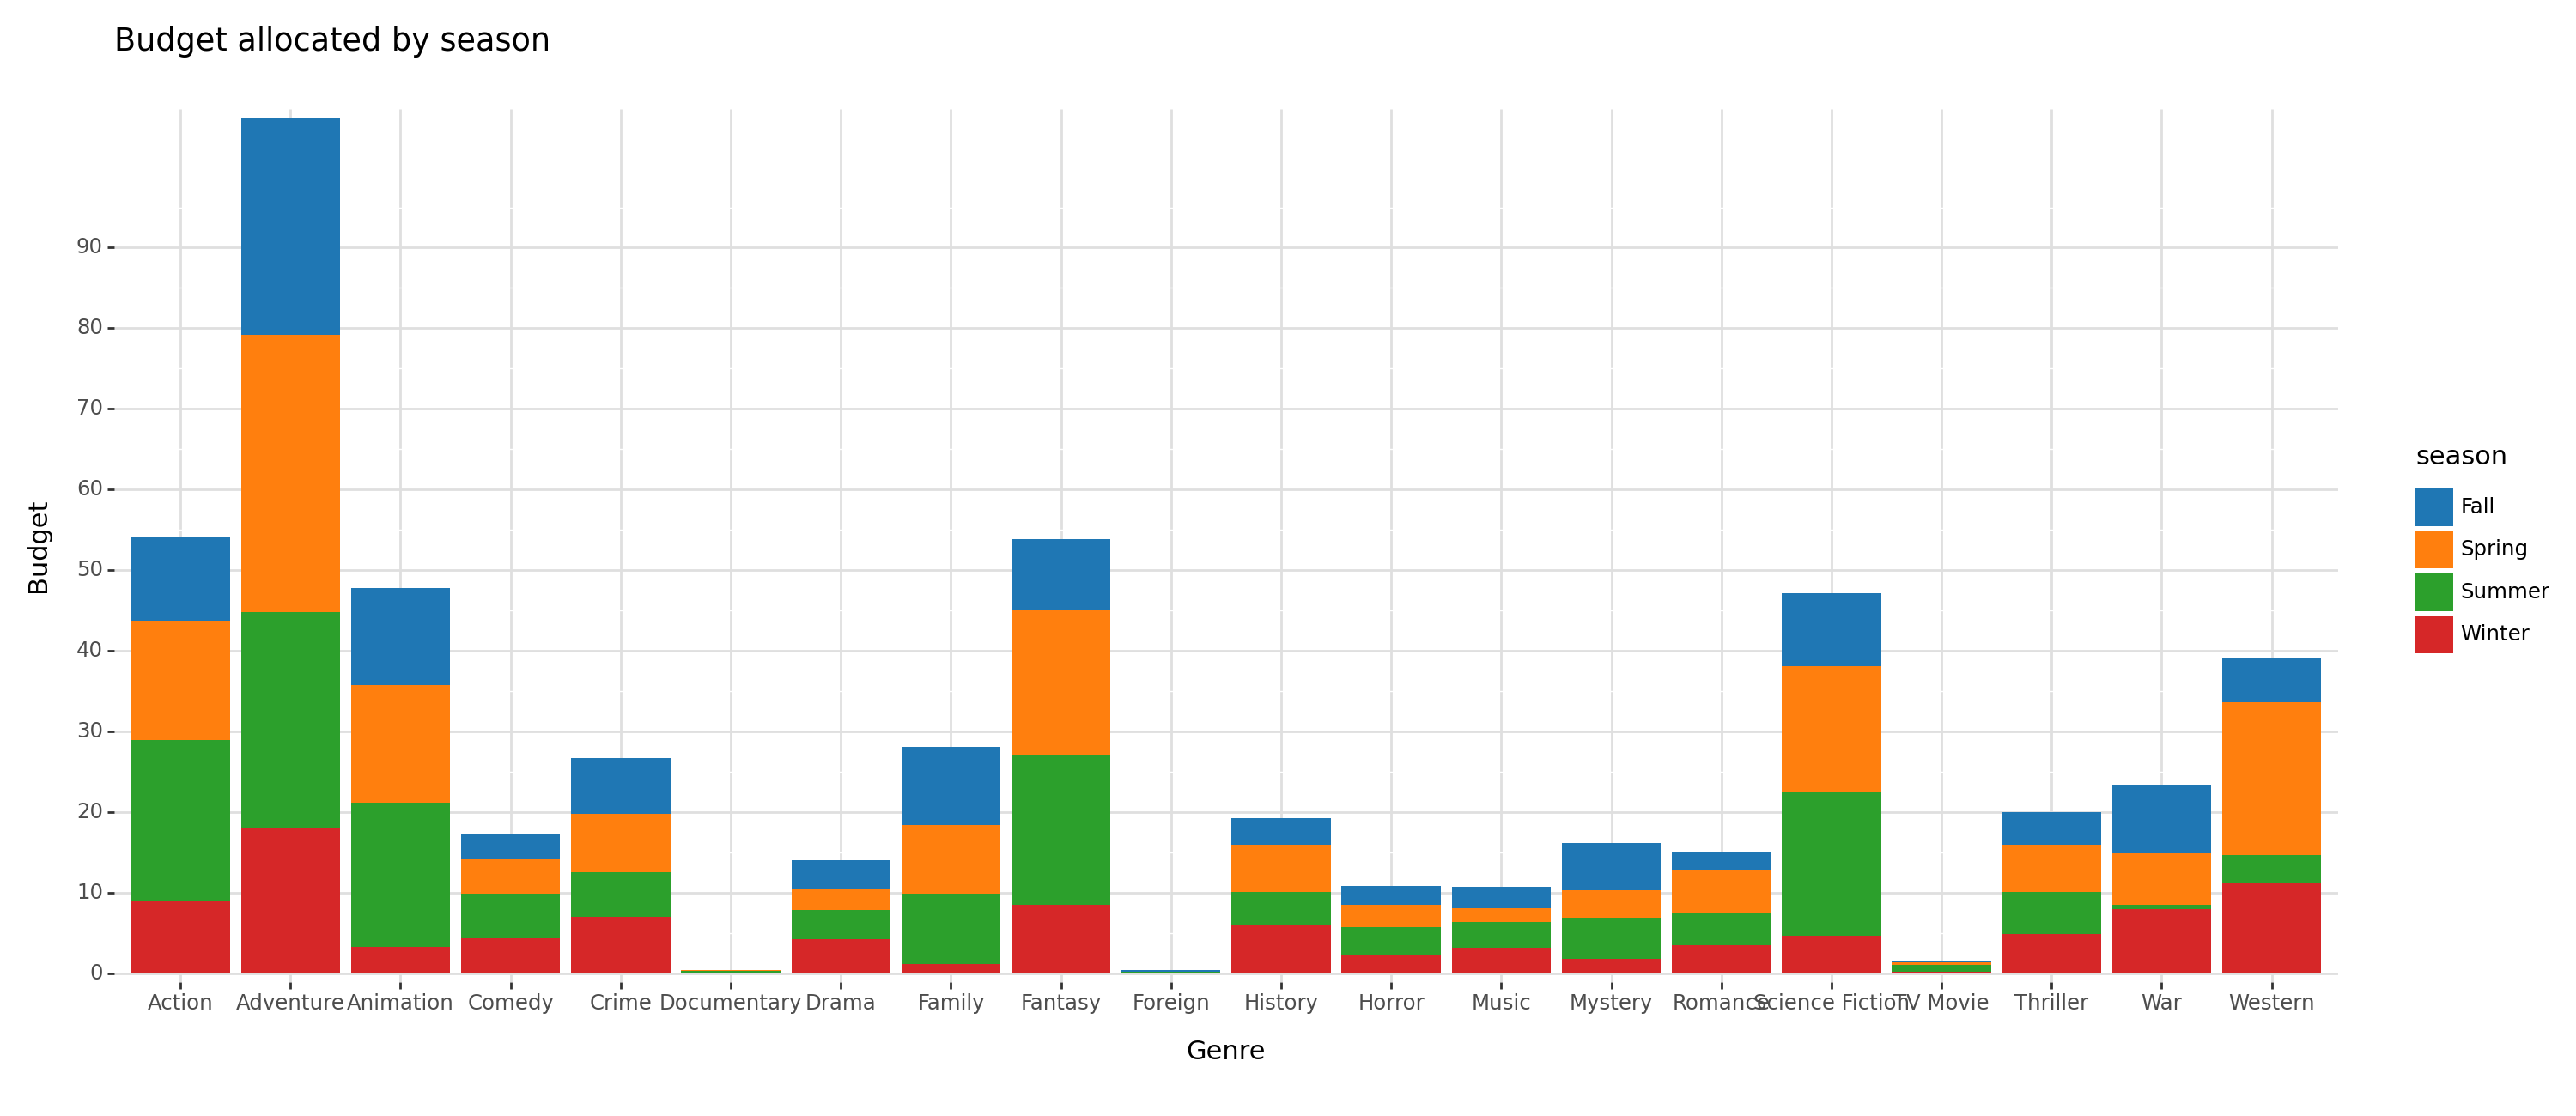

In [36]:
#For each genre, make a bar chart with the budget allocated by season
df_genres = df_main.copy()
df_genres = df_genres.explode("main_genre")
df_genres = df_genres.dropna(subset=["main_genre"])
df_genres["main_genre"] = df_genres["main_genre"].str.strip()
df_genres = df_genres.groupby(["main_genre", "season"])["budget"].mean().reset_index()
df_genres = df_genres.sort_values(by="budget", ascending=False)
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["budget"] = df_genres["budget"].round(2)

p = (
    p9.ggplot(df_genres, p9.aes("main_genre", "budget", fill="season"))
    + p9.geom_col()
    + p9.labs(x="Genre", y="Budget", title="Budget allocated by season")
    + p9.scale_y_continuous(breaks=range(0, 100, 10), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
    + p9.theme(
        figure_size=(15, 6.5),
         panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


In [ ]:
#Make an bar chart with all of the top 20 grossing movies and their production companies. Color the bars by production company and make a legend for the colors.

df_grossing = df_main.copy()
df_grossing = df_grossing.sort_values(by="revenue", ascending=False)
df_grossing = df_grossing[["title", "release_year", "production_companies", "revenue"]].head(20)
df_grossing = df_grossing.explode("production_companies")
df_grossing = df_grossing.dropna(subset=["production_companies"])

p = (
    p9.ggplot(df_grossing, p9.aes("title", "revenue", fill="production_companies"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Revenue", title="Top 20 grossing movies by production company")
    + p9.scale_y_continuous(breaks=range(0, 3000, 100), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
    + p9.theme(
        figure_size=(15, 6.5),
         panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()
